# 包引入和数据读取

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import os

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import json 
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from itertools import product
import ast

In [3]:
path = 'E:/Machine-learning/kdd_cup_2019/phase1/data/data_set_phase1/'
profiles      = pd.read_csv(path + 'profiles.csv') 

train_queries = pd.read_csv(path + 'train_queries.csv', parse_dates=['req_time'])
train_plans   = pd.read_csv(path + 'train_plans.csv', parse_dates=['plan_time'])
train_clicks  = pd.read_csv(path + 'train_clicks.csv')

test_queries  = pd.read_csv(path + 'test_queries.csv', parse_dates=['req_time'])
test_plans    = pd.read_csv(path + 'test_plans.csv', parse_dates=['plan_time'])

#读取节假日信息
holidy_inf    = pd.read_csv('../data/holiday_china_all.csv')

In [4]:
train_clicks.isnull().sum()

sid           0
click_time    0
click_mode    0
dtype: int64

In [5]:
train_clicks[train_clicks.isnull().values==True]

Empty DataFrame
Columns: [sid, click_time, click_mode]
Index: []

In [6]:
train_clicks[train_clicks['click_mode']==0]

Empty DataFrame
Columns: [sid, click_time, click_mode]
Index: []

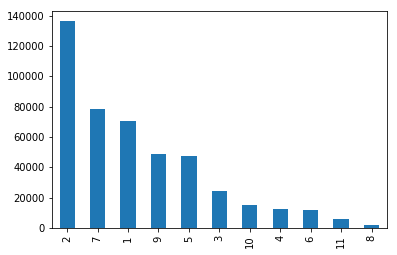

In [7]:
train_clicks['click_mode'].value_counts().plot.bar()

#  七张表基本观察

## 用户属性表

In [42]:
profiles.head()

pid   p0   p1   p2   p3   p4   p5   p6   p7   p8 ...   p56  p57  p58  \
0  196356  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0 ...   0.0  0.0  0.0   
1  204083  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0 ...   0.0  0.0  0.0   
2  170667  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0 ...   0.0  0.0  0.0   
3  115511  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0 ...   0.0  0.0  0.0   
4  129719  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0 ...   0.0  0.0  0.0   

   p59  p60  p61  p62  p63  p64  p65  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  1.0  0.0  0.0  0.0  1.0  0.0  0.0  
2  0.0  0.0  0.0  1.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
4  0.0  1.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 67 columns]

In [43]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63090 entries, 0 to 63089
Data columns (total 67 columns):
pid    63090 non-null int64
p0     63090 non-null float64
p1     63090 non-null float64
p2     63090 non-null float64
p3     63090 non-null float64
p4     63090 non-null float64
p5     63090 non-null float64
p6     63090 non-null float64
p7     63090 non-null float64
p8     63090 non-null float64
p9     63090 non-null float64
p10    63090 non-null float64
p11    63090 non-null float64
p12    63090 non-null float64
p13    63090 non-null float64
p14    63090 non-null float64
p15    63090 non-null float64
p16    63090 non-null float64
p17    63090 non-null float64
p18    63090 non-null float64
p19    63090 non-null float64
p20    63090 non-null float64
p21    63090 non-null float64
p22    63090 non-null float64
p23    63090 non-null float64
p24    63090 non-null float64
p25    63090 non-null float64
p26    63090 non-null float64
p27    63090 non-null float64
p28    63090 non-null f

基本信息：
   
    *不存在缺失
    *pid的标识都是唯一的

In [6]:
profiles.shape

(63090, 67)

In [7]:
for feature in profiles.columns:
    uniq_num = len(profiles[feature].unique())
    print("Feature(%s) ----- count(%d)" % (feature, uniq_num))

Feature(pid) ----- count(63090)
Feature(p0) ----- count(2)
Feature(p1) ----- count(2)
Feature(p2) ----- count(2)
Feature(p3) ----- count(2)
Feature(p4) ----- count(2)
Feature(p5) ----- count(2)
Feature(p6) ----- count(2)
Feature(p7) ----- count(2)
Feature(p8) ----- count(2)
Feature(p9) ----- count(2)
Feature(p10) ----- count(2)
Feature(p11) ----- count(2)
Feature(p12) ----- count(2)
Feature(p13) ----- count(2)
Feature(p14) ----- count(2)
Feature(p15) ----- count(2)
Feature(p16) ----- count(2)
Feature(p17) ----- count(2)
Feature(p18) ----- count(2)
Feature(p19) ----- count(2)
Feature(p20) ----- count(2)
Feature(p21) ----- count(2)
Feature(p22) ----- count(2)
Feature(p23) ----- count(2)
Feature(p24) ----- count(2)
Feature(p25) ----- count(2)
Feature(p26) ----- count(2)
Feature(p27) ----- count(2)
Feature(p28) ----- count(2)
Feature(p29) ----- count(2)
Feature(p30) ----- count(2)
Feature(p31) ----- count(2)
Feature(p32) ----- count(2)
Feature(p33) ----- count(2)
Feature(p34) ----- count(2

所有个人信息列，都是离散型的2值，分为0和1

-----------------------------------------    p0   -----------------------------------------
二值比例: 3.303977078927621         为0的数量：  48432         为1的数量：  14658


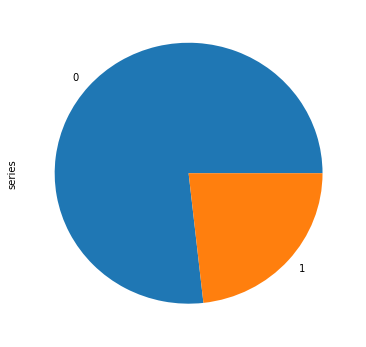

-----------------------------------------    p1   -----------------------------------------
二值比例: 1751.5555555555557         为0的数量：  63055         为1的数量：  35


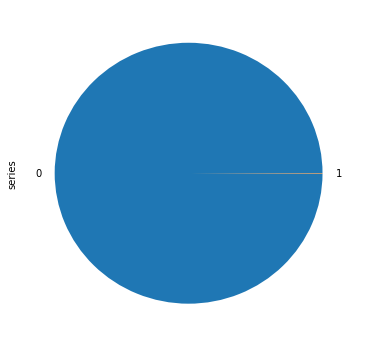

-----------------------------------------    p2   -----------------------------------------
二值比例: 1.7677999561307305         为0的数量：  40296         为1的数量：  22794


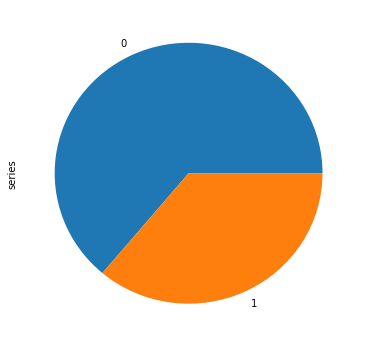

-----------------------------------------    p3   -----------------------------------------
二值比例: 2.8900055490474137         为0的数量：  46872         为1的数量：  16218


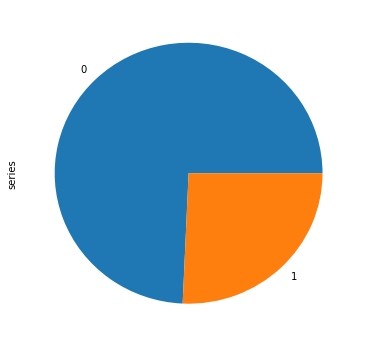

-----------------------------------------    p4   -----------------------------------------
二值比例: 7.280876755479722         为0的数量：  55472         为1的数量：  7618


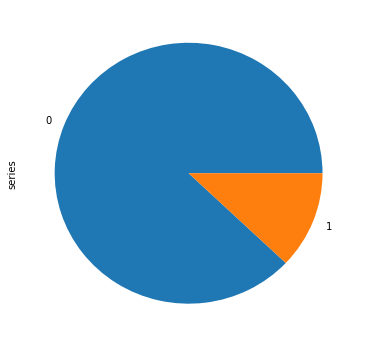

-----------------------------------------    p5   -----------------------------------------
二值比例: 42.15458276333789         为0的数量：  61629         为1的数量：  1461


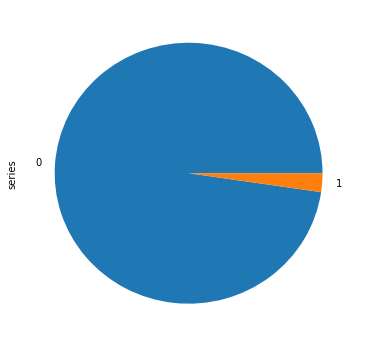

-----------------------------------------    p6   -----------------------------------------
二值比例: 243.54263565891472         为0的数量：  62833         为1的数量：  257


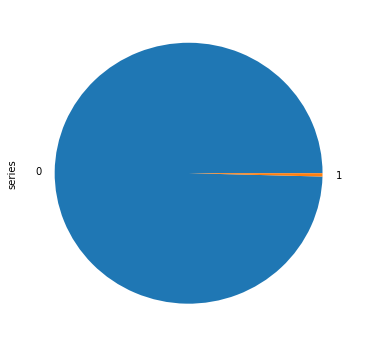

-----------------------------------------    p7   -----------------------------------------
二值比例: 1.424377497694436         为0的数量：  37067         为1的数量：  26023


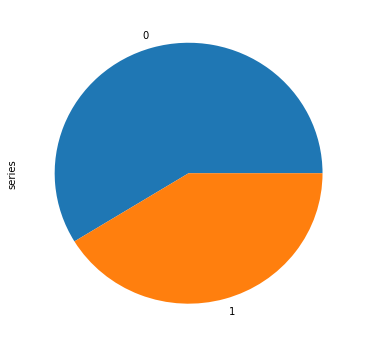

-----------------------------------------    p8   -----------------------------------------
二值比例: 0.7042219280948651         为0的数量：  26070         为1的数量：  37020


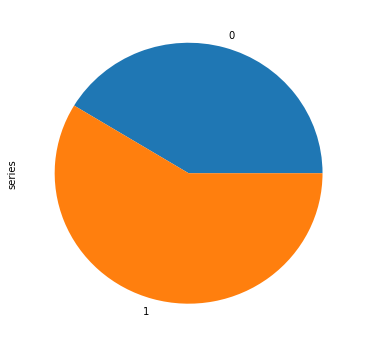

-----------------------------------------    p9   -----------------------------------------
二值比例: 0.9819683975748437         为0的数量：  31258         为1的数量：  31832


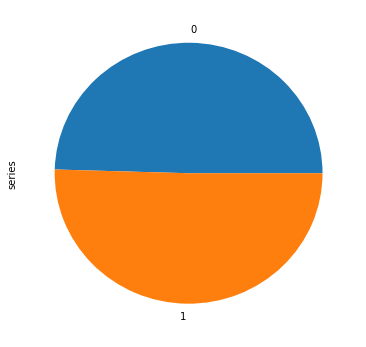

-----------------------------------------    p10   -----------------------------------------
二值比例: 5.170366748166259         为0的数量：  52866         为1的数量：  10224


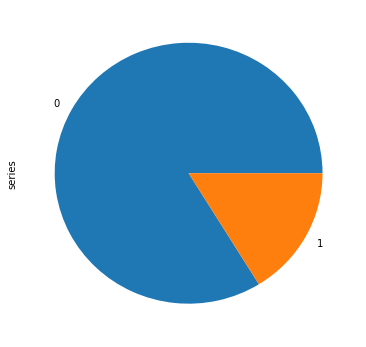

-----------------------------------------    p11   -----------------------------------------
二值比例: 969.6461538461539         为0的数量：  63026         为1的数量：  64


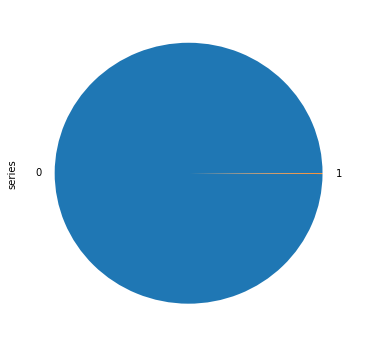

-----------------------------------------    p12   -----------------------------------------
二值比例: 7885.5         为0的数量：  63083         为1的数量：  7


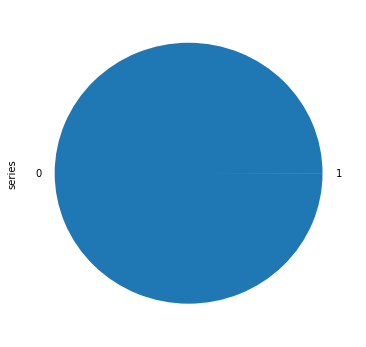

-----------------------------------------    p13   -----------------------------------------
二值比例: 393.325         为0的数量：  62931         为1的数量：  159


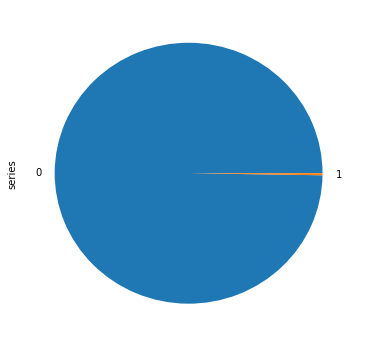

-----------------------------------------    p14   -----------------------------------------
二值比例: 110.27336860670194         为0的数量：  62524         为1的数量：  566


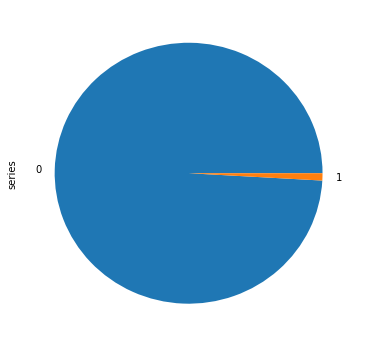

-----------------------------------------    p15   -----------------------------------------
二值比例: 43.08944793850454         为0的数量：  61660         为1的数量：  1430


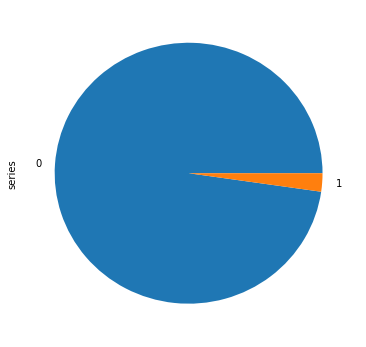

-----------------------------------------    p16   -----------------------------------------
二值比例: 30.049212598425196         为0的数量：  61059         为1的数量：  2031


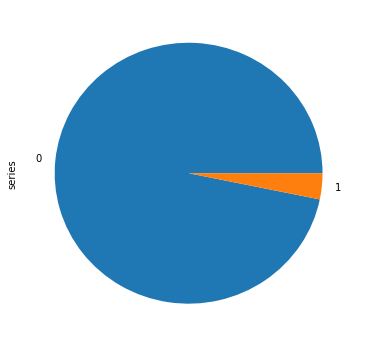

-----------------------------------------    p17   -----------------------------------------
二值比例: 18.927984838913456         为0的数量：  59925         为1的数量：  3165


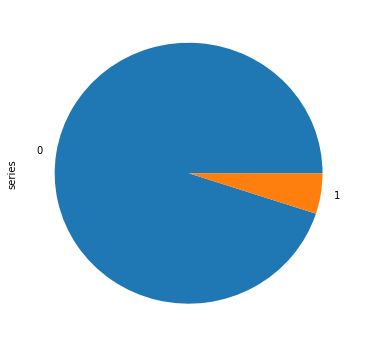

-----------------------------------------    p18   -----------------------------------------
二值比例: 22.790346907993968         为0的数量：  60439         为1的数量：  2651


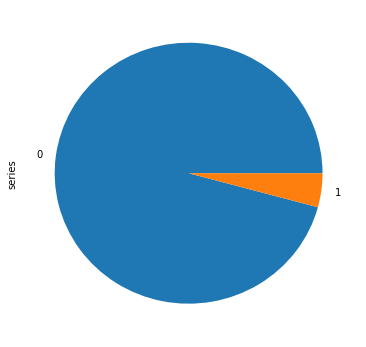

-----------------------------------------    p19   -----------------------------------------
二值比例: 40.15590345727332         为0的数量：  61558         为1的数量：  1532


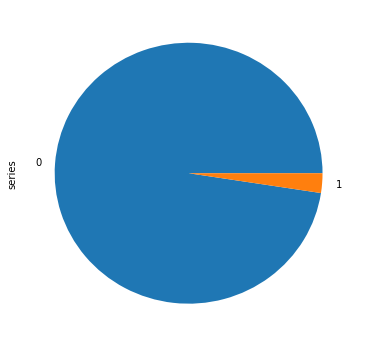

-----------------------------------------    p20   -----------------------------------------
二值比例: 130.44166666666666         为0的数量：  62611         为1的数量：  479


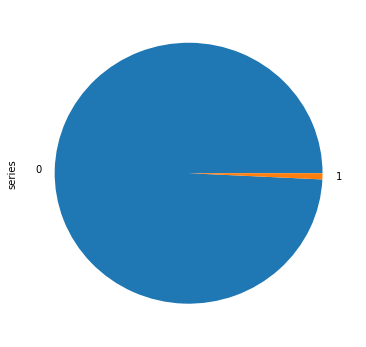

-----------------------------------------    p21   -----------------------------------------
二值比例: 12.040926002480363         为0的数量：  58253         为1的数量：  4837


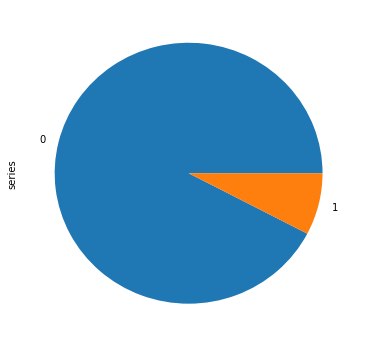

-----------------------------------------    p22   -----------------------------------------
二值比例: 39.08386277001271         为0的数量：  61517         为1的数量：  1573


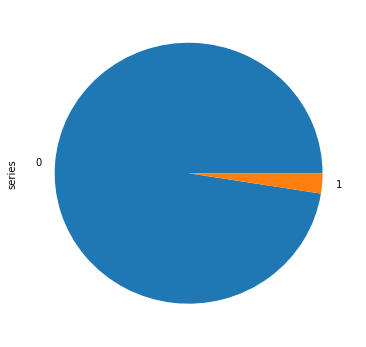

-----------------------------------------    p23   -----------------------------------------
二值比例: 462.9117647058824         为0的数量：  62955         为1的数量：  135


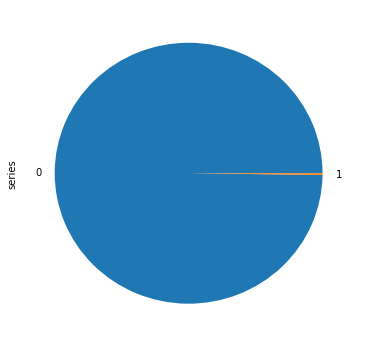

-----------------------------------------    p24   -----------------------------------------
二值比例: 715.9545454545455         为0的数量：  63003         为1的数量：  87


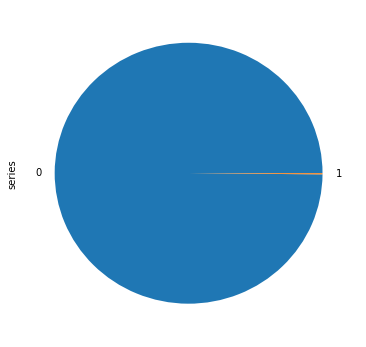

-----------------------------------------    p25   -----------------------------------------
二值比例: 663.1263157894737         为0的数量：  62996         为1的数量：  94


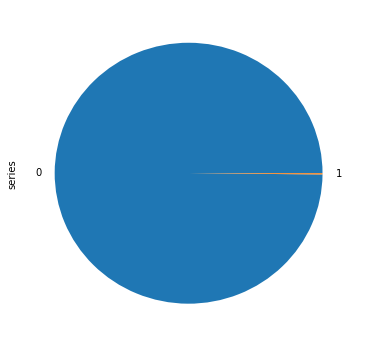

-----------------------------------------    p26   -----------------------------------------
二值比例: 3.115590345727332         为0的数量：  47761         为1的数量：  15329


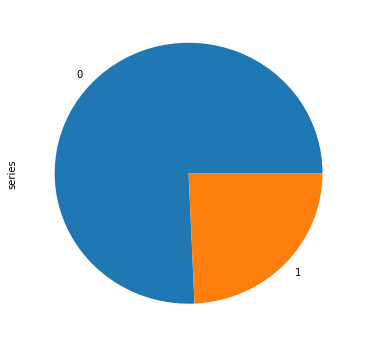

-----------------------------------------    p27   -----------------------------------------
二值比例: 4.011676860751449         为0的数量：  50502         为1的数量：  12588


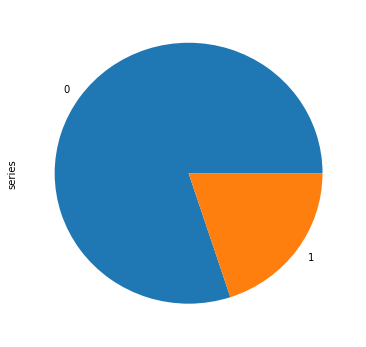

-----------------------------------------    p28   -----------------------------------------
二值比例: 3.6244960785750933         为0的数量：  49448         为1的数量：  13642


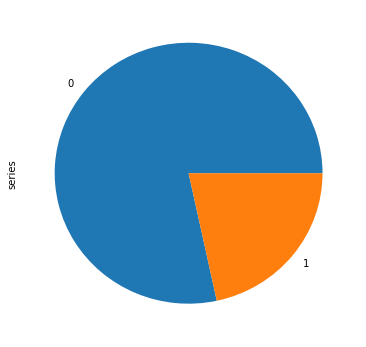

-----------------------------------------    p29   -----------------------------------------
二值比例: 2.577658066345336         为0的数量：  45456         为1的数量：  17634


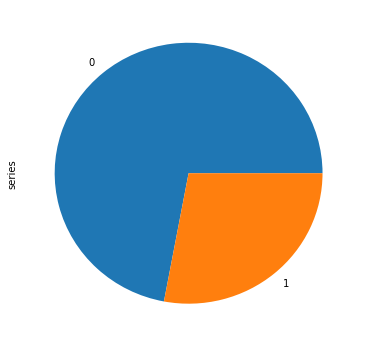

-----------------------------------------    p30   -----------------------------------------
二值比例: 0.43769938929906116         为0的数量：  19207         为1的数量：  43883


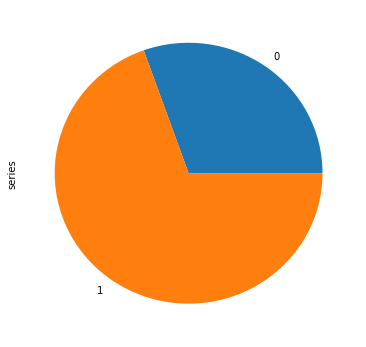

-----------------------------------------    p31   -----------------------------------------
二值比例: 2.385127159566477         为0的数量：  44453         为1的数量：  18637


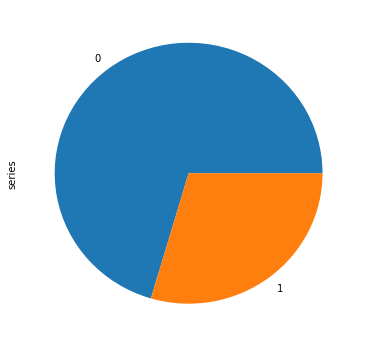

-----------------------------------------    p32   -----------------------------------------
二值比例: 1.4517934170131737         为0的数量：  37358         为1的数量：  25732


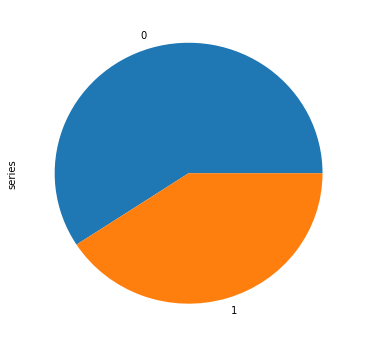

-----------------------------------------    p33   -----------------------------------------
二值比例: 4.595246541326712         为0的数量：  51815         为1的数量：  11275


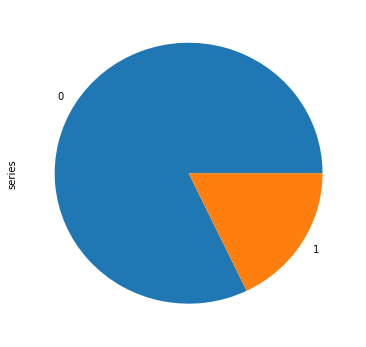

-----------------------------------------    p34   -----------------------------------------
二值比例: 1.4661689403119258         为0的数量：  37508         为1的数量：  25582


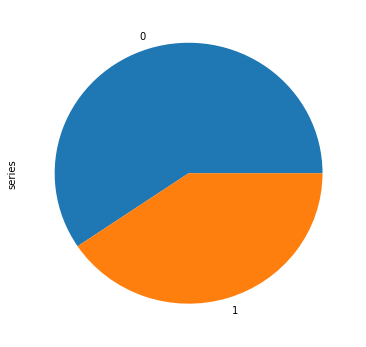

-----------------------------------------    p35   -----------------------------------------
二值比例: 1.8831513046657222         为0的数量：  41208         为1的数量：  21882


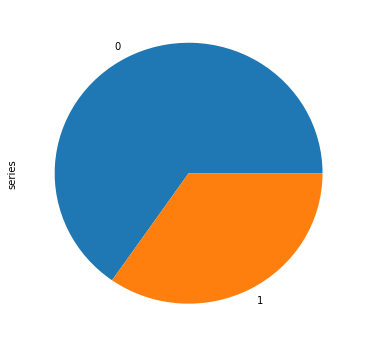

-----------------------------------------    p36   -----------------------------------------
二值比例: 2.945716072545341         为0的数量：  47101         为1的数量：  15989


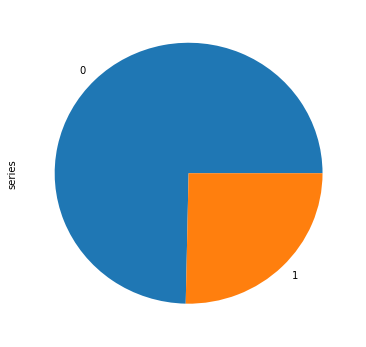

-----------------------------------------    p37   -----------------------------------------
二值比例: 1.5585790178028307         为0的数量：  38432         为1的数量：  24658


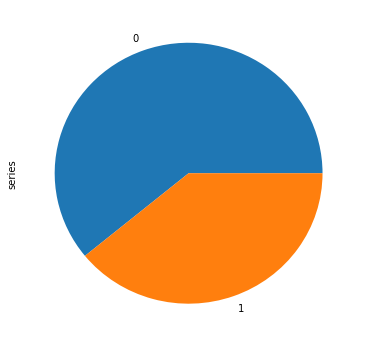

-----------------------------------------    p38   -----------------------------------------
二值比例: 12.80266900021877         为0的数量：  58520         为1的数量：  4570


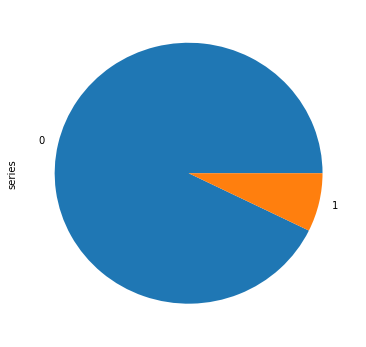

-----------------------------------------    p39   -----------------------------------------
二值比例: 13.460692184276875         为0的数量：  58728         为1的数量：  4362


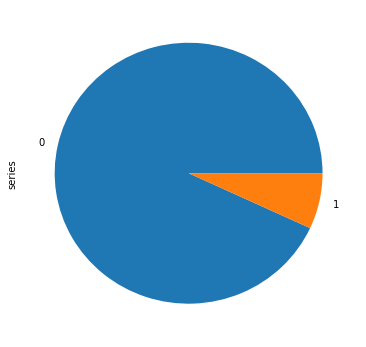

-----------------------------------------    p40   -----------------------------------------
二值比例: 15.704262642308711         为0的数量：  59314         为1的数量：  3776


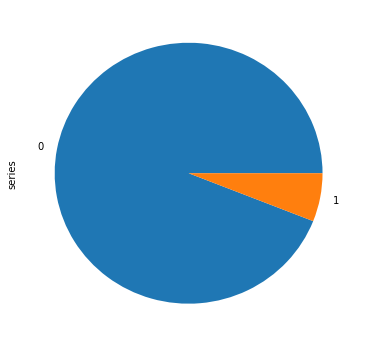

-----------------------------------------    p41   -----------------------------------------
二值比例: 84.02964959568733         为0的数量：  62349         为1的数量：  741


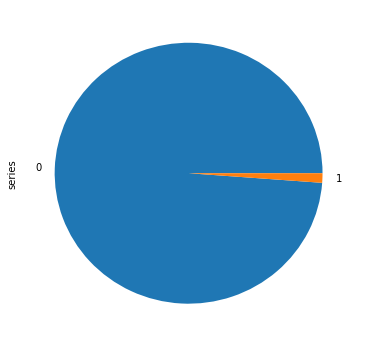

-----------------------------------------    p42   -----------------------------------------
二值比例: 13.581003004391032         为0的数量：  58764         为1的数量：  4326


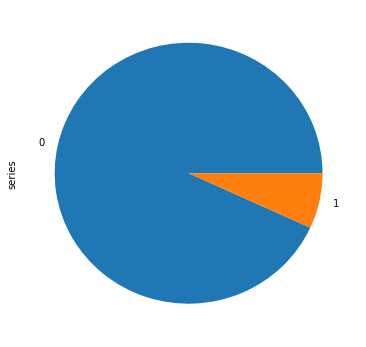

-----------------------------------------    p43   -----------------------------------------
二值比例: 39.495507060333765         为0的数量：  61533         为1的数量：  1557


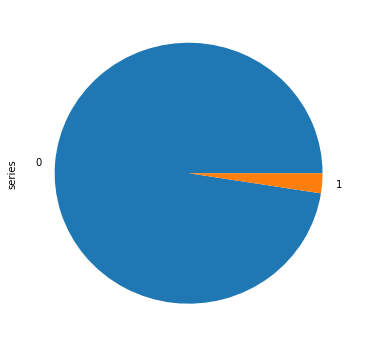

-----------------------------------------    p44   -----------------------------------------
二值比例: 41.45760430686406         为0的数量：  61605         为1的数量：  1485


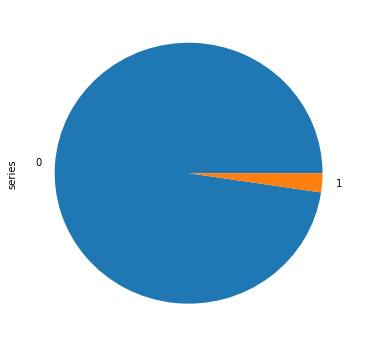

-----------------------------------------    p45   -----------------------------------------
二值比例: 29.77658536585366         为0的数量：  61041         为1的数量：  2049


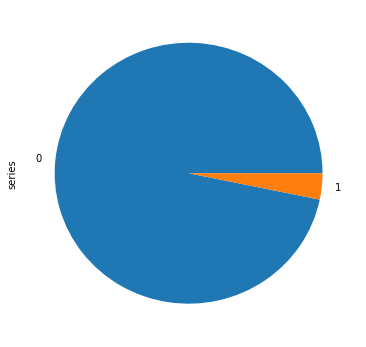

-----------------------------------------    p46   -----------------------------------------
二值比例: 16.72247191011236         为0的数量：  59531         为1的数量：  3559


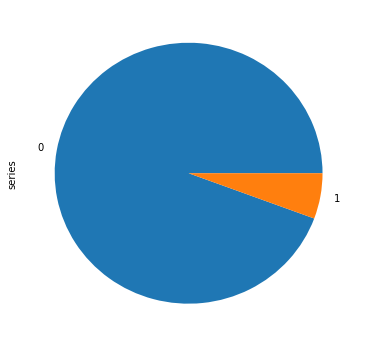

-----------------------------------------    p47   -----------------------------------------
二值比例: 9.204108038169174         为0的数量：  56908         为1的数量：  6182


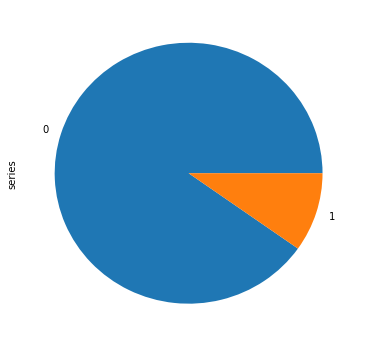

-----------------------------------------    p48   -----------------------------------------
二值比例: 34.48481439820023         为0的数量：  61313         为1的数量：  1777


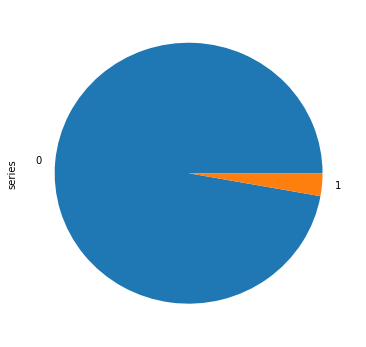

-----------------------------------------    p49   -----------------------------------------
二值比例: 21.06013986013986         为0的数量：  60231         为1的数量：  2859


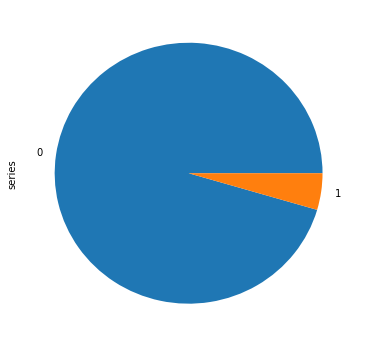

-----------------------------------------    p50   -----------------------------------------
二值比例: 34.070594774874934         为0的数量：  61292         为1的数量：  1798


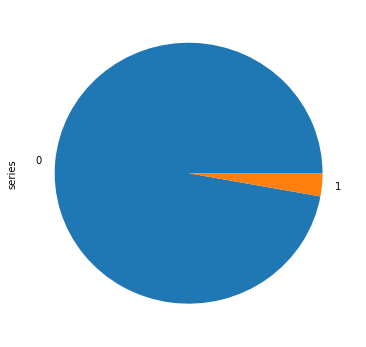

-----------------------------------------    p51   -----------------------------------------
二值比例: 31.255623721881392         为0的数量：  61135         为1的数量：  1955


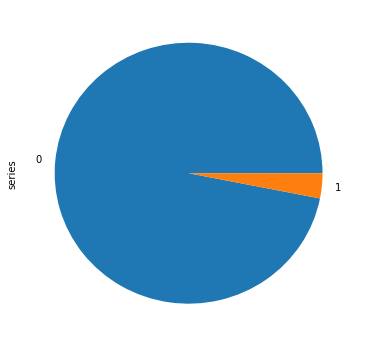

-----------------------------------------    p52   -----------------------------------------
二值比例: 56.35636363636364         为0的数量：  61991         为1的数量：  1099


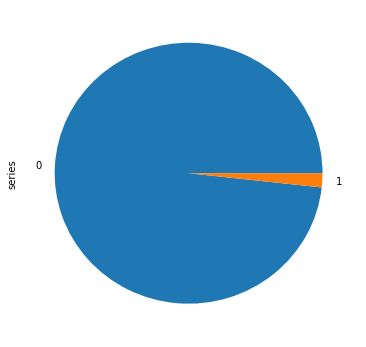

-----------------------------------------    p53   -----------------------------------------
二值比例: 36.984346779048764         为0的数量：  61430         为1的数量：  1660


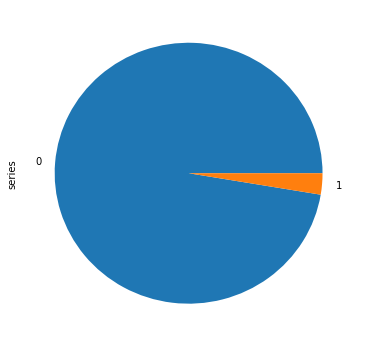

-----------------------------------------    p54   -----------------------------------------
二值比例: 10.529970760233919         为0的数量：  57619         为1的数量：  5471


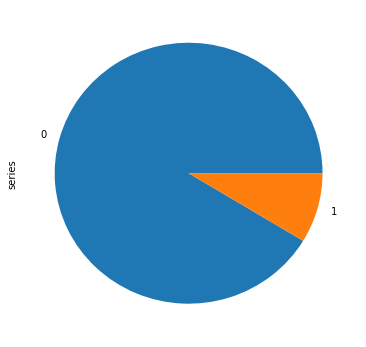

-----------------------------------------    p55   -----------------------------------------
二值比例: 38.211932877563704         为0的数量：  61482         为1的数量：  1608


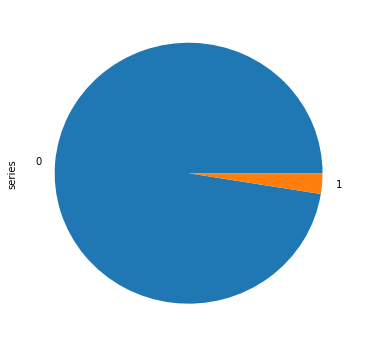

-----------------------------------------    p56   -----------------------------------------
二值比例: 18.460826650215918         为0的数量：  59849         为1的数量：  3241


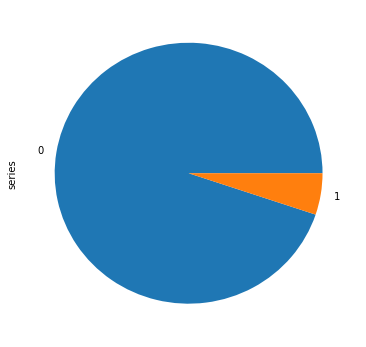

-----------------------------------------    p57   -----------------------------------------
二值比例: 11.75616659927214         为0的数量：  58145         为1的数量：  4945


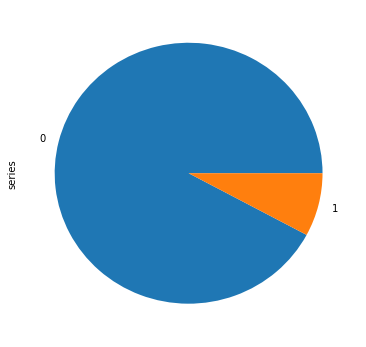

-----------------------------------------    p58   -----------------------------------------
二值比例: 79.47448979591837         为0的数量：  62307         为1的数量：  783


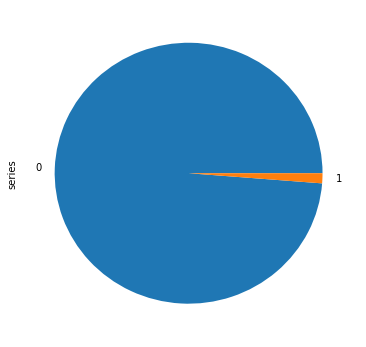

-----------------------------------------    p59   -----------------------------------------
二值比例: 33.28913043478261         为0的数量：  61251         为1的数量：  1839


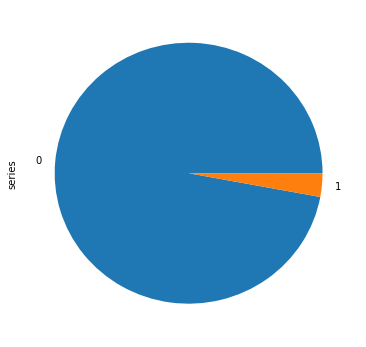

-----------------------------------------    p60   -----------------------------------------
二值比例: 1.781221071192418         为0的数量：  40406         为1的数量：  22684


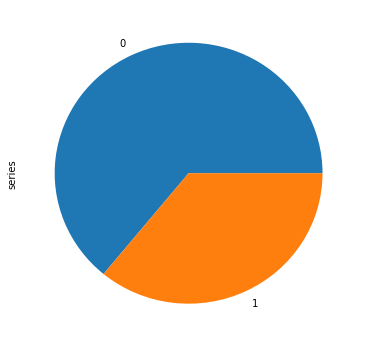

-----------------------------------------    p61   -----------------------------------------
二值比例: 9.307466100310407         为0的数量：  56970         为1的数量：  6120


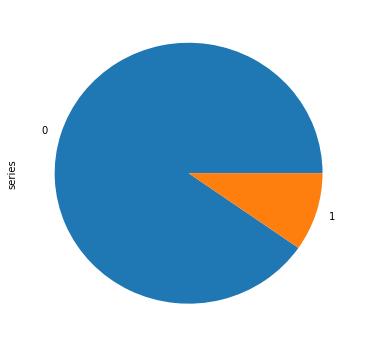

-----------------------------------------    p62   -----------------------------------------
二值比例: 3.2182255799959885         为0的数量：  48134         为1的数量：  14956


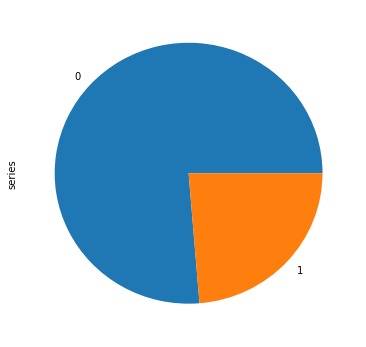

-----------------------------------------    p63   -----------------------------------------
二值比例: 4.273046385290431         为0的数量：  51126         为1的数量：  11964


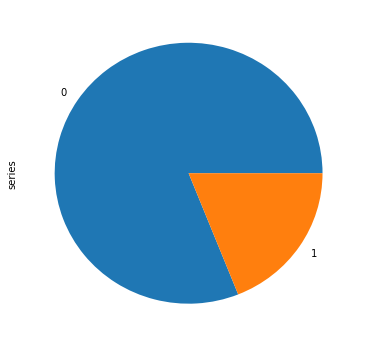

-----------------------------------------    p64   -----------------------------------------
二值比例: 39.54755784061697         为0的数量：  61535         为1的数量：  1555


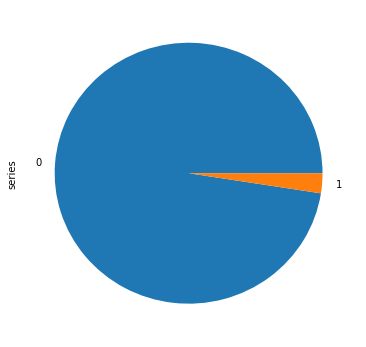

-----------------------------------------    p65   -----------------------------------------
二值比例: 62.92299898682877         为0的数量：  62104         为1的数量：  986


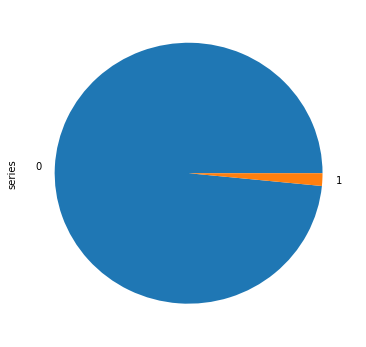

In [8]:
for col in [ 'p' + str(i) for i in range(66)]:
    print('-----------------------------------------    '+col+'   -----------------------------------------')
    print('二值比例:',((len(profiles[profiles[col]==0])+1)/(len(profiles[profiles[col]==1])+1)),end=' ')
    print('        为0的数量： ',(len(profiles[profiles[col]==0])),end=' ')
    print('        为1的数量： ',(len(profiles[profiles[col]==1])))
    
    series = pd.Series([len(profiles[profiles[col]==0]),len(profiles[profiles[col]==1])], index=['0', '1'], name='series')
    series.plot.pie(figsize=(6, 6))
    plt.show()
    

由于本身就是one-hot过的编码信息，所以这里很难去做进一步的提取，最佳的方式就是使用SVD做压缩编码来衡量不同profile方式的相似性。

可以发现在 有大量全为0的，这也很正常，表示one-hot上的稀疏性吧。

## 训练集 - 业务请求表

In [9]:
train_queries.head()

sid       pid            req_time             o             d
0  3000821       NaN 2018-11-02 17:54:30  116.29,39.97  116.32,39.96
1  3085857  210736.0 2018-11-16 10:53:10  116.39,39.84  116.33,39.79
2  2944522       NaN 2018-10-06 10:33:58  116.31,39.93  116.27,40.00
3   559931  202427.0 2018-11-23 14:54:11  116.27,39.88  116.39,39.90
4  2819352  172251.0 2018-10-30 11:48:41  116.34,39.96  116.37,39.86

In [10]:
train_queries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 5 columns):
sid         500000 non-null int64
pid         336021 non-null float64
req_time    500000 non-null datetime64[ns]
o           500000 non-null object
d           500000 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 19.1+ MB


可以发现：
     
     *在pid中有将近 163979个pid的缺失，这个可以想办法进行补充.
     *sid是唯一且无缺失的

In [11]:
for feature in train_queries.columns:
    uniq_num = len(train_queries[feature].unique())
    print("Feature(%s) ----- count(%d)" % (feature, uniq_num))

Feature(sid) ----- count(500000)
Feature(pid) ----- count(46192)
Feature(req_time) ----- count(464211)
Feature(o) ----- count(5460)
Feature(d) ----- count(4923)


可以发现：
  
     *pid是存在多次使用的情况的，每一类人可能在这几个月多次发生了导航请求事件
     *请求时间也不是唯一的，有相同时间发生的，但是时间意义不大吧。
     *存在相同起点  或者相同终点的情况，地标可能多次被使用吧。

In [12]:
#pid的缺失比例    （将近三分之一的缺失）
336021/500000

0.672042

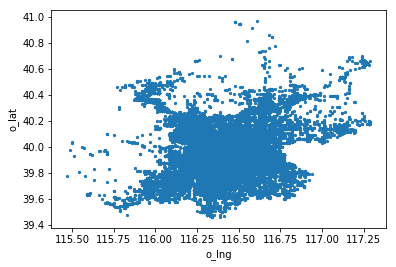

In [50]:
train_queries['o_lng'] = train_queries['o'].apply(lambda x: float(x.split(',')[0]))
train_queries['o_lat'] = train_queries['o'].apply(lambda x: float(x.split(',')[1]))
train_queries['d_lng'] = train_queries['d'].apply(lambda x: float(x.split(',')[0]))
train_queries['d_lat'] = train_queries['d'].apply(lambda x: float(x.split(',')[1])) 



train_queries.plot.scatter(x='o_lng', y='o_lat',marker='.')
plt.show()

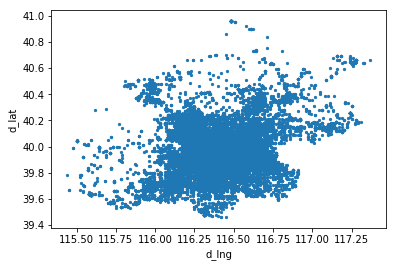

In [51]:
#请求的终点坐标分布
train_queries.plot.scatter(x='d_lng', y='d_lat',marker='.')

plt.show()

116.37,39.86    5993
116.32,39.89    5930
116.42,39.90    5819
116.41,39.91    5616
116.37,39.91    5246
116.40,39.91    5156
116.39,39.90    4366
116.35,39.94    3674
116.41,39.90    3048
116.39,39.91    3048
Name: o, dtype: int64


<Figure size 5760x5760 with 0 Axes>

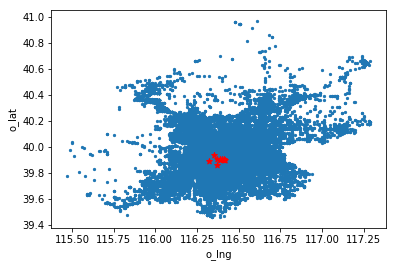

In [60]:
#找到出现次数比较多的 起点坐标     并在坐标图中绘制出来
print(train_queries['o'].value_counts()[:10])

plt.figure(figsize=(80, 80))
train_queries.plot.scatter(x='o_lng', y='o_lat',marker='.')
plt.scatter(116.37,39.86,marker='*',c='red')
plt.scatter(116.32,39.89,marker='*',c='red')
plt.scatter(116.42,39.90,marker='*',c='red')
plt.scatter(116.41,39.91,marker='*',c='red')
plt.scatter(116.37,39.91,marker='*',c='red')
plt.scatter(116.40,39.91,marker='*',c='red')
plt.scatter(116.39,39.90,marker='*',c='red')
plt.scatter(116.35,39.94,marker='*',c='red')
plt.scatter(116.41,39.90,marker='*',c='red')
plt.scatter(116.39,39.91,marker='*',c='red')
plt.show()

<Figure size 5760x5760 with 0 Axes>

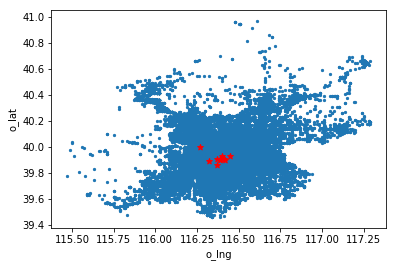

In [61]:
#找到出现次数比较多的 终点坐标
train_queries['d'].value_counts()[:10]

plt.figure(figsize=(80, 80))
train_queries.plot.scatter(x='o_lng', y='o_lat',marker='.')
plt.scatter(116.32,39.89,marker='*',c='red')
plt.scatter(116.37,39.86,marker='*',c='red')
plt.scatter(116.42,39.90,marker='*',c='red')
plt.scatter(116.39,39.90,marker='*',c='red')
plt.scatter(116.39,39.91,marker='*',c='red')
plt.scatter(116.41,39.91,marker='*',c='red')
plt.scatter(116.37,39.91,marker='*',c='red')
plt.scatter(116.45,39.93,marker='*',c='red')
plt.scatter(116.27,40.00,marker='*',c='red')
plt.scatter(116.40,39.93,marker='*',c='red')
plt.show()

In [62]:
print(1)

1


In [17]:
#打印训练表的时间范围和   测试表的时间范围

print(np.min(train_queries['req_time']))
print(np.max(train_queries['req_time']))

#顺带打印下测试集的时间范围  最大和最小
print(np.min(test_queries['req_time']))
print(np.max(test_queries['req_time']))

2018-10-01 00:00:10
2018-11-30 23:59:17
2018-12-01 00:00:10
2018-12-07 23:59:31


#s

## 训练集 - plans表

In [63]:
print(train_plans.head())

       sid           plan_time  \
0  1709112 2018-11-04 11:45:04   
1  3327773 2018-10-16 19:09:29   
2  3285959 2018-11-25 15:05:22   
3  1616170 2018-10-03 14:42:40   
4   351369 2018-10-05 19:52:37   

                                               plans  
0  [{"distance": 32303, "price": 600, "eta": 5087...  
1  [{"distance": 3427, "price": 300, "eta": 627, ...  
2  [{"distance": 36234, "price": 1100, "eta": 931...  
3  [{"distance": 11450, "price": 400, "eta": 2801...  
4  [{"distance": 18495, "price": 600, "eta": 4271...  


In [76]:
train_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491054 entries, 0 to 491053
Data columns (total 4 columns):
sid           491054 non-null int64
plan_time     491054 non-null datetime64[ns]
plans         491054 non-null object
plans_json    491054 non-null object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 15.0+ MB


In [77]:
print(train_plans[train_plans['plans']=='[]'])

Empty DataFrame
Columns: [sid, plan_time, plans, plans_json]
Index: []


每次session都会有plan请求，而且不为空

In [68]:
# plans=train_plans['plans']
train_plans['plans_json'] = train_plans['plans'].fillna('[]').apply(lambda x: json.loads(x))
print(train_plans['plans_json'])

0         [{'distance': 32303, 'price': 600, 'eta': 5087...
1         [{'distance': 3427, 'price': 300, 'eta': 627, ...
2         [{'distance': 36234, 'price': 1100, 'eta': 931...
3         [{'distance': 11450, 'price': 400, 'eta': 2801...
4         [{'distance': 18495, 'price': 600, 'eta': 4271...
5         [{'distance': 32486, 'price': '', 'eta': 2491,...
6         [{'distance': 4935, 'price': 300, 'eta': 1568,...
7         [{'distance': 22103, 'price': 500, 'eta': 3361...
8         [{'distance': 12422, 'price': 400, 'eta': 2324...
9         [{'distance': 2162, 'price': 200, 'eta': 1239,...
10        [{'distance': 30788, 'price': 600, 'eta': 4979...
11        [{'distance': 8693, 'price': 400, 'eta': 2577,...
12        [{'distance': 27279, 'price': 800, 'eta': 5528...
13        [{'distance': 1833, 'price': '', 'eta': 1648, ...
14        [{'distance': 3522, 'price': 200, 'eta': 1827,...
15        [{'distance': 23792, 'price': 600, 'eta': 6632...
16        [{'distance': 36450, 'price': 

In [82]:
#对每个plan数据进行详细展示
for index,plan in enumerate(train_plans['plans_json'].values):
    one_plan_describe='本次plan内的数据：'
    for tem_dist in plan:
        one_plan_describe=one_plan_describe+'\n   distance:'+str(tem_dist['distance'])+'   price:'+str(tem_dist['price'])+'   eta:'+str(tem_dist['eta'])+'   transport_mode:'+str(tem_dist['transport_mode'])+'   '
    print(one_plan_describe)    

本次plan内的数据：
   distance:32303   price:600   eta:5087   transport_mode:9   
   distance:33678   price:   eta:3149   transport_mode:3   
   distance:33678   price:10000   eta:3269   transport_mode:4   
   distance:32099   price:600   eta:5996   transport_mode:2   
   distance:30446   price:900   eta:6494   transport_mode:1   
本次plan内的数据：
   distance:3427   price:300   eta:627   transport_mode:2   
   distance:3251   price:   eta:573   transport_mode:3   
   distance:3251   price:1600   eta:693   transport_mode:4   
   distance:3227   price:   eta:977   transport_mode:6   
   distance:3227   price:   eta:2936   transport_mode:5   
本次plan内的数据：
   distance:36234   price:1100   eta:9318   transport_mode:7   
   distance:29545   price:   eta:3843   transport_mode:3   
   distance:29545   price:9100   eta:4143   transport_mode:4   
   distance:33295   price:900   eta:10577   transport_mode:1   
本次plan内的数据：
   distance:11450   price:400   eta:2801   transport_mode:2   
   distance:9100   price:

   distance:19615   price:600   eta:4419   transport_mode:7   
本次plan内的数据：
   distance:32081   price:600   eta:5073   transport_mode:2   
   distance:29864   price:   eta:3750   transport_mode:3   
   distance:29864   price:8500   eta:3990   transport_mode:4   
   distance:29813   price:2700   eta:4271   transport_mode:10   
   distance:32081   price:600   eta:4502   transport_mode:9   
本次plan内的数据：
   distance:1891   price:300   eta:1028   transport_mode:2   
   distance:1564   price:   eta:470   transport_mode:6   
   distance:2535   price:   eta:760   transport_mode:3   
   distance:2535   price:1300   eta:880   transport_mode:4   
   distance:1490   price:   eta:1355   transport_mode:5   
本次plan内的数据：
   distance:13756   price:4200   eta:1356   transport_mode:4   
   distance:13756   price:   eta:1056   transport_mode:3   
   distance:21444   price:500   eta:3718   transport_mode:9   
   distance:14032   price:1100   eta:3997   transport_mode:1   
   distance:21609   price:700   eta:

   distance:6330   price:200   eta:2270   transport_mode:1   
本次plan内的数据：
   distance:27077   price:600   eta:3363   transport_mode:2   
   distance:22697   price:   eta:3854   transport_mode:3   
   distance:22697   price:9000   eta:4034   transport_mode:4   
本次plan内的数据：
   distance:17664   price:600   eta:5016   transport_mode:7   
   distance:1   price:   eta:1   transport_mode:3   
   distance:1   price:5100   eta:120   transport_mode:4   
   distance:26483   price:2400   eta:4123   transport_mode:10   
本次plan内的数据：
   distance:15287   price:500   eta:2424   transport_mode:9   
   distance:17360   price:   eta:1759   transport_mode:3   
   distance:17360   price:5000   eta:1999   transport_mode:4   
   distance:16427   price:2000   eta:2640   transport_mode:10   
   distance:15105   price:500   eta:2683   transport_mode:2   
本次plan内的数据：
   distance:579   price:   eta:494   transport_mode:5   
   distance:594   price:   eta:177   transport_mode:6   
   distance:2815   price:   eta:55

   distance:14922   price:700   eta:3508   transport_mode:7   
本次plan内的数据：
   distance:2604   price:200   eta:1630   transport_mode:1   
   distance:2273   price:   eta:685   transport_mode:6   
   distance:3139   price:   eta:1227   transport_mode:3   
   distance:3139   price:1300   eta:1407   transport_mode:4   
   distance:2273   price:   eta:2087   transport_mode:5   
本次plan内的数据：
   distance:15063   price:500   eta:3558   transport_mode:7   
   distance:12316   price:   eta:1095   transport_mode:3   
   distance:12316   price:3900   eta:1275   transport_mode:4   
   distance:16221   price:500   eta:3661   transport_mode:9   
   distance:12954   price:500   eta:4177   transport_mode:1   
本次plan内的数据：
   distance:330   price:   eta:312   transport_mode:5   
   distance:338   price:   eta:101   transport_mode:6   
   distance:2708   price:   eta:749   transport_mode:3   
   distance:731   price:200   eta:786   transport_mode:1   
本次plan内的数据：
   distance:1289   price:   eta:1182   tran

   distance:9922   price:400   eta:3762   transport_mode:1   
本次plan内的数据：
   distance:172   price:   eta:147   transport_mode:5   
   distance:172   price:   eta:52   transport_mode:6   
   distance:699   price:   eta:171   transport_mode:3   
本次plan内的数据：
   distance:10159   price:600   eta:3175   transport_mode:7   
   distance:10143   price:   eta:1870   transport_mode:3   
   distance:10143   price:4000   eta:1870   transport_mode:4   
   distance:9324   price:   eta:2814   transport_mode:6   
   distance:10454   price:200   eta:4217   transport_mode:1   
本次plan内的数据：
   distance:25705   price:600   eta:4319   transport_mode:9   
   distance:21509   price:   eta:3602   transport_mode:3   
   distance:21509   price:6100   eta:3782   transport_mode:4   
   distance:25285   price:600   eta:4415   transport_mode:2   
   distance:24031   price:700   eta:7267   transport_mode:1   
本次plan内的数据：
   distance:27055   price:600   eta:5047   transport_mode:9   
   distance:32175   price:   eta:33

   distance:21211   price:600   eta:3873   transport_mode:1   
本次plan内的数据：
   distance:8847   price:400   eta:2002   transport_mode:2   
   distance:10506   price:   eta:1181   transport_mode:3   
   distance:10506   price:2400   eta:1421   transport_mode:4   
   distance:6881   price:   eta:2080   transport_mode:6   
   distance:9127   price:400   eta:2329   transport_mode:9   
   distance:10183   price:400   eta:2725   transport_mode:1   
本次plan内的数据：
   distance:19454   price:500   eta:3588   transport_mode:9   
   distance:18275   price:   eta:2113   transport_mode:3   
   distance:18275   price:4800   eta:2293   transport_mode:4   
   distance:19444   price:500   eta:4269   transport_mode:2   
   distance:18949   price:700   eta:4991   transport_mode:7   
本次plan内的数据：
   distance:19679   price:400   eta:4040   transport_mode:2   
   distance:11305   price:   eta:2997   transport_mode:3   
   distance:11305   price:5300   eta:2997   transport_mode:4   
   distance:13466   price:2000 

   distance:7970   price:400   eta:3153   transport_mode:1   
本次plan内的数据：
   distance:36450   price:   eta:2579   transport_mode:3   
   distance:36450   price:11300   eta:2759   transport_mode:4   
   distance:33297   price:1000   eta:6202   transport_mode:11   
   distance:37631   price:900   eta:7024   transport_mode:1   
   distance:36003   price:700   eta:7954   transport_mode:1   
本次plan内的数据：
   distance:23385   price:500   eta:4769   transport_mode:9   
   distance:16939   price:   eta:2368   transport_mode:3   
   distance:16939   price:4900   eta:2608   transport_mode:4   
   distance:19995   price:700   eta:5366   transport_mode:7   
   distance:15152   price:300   eta:5481   transport_mode:1   
本次plan内的数据：
   distance:24326   price:600   eta:3367   transport_mode:2   
   distance:21886   price:   eta:2656   transport_mode:3   
   distance:21886   price:7400   eta:2896   transport_mode:4   
   distance:22420   price:600   eta:5012   transport_mode:1   
本次plan内的数据：
   distance

   distance:21170   price:600   eta:5676   transport_mode:1   
本次plan内的数据：
   distance:10778   price:300   eta:3003   transport_mode:1   
   distance:8987   price:   eta:1392   transport_mode:3   
   distance:8987   price:3400   eta:1572   transport_mode:4   
   distance:7597   price:   eta:2297   transport_mode:6   
本次plan内的数据：
   distance:11442   price:400   eta:2944   transport_mode:2   
   distance:10084   price:   eta:1798   transport_mode:3   
   distance:10084   price:3300   eta:1918   transport_mode:4   
   distance:8302   price:   eta:2506   transport_mode:6   
   distance:8652   price:200   eta:3959   transport_mode:1   
本次plan内的数据：
   distance:19605   price:400   eta:6107   transport_mode:1   
   distance:12525   price:   eta:687   transport_mode:3   
本次plan内的数据：
   distance:29974   price:   eta:2320   transport_mode:3   
   distance:29974   price:8000   eta:2440   transport_mode:4   
   distance:27456   price:600   eta:5775   transport_mode:1   
本次plan内的数据：
   distance:3980

   distance:1495   price:   eta:1280   transport_mode:5   
本次plan内的数据：
   distance:42355   price:   eta:4205   transport_mode:3   
   distance:42355   price:12600   eta:4385   transport_mode:4   
   distance:42658   price:900   eta:7676   transport_mode:7   
本次plan内的数据：
   distance:15603   price:500   eta:2430   transport_mode:2   
   distance:18532   price:   eta:2620   transport_mode:3   
   distance:18532   price:5600   eta:2740   transport_mode:4   
   distance:16067   price:600   eta:3076   transport_mode:7   
   distance:16608   price:500   eta:3189   transport_mode:9   
本次plan内的数据：
   distance:35127   price:900   eta:5381   transport_mode:7   
   distance:35991   price:   eta:4085   transport_mode:3   
   distance:35991   price:10000   eta:4085   transport_mode:4   
   distance:38829   price:4200   eta:5515   transport_mode:10   
本次plan内的数据：
   distance:8879   price:400   eta:2667   transport_mode:9   
   distance:8409   price:   eta:2194   transport_mode:3   
   distance:8409  

   distance:4193   price:   eta:3621   transport_mode:5   
本次plan内的数据：
   distance:26148   price:600   eta:4266   transport_mode:9   
   distance:26355   price:   eta:2224   transport_mode:3   
   distance:26355   price:6800   eta:2464   transport_mode:4   
   distance:26831   price:800   eta:4878   transport_mode:7   
   distance:39877   price:800   eta:6027   transport_mode:7   
本次plan内的数据：
   distance:9874   price:400   eta:1664   transport_mode:2   
   distance:9938   price:   eta:2195   transport_mode:3   
   distance:9366   price:   eta:2833   transport_mode:6   
本次plan内的数据：
   distance:14578   price:300   eta:4375   transport_mode:1   
   distance:15680   price:   eta:1885   transport_mode:3   
   distance:15680   price:5200   eta:2125   transport_mode:4   
   distance:16550   price:400   eta:5458   transport_mode:1   
本次plan内的数据：
   distance:10570   price:400   eta:2123   transport_mode:2   
   distance:9370   price:   eta:1601   transport_mode:3   
   distance:9370   price:350

   distance:12282   price:400   eta:3276   transport_mode:2   
本次plan内的数据：
   distance:14961   price:500   eta:3340   transport_mode:2   
   distance:15276   price:500   eta:2707   transport_mode:9   
   distance:14789   price:   eta:3729   transport_mode:3   
   distance:14789   price:7500   eta:3909   transport_mode:4   
   distance:12883   price:400   eta:5259   transport_mode:1   
本次plan内的数据：
   distance:18798   price:500   eta:3204   transport_mode:9   
   distance:19705   price:   eta:3299   transport_mode:3   
   distance:22412   price:2500   eta:3359   transport_mode:10   
   distance:19705   price:4600   eta:3539   transport_mode:4   
   distance:19129   price:700   eta:3787   transport_mode:7   
   distance:16905   price:400   eta:5500   transport_mode:1   
本次plan内的数据：
   distance:254   price:   eta:216   transport_mode:5   
   distance:254   price:   eta:76   transport_mode:6   
   distance:1991   price:   eta:926   transport_mode:3   
本次plan内的数据：
   distance:25995   price:7

   distance:2597   price:   eta:2354   transport_mode:5   
本次plan内的数据：
   distance:21444   price:500   eta:3725   transport_mode:2   
   distance:14274   price:   eta:2247   transport_mode:3   
   distance:14274   price:4300   eta:2487   transport_mode:4   
   distance:8991   price:   eta:2716   transport_mode:6   
   distance:12916   price:300   eta:4129   transport_mode:1   
本次plan内的数据：
   distance:707   price:   eta:605   transport_mode:5   
   distance:707   price:   eta:212   transport_mode:6   
   distance:817   price:   eta:259   transport_mode:3   
本次plan内的数据：
   distance:32372   price:600   eta:4537   transport_mode:2   
   distance:20285   price:   eta:2150   transport_mode:3   
   distance:20285   price:5300   eta:2270   transport_mode:4   
   distance:32312   price:3000   eta:4220   transport_mode:10   
   distance:30116   price:800   eta:4747   transport_mode:11   
   distance:20585   price:600   eta:5426   transport_mode:1   
本次plan内的数据：
   distance:49872   price:700   et

   distance:26542   price:600   eta:4604   transport_mode:9   
本次plan内的数据：
   distance:39624   price:900   eta:5959   transport_mode:7   
   distance:40122   price:   eta:5354   transport_mode:3   
   distance:45767   price:2000   eta:5473   transport_mode:10   
   distance:40122   price:15400   eta:5654   transport_mode:4   
本次plan内的数据：
   distance:20287   price:500   eta:3104   transport_mode:2   
   distance:17205   price:   eta:1445   transport_mode:3   
   distance:17205   price:5200   eta:1625   transport_mode:4   
   distance:20800   price:500   eta:3108   transport_mode:9   
   distance:18034   price:700   eta:3622   transport_mode:7   
本次plan内的数据：
   distance:27107   price:800   eta:3993   transport_mode:7   
   distance:25444   price:   eta:2253   transport_mode:3   
   distance:25444   price:7100   eta:2373   transport_mode:4   
   distance:24981   price:1800   eta:2932   transport_mode:10   
本次plan内的数据：
   distance:530   price:   eta:453   transport_mode:5   
   distance:53

   distance:30200   price:700   eta:5965   transport_mode:7   
本次plan内的数据：
   distance:17851   price:300   eta:5346   transport_mode:1   
   distance:19470   price:   eta:2163   transport_mode:3   
   distance:19470   price:5400   eta:2283   transport_mode:4   
   distance:17871   price:500   eta:5887   transport_mode:1   
本次plan内的数据：
   distance:11134   price:3500   eta:1405   transport_mode:4   
   distance:11134   price:   eta:1285   transport_mode:3   
   distance:9819   price:   eta:2969   transport_mode:6   
   distance:13210   price:400   eta:4849   transport_mode:1   
本次plan内的数据：
   distance:53317   price:   eta:6118   transport_mode:3   
   distance:53317   price:16500   eta:6238   transport_mode:4   
   distance:55900   price:1400   eta:8665   transport_mode:11   
   distance:55899   price:1600   eta:9357   transport_mode:7   
   distance:59323   price:1300   eta:9845   transport_mode:7   
本次plan内的数据：
   distance:5560   price:300   eta:1398   transport_mode:2   
   distance:6

   distance:3729   price:   eta:3244   transport_mode:5   
本次plan内的数据：
   distance:213   price:   eta:202   transport_mode:5   
   distance:1606   price:   eta:607   transport_mode:3   
本次plan内的数据：
   distance:28807   price:900   eta:4712   transport_mode:7   
   distance:27907   price:   eta:2583   transport_mode:3   
   distance:27907   price:8400   eta:2883   transport_mode:4   
   distance:31009   price:700   eta:6126   transport_mode:1   
本次plan内的数据：
   distance:27834   price:800   eta:5110   transport_mode:7   
   distance:23524   price:   eta:2333   transport_mode:3   
   distance:23524   price:7000   eta:2333   transport_mode:4   
   distance:27146   price:1900   eta:4341   transport_mode:10   
   distance:25762   price:600   eta:4491   transport_mode:9   
   distance:23569   price:700   eta:6060   transport_mode:1   
本次plan内的数据：
   distance:403   price:   eta:374   transport_mode:5   
   distance:659   price:   eta:155   transport_mode:3   
   distance:720   price:   eta:216  

   distance:75780   price:1600   eta:13667   transport_mode:1   
本次plan内的数据：
   distance:1527   price:   eta:460   transport_mode:6   
   distance:4790   price:   eta:679   transport_mode:3   
   distance:4790   price:1400   eta:979   transport_mode:4   
   distance:1527   price:   eta:1337   transport_mode:5   
本次plan内的数据：
   distance:19165   price:   eta:2991   transport_mode:1   
   distance:17937   price:   eta:2102   transport_mode:3   
   distance:17937   price:7000   eta:2222   transport_mode:4   
本次plan内的数据：
   distance:11035   price:400   eta:2223   transport_mode:9   
   distance:10089   price:   eta:2152   transport_mode:3   
   distance:10089   price:3100   eta:2452   transport_mode:4   
   distance:10973   price:400   eta:2884   transport_mode:2   
   distance:11103   price:400   eta:4334   transport_mode:1   
本次plan内的数据：
   distance:10549   price:500   eta:3516   transport_mode:7   
   distance:10795   price:500   eta:3400   transport_mode:11   
   distance:9627   price:2

   distance:2095   price:200   eta:2013   transport_mode:1   
本次plan内的数据：
   distance:14816   price:700   eta:3666   transport_mode:7   
   distance:13692   price:   eta:1501   transport_mode:3   
   distance:13692   price:4300   eta:1681   transport_mode:4   
   distance:16792   price:2100   eta:2799   transport_mode:10   
   distance:13199   price:400   eta:5210   transport_mode:1   
本次plan内的数据：
   distance:32280   price:2900   eta:4192   transport_mode:2   
   distance:32465   price:   eta:3301   transport_mode:3   
   distance:32465   price:8100   eta:3601   transport_mode:4   
   distance:34886   price:3100   eta:5274   transport_mode:7   
本次plan内的数据：
   distance:27133   price:   eta:2534   transport_mode:3   
   distance:27133   price:9300   eta:2534   transport_mode:4   
   distance:31197   price:1900   eta:4070   transport_mode:10   
   distance:36862   price:800   eta:5480   transport_mode:7   
   distance:28367   price:700   eta:7188   transport_mode:1   
本次plan内的数据：
   dista

   distance:19051   price:400   eta:4929   transport_mode:1   
本次plan内的数据：
   distance:32003   price:600   eta:4004   transport_mode:2   
   distance:29365   price:   eta:2519   transport_mode:3   
   distance:29365   price:7100   eta:2759   transport_mode:4   
本次plan内的数据：
   distance:9237   price:2500   eta:1094   transport_mode:4   
   distance:9237   price:   eta:974   transport_mode:3   
   distance:8970   price:   eta:2713   transport_mode:6   
   distance:9520   price:600   eta:2871   transport_mode:7   
   distance:10553   price:600   eta:3138   transport_mode:7   
本次plan内的数据：
   distance:3233   price:300   eta:1654   transport_mode:2   
   distance:2692   price:   eta:553   transport_mode:3   
   distance:2692   price:1300   eta:733   transport_mode:4   
   distance:2138   price:   eta:1960   transport_mode:5   
本次plan内的数据：
   distance:16272   price:500   eta:3168   transport_mode:9   
   distance:11502   price:   eta:3063   transport_mode:3   
   distance:11502   price:7000   

   distance:6289   price:500   eta:1964   transport_mode:7   
本次plan内的数据：
   distance:28337   price:700   eta:6294   transport_mode:7   
   distance:27114   price:   eta:4119   transport_mode:3   
   distance:27114   price:10300   eta:4119   transport_mode:4   
   distance:25779   price:3500   eta:4403   transport_mode:10   
   distance:24903   price:600   eta:8148   transport_mode:1   
本次plan内的数据：
   distance:15431   price:1900   eta:3908   transport_mode:8   
   distance:15128   price:   eta:1659   transport_mode:3   
   distance:15128   price:3800   eta:1959   transport_mode:4   
   distance:20988   price:500   eta:4016   transport_mode:9   
   distance:20916   price:500   eta:4744   transport_mode:2   
   distance:17551   price:400   eta:5754   transport_mode:1   
本次plan内的数据：
   distance:33493   price:700   eta:4566   transport_mode:2   
   distance:34598   price:3900   eta:4396   transport_mode:10   
   distance:34316   price:   eta:4783   transport_mode:3   
   distance:34316   p

   distance:10784   price:300   eta:3457   transport_mode:1   
本次plan内的数据：
   distance:22650   price:500   eta:3539   transport_mode:9   
   distance:23904   price:   eta:2440   transport_mode:3   
   distance:23904   price:6100   eta:2740   transport_mode:4   
   distance:23435   price:1800   eta:3231   transport_mode:10   
   distance:22622   price:700   eta:4172   transport_mode:7   
   distance:22438   price:700   eta:4898   transport_mode:7   
本次plan内的数据：
   distance:1694   price:200   eta:1133   transport_mode:1   
   distance:1556   price:   eta:1382   transport_mode:5   
本次plan内的数据：
   distance:8816   price:   eta:1137   transport_mode:3   
   distance:8816   price:2900   eta:1377   transport_mode:4   
   distance:11440   price:400   eta:2503   transport_mode:9   
   distance:9410   price:   eta:2844   transport_mode:6   
   distance:14067   price:600   eta:3873   transport_mode:7   
   distance:10330   price:400   eta:3900   transport_mode:1   
本次plan内的数据：
   distance:35417   

   distance:4855   price:   eta:4459   transport_mode:5   
本次plan内的数据：
   distance:26425   price:700   eta:5760   transport_mode:7   
   distance:20640   price:   eta:1823   transport_mode:3   
   distance:20640   price:6500   eta:2003   transport_mode:4   
   distance:26770   price:700   eta:5484   transport_mode:11   
   distance:20365   price:600   eta:6011   transport_mode:1   
本次plan内的数据：
   distance:1079   price:   eta:921   transport_mode:5   
   distance:1850   price:   eta:557   transport_mode:6   
   distance:3864   price:   eta:1024   transport_mode:3   
   distance:3864   price:1300   eta:1204   transport_mode:4   
   distance:2127   price:200   eta:1726   transport_mode:1   
本次plan内的数据：
   distance:11892   price:1500   eta:2232   transport_mode:8   
   distance:12024   price:   eta:1184   transport_mode:3   
   distance:12024   price:3900   eta:1304   transport_mode:4   
   distance:11715   price:500   eta:3081   transport_mode:1   
   distance:12082   price:300   eta:3089

   distance:15717   price:500   eta:4955   transport_mode:1   
本次plan内的数据：
   distance:8408   price:300   eta:2131   transport_mode:9   
   distance:6411   price:   eta:826   transport_mode:3   
   distance:6411   price:1700   eta:946   transport_mode:4   
   distance:5695   price:   eta:1716   transport_mode:6   
   distance:8190   price:500   eta:2462   transport_mode:7   
   distance:6135   price:200   eta:2565   transport_mode:1   
本次plan内的数据：
   distance:28598   price:800   eta:4306   transport_mode:7   
   distance:20853   price:   eta:2041   transport_mode:3   
   distance:20853   price:4900   eta:2281   transport_mode:4   
   distance:27814   price:600   eta:3644   transport_mode:9   
   distance:22594   price:500   eta:5921   transport_mode:1   
本次plan内的数据：
   distance:7570   price:400   eta:1356   transport_mode:2   
   distance:6986   price:   eta:1151   transport_mode:3   
   distance:6986   price:2100   eta:1271   transport_mode:4   
本次plan内的数据：
   distance:226   price:   

   distance:30519   price:700   eta:5923   transport_mode:1   
本次plan内的数据：
   distance:539   price:   eta:461   transport_mode:5   
   distance:539   price:   eta:163   transport_mode:6   
   distance:1534   price:   eta:270   transport_mode:3   
本次plan内的数据：
   distance:37601   price:900   eta:7315   transport_mode:7   
   distance:36038   price:   eta:2508   transport_mode:3   
   distance:36038   price:9700   eta:2508   transport_mode:4   
   distance:41040   price:1000   eta:8987   transport_mode:1   
本次plan内的数据：
   distance:18601   price:2200   eta:4865   transport_mode:8   
   distance:18303   price:   eta:1987   transport_mode:3   
   distance:18303   price:7400   eta:2287   transport_mode:4   
   distance:25812   price:700   eta:4958   transport_mode:7   
   distance:19914   price:500   eta:5820   transport_mode:1   
本次plan内的数据：
   distance:23722   price:700   eta:3809   transport_mode:7   
   distance:23500   price:1800   eta:2995   transport_mode:10   
   distance:24991   pric

   distance:11712   price:5700   eta:2995   transport_mode:4   
本次plan内的数据：
   distance:10490   price:400   eta:2452   transport_mode:9   
   distance:10461   price:   eta:1261   transport_mode:3   
   distance:10461   price:2700   eta:1441   transport_mode:4   
   distance:10426   price:400   eta:2795   transport_mode:2   
   distance:10714   price:400   eta:3534   transport_mode:1   
本次plan内的数据：
   distance:13497   price:500   eta:3545   transport_mode:11   
   distance:12036   price:   eta:1483   transport_mode:3   
   distance:12036   price:2800   eta:1603   transport_mode:4   
   distance:13237   price:500   eta:3871   transport_mode:7   
   distance:12291   price:400   eta:4320   transport_mode:1   
本次plan内的数据：
   distance:20618   price:500   eta:2473   transport_mode:2   
   distance:14527   price:   eta:1347   transport_mode:3   
   distance:14527   price:4600   eta:1467   transport_mode:4   
本次plan内的数据：
   distance:11709   price:300   eta:3691   transport_mode:1   
   distance

   distance:39401   price:900   eta:7075   transport_mode:1   
本次plan内的数据：
   distance:5380   price:200   eta:2869   transport_mode:1   
   distance:5277   price:   eta:1594   transport_mode:6   
   distance:5662   price:   eta:1642   transport_mode:3   
   distance:5662   price:1900   eta:1642   transport_mode:4   
   distance:9221   price:400   eta:4810   transport_mode:1   
本次plan内的数据：
   distance:9145   price:200   eta:3369   transport_mode:1   
   distance:13601   price:   eta:1867   transport_mode:3   
   distance:13601   price:3000   eta:2047   transport_mode:4   
   distance:8524   price:   eta:2571   transport_mode:6   
   distance:17743   price:500   eta:4003   transport_mode:2   
本次plan内的数据：
   distance:23219   price:500   eta:3862   transport_mode:2   
   distance:23609   price:   eta:2494   transport_mode:3   
   distance:23609   price:6500   eta:2554   transport_mode:4   
   distance:22183   price:500   eta:3303   transport_mode:9   
   distance:22844   price:2500   eta:3

   distance:7560   price:   eta:2286   transport_mode:6   
本次plan内的数据：
   distance:23269   price:500   eta:3273   transport_mode:9   
   distance:19835   price:   eta:2318   transport_mode:3   
   distance:19835   price:5700   eta:2438   transport_mode:4   
   distance:23269   price:500   eta:3750   transport_mode:2   
   distance:25819   price:800   eta:6912   transport_mode:1   
本次plan内的数据：
   distance:7881   price:400   eta:1694   transport_mode:2   
   distance:8493   price:   eta:1260   transport_mode:3   
   distance:8493   price:2400   eta:1560   transport_mode:4   
   distance:8202   price:400   eta:1639   transport_mode:9   
   distance:8385   price:   eta:2533   transport_mode:6   
本次plan内的数据：
   distance:4426   price:1600   eta:797   transport_mode:4   
   distance:4426   price:   eta:617   transport_mode:3   
   distance:3797   price:   eta:1145   transport_mode:6   
   distance:4462   price:300   eta:1283   transport_mode:2   
   distance:4350   price:500   eta:1571   tran

   distance:70880   price:1500   eta:8266   transport_mode:7   
本次plan内的数据：
   distance:12899   price:400   eta:2629   transport_mode:2   
   distance:13123   price:   eta:1431   transport_mode:3   
   distance:13123   price:3600   eta:1671   transport_mode:4   
   distance:15849   price:1700   eta:2428   transport_mode:10   
   distance:13178   price:400   eta:3084   transport_mode:9   
本次plan内的数据：
   distance:22417   price:500   eta:3937   transport_mode:9   
   distance:18026   price:   eta:2770   transport_mode:3   
   distance:18026   price:7300   eta:3070   transport_mode:4   
   distance:17588   price:900   eta:5464   transport_mode:7   
   distance:17905   price:400   eta:6037   transport_mode:1   
本次plan内的数据：
   distance:48464   price:700   eta:5832   transport_mode:2   
   distance:50018   price:   eta:4271   transport_mode:3   
   distance:50018   price:13800   eta:4511   transport_mode:4   
   distance:53076   price:5500   eta:6240   transport_mode:10   
本次plan内的数据：
   dist

   distance:28494   price:900   eta:4817   transport_mode:7   
本次plan内的数据：
   distance:12347   price:400   eta:2521   transport_mode:9   
   distance:9941   price:   eta:1989   transport_mode:3   
   distance:9941   price:5000   eta:2109   transport_mode:4   
   distance:7450   price:   eta:2252   transport_mode:6   
   distance:12124   price:400   eta:3083   transport_mode:2   
   distance:11989   price:300   eta:5087   transport_mode:1   
本次plan内的数据：
   distance:4269   price:200   eta:1415   transport_mode:1   
   distance:4235   price:   eta:542   transport_mode:3   
   distance:4235   price:1900   eta:722   transport_mode:4   
   distance:4377   price:   eta:1322   transport_mode:6   
   distance:4027   price:   eta:3490   transport_mode:5   
本次plan内的数据：
   distance:4246   price:200   eta:2003   transport_mode:1   
   distance:3383   price:   eta:1022   transport_mode:6   
   distance:4166   price:   eta:1154   transport_mode:3   
   distance:4166   price:1700   eta:1334   transpor

   distance:1253   price:200   eta:1220   transport_mode:1   
本次plan内的数据：
   distance:24244   price:800   eta:4912   transport_mode:7   
   distance:25424   price:   eta:2921   transport_mode:3   
   distance:25424   price:8800   eta:3041   transport_mode:4   
   distance:24796   price:600   eta:4402   transport_mode:9   
   distance:25596   price:700   eta:5681   transport_mode:1   
本次plan内的数据：
   distance:44668   price:900   eta:7896   transport_mode:7   
   distance:41453   price:   eta:5119   transport_mode:3   
   distance:41453   price:13400   eta:5119   transport_mode:4   
   distance:55836   price:1100   eta:9993   transport_mode:11   
   distance:48612   price:1300   eta:12124   transport_mode:1   
本次plan内的数据：
   distance:22597   price:500   eta:4340   transport_mode:2   
   distance:14883   price:   eta:3366   transport_mode:3   
   distance:14883   price:4400   eta:3606   transport_mode:4   
   distance:14720   price:400   eta:6783   transport_mode:1   
本次plan内的数据：
   distan

   distance:11902   price:400   eta:2318   transport_mode:2   
本次plan内的数据：
   distance:83686   price:   eta:6436   transport_mode:3   
   distance:83686   price:25300   eta:6616   transport_mode:4   
   distance:112823   price:   eta:15345   transport_mode:7   
本次plan内的数据：
   distance:1358   price:   eta:1182   transport_mode:5   
   distance:2700   price:   eta:395   transport_mode:3   
   distance:1337   price:   eta:403   transport_mode:6   
   distance:2700   price:1300   eta:635   transport_mode:4   
   distance:3325   price:200   eta:2114   transport_mode:1   
本次plan内的数据：
   distance:23429   price:500   eta:5761   transport_mode:1   
   distance:22921   price:   eta:2040   transport_mode:3   
   distance:22921   price:7200   eta:2340   transport_mode:4   
本次plan内的数据：
   distance:54796   price:700   eta:6806   transport_mode:9   
   distance:55917   price:   eta:6960   transport_mode:3   
   distance:55917   price:19800   eta:7080   transport_mode:4   
   distance:66437   price:12

   distance:471   price:   eta:126   transport_mode:3   
本次plan内的数据：
   distance:4155   price:   eta:1254   transport_mode:6   
   distance:6362   price:   eta:1804   transport_mode:3   
   distance:6362   price:2200   eta:2104   transport_mode:4   
   distance:6060   price:200   eta:3354   transport_mode:1   
   distance:6895   price:400   eta:3677   transport_mode:1   
   distance:4256   price:   eta:3723   transport_mode:5   
本次plan内的数据：
   distance:54661   price:800   eta:6510   transport_mode:2   
   distance:50525   price:   eta:5529   transport_mode:3   
   distance:50525   price:19900   eta:5829   transport_mode:4   
   distance:58350   price:900   eta:9093   transport_mode:7   
本次plan内的数据：
   distance:7875   price:400   eta:1548   transport_mode:2   
   distance:7434   price:   eta:1265   transport_mode:3   
   distance:7434   price:2800   eta:1445   transport_mode:4   
本次plan内的数据：
   distance:49644   price:14900   eta:2924   transport_mode:4   
   distance:49644   price:   et

   distance:9779   price:   eta:3397   transport_mode:1   
本次plan内的数据：
   distance:3420   price:200   eta:1894   transport_mode:1   
   distance:3254   price:   eta:626   transport_mode:3   
   distance:3254   price:1500   eta:926   transport_mode:4   
   distance:3198   price:   eta:961   transport_mode:6   
   distance:3466   price:300   eta:2113   transport_mode:2   
   distance:2679   price:   eta:2383   transport_mode:5   
本次plan内的数据：
   distance:16087   price:500   eta:3306   transport_mode:2   
   distance:15015   price:4700   eta:2198   transport_mode:4   
   distance:19407   price:1800   eta:3182   transport_mode:10   
   distance:16273   price:600   eta:3840   transport_mode:7   
本次plan内的数据：
   distance:10561   price:600   eta:3464   transport_mode:7   
   distance:10077   price:   eta:1404   transport_mode:3   
   distance:10077   price:2700   eta:1584   transport_mode:4   
   distance:9128   price:   eta:2756   transport_mode:6   
   distance:10319   price:200   eta:4143   

   distance:24902   price:500   eta:4371   transport_mode:9   
本次plan内的数据：
   distance:43967   price:700   eta:4611   transport_mode:2   
   distance:48145   price:   eta:3607   transport_mode:3   
   distance:48145   price:12300   eta:3787   transport_mode:4   
   distance:41208   price:900   eta:5949   transport_mode:7   
本次plan内的数据：
   distance:8411   price:400   eta:2113   transport_mode:9   
   distance:9052   price:   eta:2199   transport_mode:3   
   distance:9052   price:5000   eta:2199   transport_mode:4   
   distance:7705   price:   eta:2331   transport_mode:6   
   distance:8209   price:400   eta:2386   transport_mode:2   
   distance:9227   price:400   eta:3529   transport_mode:1   
本次plan内的数据：
   distance:2759   price:300   eta:1194   transport_mode:2   
   distance:2724   price:   eta:675   transport_mode:3   
   distance:2715   price:   eta:821   transport_mode:6   
   distance:2724   price:1300   eta:915   transport_mode:4   
   distance:2749   price:200   eta:1693   t

   distance:29604   price:700   eta:5911   transport_mode:1   
本次plan内的数据：
   distance:44568   price:   eta:2512   transport_mode:3   
   distance:44568   price:14100   eta:2812   transport_mode:4   
   distance:50281   price:5600   eta:6087   transport_mode:10   
   distance:41001   price:900   eta:7526   transport_mode:7   
   distance:42090   price:1300   eta:8184   transport_mode:7   
本次plan内的数据：
   distance:22513   price:   eta:1918   transport_mode:3   
   distance:22513   price:6300   eta:2158   transport_mode:4   
   distance:19470   price:500   eta:3800   transport_mode:9   
   distance:25309   price:700   eta:5225   transport_mode:7   
   distance:25853   price:700   eta:5802   transport_mode:1   
本次plan内的数据：
   distance:10961   price:200   eta:3413   transport_mode:1   
   distance:11103   price:   eta:1090   transport_mode:3   
   distance:11103   price:3800   eta:1390   transport_mode:4   
   distance:16887   price:500   eta:4205   transport_mode:1   
本次plan内的数据：
   distan

   distance:42012   price:900   eta:7519   transport_mode:1   
本次plan内的数据：
   distance:16298   price:500   eta:3279   transport_mode:2   
   distance:15470   price:   eta:2120   transport_mode:3   
   distance:15470   price:5500   eta:2240   transport_mode:4   
   distance:23224   price:2100   eta:3696   transport_mode:10   
   distance:16514   price:600   eta:4897   transport_mode:7   
本次plan内的数据：
   distance:12009   price:600   eta:3431   transport_mode:7   
   distance:10843   price:   eta:2276   transport_mode:3   
   distance:10843   price:3600   eta:2576   transport_mode:4   
本次plan内的数据：
   distance:490   price:   eta:418   transport_mode:5   
   distance:499   price:   eta:117   transport_mode:3   
   distance:490   price:   eta:146   transport_mode:6   
本次plan内的数据：
   distance:38927   price:700   eta:5143   transport_mode:2   
   distance:34003   price:   eta:4676   transport_mode:3   
   distance:34003   price:13800   eta:4856   transport_mode:4   
   distance:37032   price:58

   distance:2457   price:   eta:2152   transport_mode:5   
本次plan内的数据：
   distance:3374   price:1500   eta:805   transport_mode:4   
   distance:3374   price:   eta:505   transport_mode:3   
   distance:3453   price:   eta:1042   transport_mode:6   
   distance:4078   price:200   eta:1663   transport_mode:1   
   distance:4307   price:200   eta:1870   transport_mode:1   
   distance:3325   price:   eta:2977   transport_mode:5   
本次plan内的数据：
   distance:4268   price:1400   eta:800   transport_mode:4   
   distance:4268   price:   eta:560   transport_mode:3   
   distance:3767   price:   eta:1137   transport_mode:6   
   distance:4536   price:200   eta:1848   transport_mode:1   
   distance:4136   price:300   eta:2639   transport_mode:2   
   distance:3708   price:   eta:3344   transport_mode:5   
本次plan内的数据：
   distance:17223   price:500   eta:4500   transport_mode:2   
   distance:13146   price:   eta:2162   transport_mode:3   
   distance:13146   price:3900   eta:2462   transport_mode

   distance:27055   price:700   eta:5100   transport_mode:7   
本次plan内的数据：
   distance:912   price:   eta:274   transport_mode:6   
   distance:1085   price:   eta:641   transport_mode:3   
   distance:1085   price:1300   eta:941   transport_mode:4   
   distance:1138   price:   eta:974   transport_mode:5   
   distance:1886   price:200   eta:1609   transport_mode:1   
   distance:3129   price:1500   eta:2244   transport_mode:1   
本次plan内的数据：
   distance:1825   price:1300   eta:606   transport_mode:4   
   distance:1825   price:   eta:306   transport_mode:3   
   distance:1817   price:   eta:549   transport_mode:6   
   distance:2417   price:200   eta:1536   transport_mode:1   
   distance:1807   price:   eta:1667   transport_mode:5   
本次plan内的数据：
   distance:8883   price:400   eta:2048   transport_mode:9   
   distance:10318   price:400   eta:2268   transport_mode:2   
   distance:9337   price:   eta:2328   transport_mode:3   
   distance:9337   price:4100   eta:2448   transport_mode:

   distance:20285   price:700   eta:3109   transport_mode:7   
本次plan内的数据：
   distance:36696   price:2200   eta:5573   transport_mode:1   
   distance:26074   price:   eta:1435   transport_mode:3   
   distance:29019   price:1100   eta:6128   transport_mode:1   
本次plan内的数据：
   distance:30077   price:2500   eta:3211   transport_mode:9   
   distance:21878   price:   eta:1647   transport_mode:3   
   distance:21878   price:5200   eta:1887   transport_mode:4   
   distance:29638   price:2500   eta:3336   transport_mode:2   
本次plan内的数据：
   distance:4623   price:300   eta:950   transport_mode:2   
   distance:5415   price:   eta:953   transport_mode:3   
   distance:5415   price:1600   eta:1193   transport_mode:4   
   distance:4269   price:   eta:1290   transport_mode:6   
   distance:3921   price:   eta:3509   transport_mode:5   
本次plan内的数据：
   distance:5200   price:200   eta:3432   transport_mode:1   
   distance:4454   price:   eta:1345   transport_mode:6   
   distance:5924   price:   

   distance:45900   price:1100   eta:7727   transport_mode:1   
本次plan内的数据：
   distance:68642   price:3500   eta:9287   transport_mode:7   
   distance:61674   price:   eta:5088   transport_mode:3   
   distance:65265   price:3500   eta:9373   transport_mode:7   
本次plan内的数据：
   distance:11823   price:500   eta:3470   transport_mode:7   
   distance:11357   price:   eta:1608   transport_mode:3   
   distance:11357   price:4300   eta:1908   transport_mode:4   
   distance:11220   price:1600   eta:3430   transport_mode:8   
本次plan内的数据：
   distance:4574   price:300   eta:1013   transport_mode:2   
   distance:4096   price:   eta:974   transport_mode:3   
   distance:4096   price:1700   eta:1154   transport_mode:4   
   distance:4111   price:   eta:1241   transport_mode:6   
   distance:4024   price:   eta:3695   transport_mode:5   
本次plan内的数据：
   distance:14   price:   eta:12   transport_mode:5   
   distance:18   price:   eta:3   transport_mode:3   
   distance:16   price:   eta:4   trans

   distance:17617   price:700   eta:4192   transport_mode:7   
本次plan内的数据：
   distance:13469   price:600   eta:3542   transport_mode:11   
   distance:11256   price:   eta:2212   transport_mode:3   
   distance:11256   price:4000   eta:2392   transport_mode:4   
   distance:13440   price:600   eta:3944   transport_mode:7   
   distance:11721   price:300   eta:4408   transport_mode:1   
本次plan内的数据：
   distance:21903   price:2600   eta:4099   transport_mode:10   
   distance:24780   price:   eta:3005   transport_mode:3   
   distance:24780   price:7100   eta:3305   transport_mode:4   
   distance:22500   price:700   eta:5194   transport_mode:7   
本次plan内的数据：
   distance:4274   price:200   eta:2324   transport_mode:1   
   distance:2853   price:   eta:861   transport_mode:6   
   distance:3292   price:   eta:988   transport_mode:3   
   distance:3292   price:2100   eta:1288   transport_mode:4   
   distance:4511   price:300   eta:2463   transport_mode:2   
   distance:2947   price:   eta:

   distance:19084   price:10400   eta:4827   transport_mode:4   
本次plan内的数据：
   distance:27139   price:600   eta:4204   transport_mode:2   
   distance:28421   price:   eta:3125   transport_mode:3   
   distance:28421   price:7700   eta:3245   transport_mode:4   
   distance:28824   price:700   eta:6573   transport_mode:1   
本次plan内的数据：
   distance:19343   price:500   eta:3167   transport_mode:9   
   distance:18164   price:   eta:2406   transport_mode:3   
   distance:18164   price:4900   eta:2646   transport_mode:4   
   distance:19322   price:500   eta:3616   transport_mode:2   
   distance:18757   price:700   eta:4507   transport_mode:7   
本次plan内的数据：
   distance:20926   price:1800   eta:2555   transport_mode:10   
   distance:20331   price:   eta:1851   transport_mode:3   
   distance:20331   price:6200   eta:2091   transport_mode:4   
   distance:20310   price:500   eta:2824   transport_mode:9   
   distance:21153   price:700   eta:3498   transport_mode:7   
   distance:20411   p

   distance:1782   price:200   eta:1636   transport_mode:1   
本次plan内的数据：
   distance:17678   price:700   eta:4439   transport_mode:7   
   distance:17840   price:   eta:2517   transport_mode:3   
   distance:17840   price:4700   eta:2757   transport_mode:4   
   distance:18958   price:1800   eta:3477   transport_mode:10   
   distance:18982   price:700   eta:5271   transport_mode:7   
本次plan内的数据：
   distance:38049   price:700   eta:5772   transport_mode:2   
   distance:41079   price:   eta:3755   transport_mode:3   
   distance:41079   price:13400   eta:3935   transport_mode:4   
   distance:39260   price:800   eta:8164   transport_mode:1   
本次plan内的数据：
   distance:6394   price:200   eta:3806   transport_mode:1   
   distance:4558   price:   eta:1540   transport_mode:3   
   distance:5671   price:   eta:1713   transport_mode:6   
   distance:4558   price:2000   eta:1840   transport_mode:4   
本次plan内的数据：
   distance:16584   price:400   eta:4031   transport_mode:1   
   distance:16787 

   distance:3309   price:   eta:2934   transport_mode:5   
本次plan内的数据：
   distance:48101   price:1200   eta:8956   transport_mode:7   
   distance:43685   price:   eta:4504   transport_mode:3   
   distance:43685   price:12600   eta:4624   transport_mode:4   
   distance:51513   price:1400   eta:9022   transport_mode:7   
本次plan内的数据：
   distance:110781   price:   eta:7866   transport_mode:3   
   distance:110781   price:39400   eta:8106   transport_mode:4   
   distance:112715   price:12900   eta:10395   transport_mode:8   
   distance:111244   price:2300   eta:12998   transport_mode:1   
   distance:115398   price:2500   eta:14003   transport_mode:1   
本次plan内的数据：
   distance:43796   price:1000   eta:7327   transport_mode:7   
   distance:42097   price:   eta:3199   transport_mode:3   
   distance:42097   price:14000   eta:3499   transport_mode:4   
   distance:44874   price:5400   eta:5827   transport_mode:10   
本次plan内的数据：
   distance:743   price:   eta:694   transport_mode:5   
   

   distance:199   price:   eta:88   transport_mode:3   
本次plan内的数据：
   distance:24249   price:600   eta:3835   transport_mode:2   
   distance:26762   price:   eta:4391   transport_mode:3   
   distance:26762   price:8800   eta:4571   transport_mode:4   
   distance:33763   price:4000   eta:4896   transport_mode:10   
   distance:22733   price:700   eta:5089   transport_mode:7   
本次plan内的数据：
   distance:699   price:   eta:597   transport_mode:5   
   distance:986   price:   eta:224   transport_mode:3   
   distance:764   price:   eta:230   transport_mode:6   
   distance:763   price:200   eta:1005   transport_mode:1   
本次plan内的数据：
   distance:38450   price:2900   eta:4486   transport_mode:2   
   distance:30459   price:   eta:2534   transport_mode:3   
   distance:30459   price:9300   eta:2714   transport_mode:4   
   distance:40990   price:3000   eta:4821   transport_mode:9   
   distance:38009   price:2700   eta:6220   transport_mode:7   
本次plan内的数据：
   distance:9468   price:200   et

   distance:8296   price:200   eta:3680   transport_mode:1   
本次plan内的数据：
   distance:11266   price:300   eta:3363   transport_mode:1   
   distance:11650   price:   eta:1907   transport_mode:3   
   distance:11650   price:3200   eta:2087   transport_mode:4   
   distance:14431   price:600   eta:4244   transport_mode:7   
本次plan内的数据：
   distance:2886   price:300   eta:1064   transport_mode:2   
   distance:2907   price:   eta:878   transport_mode:6   
   distance:3511   price:   eta:892   transport_mode:3   
   distance:3511   price:1300   eta:1132   transport_mode:4   
   distance:2446   price:   eta:2144   transport_mode:5   
本次plan内的数据：
   distance:30868   price:600   eta:4635   transport_mode:9   
   distance:33260   price:   eta:4673   transport_mode:3   
   distance:33260   price:11300   eta:4853   transport_mode:4   
   distance:31193   price:800   eta:5613   transport_mode:7   
   distance:35566   price:800   eta:7950   transport_mode:1   
本次plan内的数据：
   distance:7707   price:4

   distance:39251   price:3100   eta:5941   transport_mode:7   
本次plan内的数据：
   distance:4662   price:1400   eta:711   transport_mode:4   
   distance:4662   price:   eta:531   transport_mode:3   
   distance:4528   price:   eta:1369   transport_mode:6   
   distance:5658   price:200   eta:3245   transport_mode:1   
   distance:4511   price:   eta:4015   transport_mode:5   
本次plan内的数据：
   distance:11268   price:600   eta:3178   transport_mode:7   
   distance:9201   price:   eta:1515   transport_mode:3   
   distance:9201   price:2600   eta:1635   transport_mode:4   
   distance:8990   price:   eta:2717   transport_mode:6   
   distance:11267   price:600   eta:2838   transport_mode:11   
   distance:11526   price:800   eta:3519   transport_mode:7   
本次plan内的数据：
   distance:59875   price:800   eta:7836   transport_mode:9   
   distance:55754   price:   eta:4865   transport_mode:3   
   distance:55754   price:17000   eta:5105   transport_mode:4   
   distance:60465   price:800   eta:8367 

   distance:1870   price:200   eta:1591   transport_mode:1   
本次plan内的数据：
   distance:9795   price:3500   eta:1319   transport_mode:4   
   distance:9795   price:   eta:1199   transport_mode:3   
   distance:8829   price:400   eta:2339   transport_mode:2   
   distance:10370   price:200   eta:3259   transport_mode:1   
本次plan内的数据：
   distance:3792   price:300   eta:1960   transport_mode:2   
   distance:4175   price:   eta:766   transport_mode:3   
   distance:4175   price:1600   eta:886   transport_mode:4   
   distance:3056   price:   eta:922   transport_mode:6   
   distance:2663   price:   eta:2450   transport_mode:5   
   distance:4681   price:200   eta:2912   transport_mode:1   
本次plan内的数据：
   distance:8909   price:400   eta:1855   transport_mode:2   
   distance:8686   price:   eta:1748   transport_mode:3   
   distance:8686   price:3400   eta:1988   transport_mode:4   
本次plan内的数据：
   distance:25808   price:600   eta:5836   transport_mode:1   
   distance:23209   price:   eta:20

   distance:42877   price:3200   eta:5500   transport_mode:7   
本次plan内的数据：
   distance:9717   price:400   eta:2172   transport_mode:9   
   distance:8905   price:   eta:1649   transport_mode:3   
   distance:8905   price:2600   eta:1829   transport_mode:4   
   distance:6653   price:   eta:2011   transport_mode:6   
   distance:10106   price:600   eta:2776   transport_mode:7   
   distance:7033   price:400   eta:3675   transport_mode:1   
本次plan内的数据：
   distance:20809   price:500   eta:6070   transport_mode:1   
   distance:25447   price:   eta:2952   transport_mode:3   
   distance:25447   price:5600   eta:3192   transport_mode:4   
   distance:25515   price:700   eta:5434   transport_mode:11   
本次plan内的数据：
   distance:21099   price:500   eta:2795   transport_mode:2   
   distance:21585   price:   eta:2227   transport_mode:3   
   distance:21585   price:6500   eta:2527   transport_mode:4   
本次plan内的数据：
   distance:12735   price:400   eta:3316   transport_mode:2   
   distance:8449   

   distance:45371   price:900   eta:6548   transport_mode:7   
本次plan内的数据：
   distance:18526   price:500   eta:3214   transport_mode:9   
   distance:18397   price:   eta:2753   transport_mode:3   
   distance:18397   price:5200   eta:2933   transport_mode:4   
   distance:18387   price:500   eta:3692   transport_mode:2   
   distance:17787   price:500   eta:5935   transport_mode:1   
本次plan内的数据：
   distance:3245   price:1400   eta:1029   transport_mode:4   
   distance:1475   price:   eta:444   transport_mode:6   
   distance:3245   price:   eta:969   transport_mode:3   
   distance:1475   price:   eta:1282   transport_mode:5   
   distance:2566   price:200   eta:1611   transport_mode:1   
   distance:1966   price:200   eta:1796   transport_mode:1   
本次plan内的数据：
   distance:12773   price:400   eta:2493   transport_mode:2   
   distance:15017   price:   eta:1424   transport_mode:3   
   distance:15017   price:3500   eta:1604   transport_mode:4   
   distance:12791   price:400   eta:217

   distance:23640   price:11700   eta:4857   transport_mode:4   
本次plan内的数据：
   distance:21907   price:500   eta:4394   transport_mode:9   
   distance:23258   price:   eta:2915   transport_mode:3   
   distance:23258   price:9000   eta:2915   transport_mode:4   
   distance:22151   price:1800   eta:4363   transport_mode:10   
   distance:21908   price:500   eta:4650   transport_mode:2   
   distance:23699   price:500   eta:6142   transport_mode:1   
本次plan内的数据：
   distance:10495   price:400   eta:1895   transport_mode:2   
   distance:10354   price:   eta:1938   transport_mode:3   
   distance:10354   price:2900   eta:2058   transport_mode:4   
本次plan内的数据：
   distance:3346   price:300   eta:1590   transport_mode:2   
   distance:2814   price:   eta:666   transport_mode:3   
   distance:2386   price:   eta:721   transport_mode:6   
   distance:2814   price:1300   eta:906   transport_mode:4   
   distance:2953   price:200   eta:1659   transport_mode:1   
   distance:2380   price:   eta:

   distance:9313   price:600   eta:3060   transport_mode:7   
本次plan内的数据：
   distance:10315   price:200   eta:3266   transport_mode:1   
   distance:9688   price:   eta:2930   transport_mode:6   
   distance:10852   price:400   eta:4487   transport_mode:1   
本次plan内的数据：
   distance:3579   price:300   eta:1290   transport_mode:2   
   distance:2541   price:   eta:767   transport_mode:6   
   distance:4114   price:   eta:838   transport_mode:3   
   distance:4114   price:1400   eta:838   transport_mode:4   
   distance:2461   price:   eta:2199   transport_mode:5   
本次plan内的数据：
   distance:14188   price:500   eta:2797   transport_mode:2   
   distance:13235   price:   eta:1808   transport_mode:3   
   distance:13235   price:3400   eta:1928   transport_mode:4   
   distance:13531   price:500   eta:3895   transport_mode:1   
本次plan内的数据：
   distance:13195   price:3800   eta:1277   transport_mode:4   
   distance:13195   price:   eta:1157   transport_mode:3   
   distance:12471   price:300   

   distance:8289   price:200   eta:3890   transport_mode:1   
本次plan内的数据：
   distance:11888   price:400   eta:2407   transport_mode:2   
   distance:12295   price:   eta:2341   transport_mode:3   
   distance:12295   price:4900   eta:2521   transport_mode:4   
本次plan内的数据：
   distance:6618   price:2600   eta:1250   transport_mode:4   
   distance:6618   price:   eta:950   transport_mode:3   
   distance:6897   price:   eta:2086   transport_mode:6   
   distance:7702   price:200   eta:2514   transport_mode:1   
   distance:7181   price:300   eta:2748   transport_mode:2   
本次plan内的数据：
   distance:7749   price:200   eta:2495   transport_mode:1   
   distance:7733   price:   eta:1130   transport_mode:3   
   distance:7733   price:2400   eta:1250   transport_mode:4   
   distance:7591   price:   eta:2294   transport_mode:6   
本次plan内的数据：
   distance:17590   price:700   eta:4198   transport_mode:7   
   distance:20574   price:   eta:1935   transport_mode:3   
   distance:20574   price:5500   

   distance:6941   price:   eta:2100   transport_mode:6   
本次plan内的数据：
   distance:33646   price:2800   eta:3673   transport_mode:2   
   distance:25982   price:   eta:2392   transport_mode:3   
   distance:25982   price:7500   eta:2692   transport_mode:4   
   distance:28776   price:2800   eta:4577   transport_mode:7   
本次plan内的数据：
   distance:3637   price:300   eta:1728   transport_mode:2   
   distance:3626   price:   eta:869   transport_mode:3   
   distance:3142   price:   eta:947   transport_mode:6   
   distance:3626   price:2000   eta:1109   transport_mode:4   
   distance:3873   price:200   eta:2608   transport_mode:1   
   distance:2905   price:   eta:2647   transport_mode:5   
本次plan内的数据：
   distance:3266   price:300   eta:1066   transport_mode:2   
   distance:2617   price:   eta:788   transport_mode:6   
   distance:3057   price:   eta:812   transport_mode:3   
   distance:3057   price:1300   eta:932   transport_mode:4   
   distance:2972   price:200   eta:1588   transport

   distance:17212   price:600   eta:3783   transport_mode:7   
本次plan内的数据：
   distance:30807   price:5400   eta:4203   transport_mode:10   
   distance:32519   price:   eta:3074   transport_mode:3   
   distance:32519   price:9700   eta:3254   transport_mode:4   
   distance:31091   price:600   eta:4001   transport_mode:9   
   distance:31036   price:600   eta:4326   transport_mode:2   
   distance:30410   price:800   eta:4984   transport_mode:7   
本次plan内的数据：
   distance:33671   price:900   eta:5713   transport_mode:7   
   distance:31904   price:   eta:2321   transport_mode:3   
   distance:31904   price:7700   eta:2501   transport_mode:4   
   distance:32510   price:600   eta:4804   transport_mode:9   
   distance:35245   price:900   eta:6927   transport_mode:1   
本次plan内的数据：
   distance:14690   price:700   eta:3201   transport_mode:7   
   distance:13571   price:   eta:1546   transport_mode:3   
   distance:13571   price:3500   eta:1846   transport_mode:4   
   distance:14333   pri

   distance:3284   price:   eta:3000   transport_mode:5   
本次plan内的数据：
   distance:27548   price:3000   eta:3417   transport_mode:10   
   distance:30533   price:   eta:3018   transport_mode:3   
   distance:30533   price:9400   eta:3258   transport_mode:4   
   distance:28561   price:700   eta:6389   transport_mode:7   
   distance:31549   price:800   eta:6847   transport_mode:7   
本次plan内的数据：
   distance:202   price:   eta:173   transport_mode:5   
   distance:145   price:   eta:18   transport_mode:3   
   distance:202   price:   eta:61   transport_mode:6   
本次plan内的数据：
   distance:12955   price:400   eta:3223   transport_mode:2   
   distance:12547   price:   eta:2062   transport_mode:3   
   distance:12547   price:3100   eta:2242   transport_mode:4   
   distance:12150   price:400   eta:4627   transport_mode:1   
本次plan内的数据：
   distance:8361   price:400   eta:2120   transport_mode:2   
   distance:8563   price:   eta:1617   transport_mode:3   
   distance:8563   price:2500   eta:16

   distance:4670   price:   eta:4048   transport_mode:5   
本次plan内的数据：
   distance:34295   price:3200   eta:5133   transport_mode:7   
   distance:33659   price:   eta:3630   transport_mode:3   
   distance:33659   price:10300   eta:3930   transport_mode:4   
   distance:41817   price:3200   eta:6725   transport_mode:1   
本次plan内的数据：
   distance:25136   price:6200   eta:2460   transport_mode:4   
   distance:25136   price:   eta:2340   transport_mode:3   
   distance:19284   price:1800   eta:4671   transport_mode:10   
   distance:19459   price:1500   eta:4952   transport_mode:7   
   distance:19568   price:600   eta:5787   transport_mode:1   
本次plan内的数据：
   distance:47251   price:900   eta:6906   transport_mode:7   
   distance:49349   price:3800   eta:5633   transport_mode:10   
   distance:42430   price:   eta:5792   transport_mode:3   
   distance:42430   price:15600   eta:5972   transport_mode:4   
   distance:41954   price:1100   eta:7060   transport_mode:7   
本次plan内的数据：
   dist

   distance:4684   price:   eta:4351   transport_mode:5   
本次plan内的数据：
   distance:4424   price:200   eta:2095   transport_mode:1   
   distance:6535   price:   eta:1093   transport_mode:3   
   distance:6535   price:2000   eta:1213   transport_mode:4   
   distance:4790   price:   eta:1443   transport_mode:6   
   distance:4122   price:   eta:3730   transport_mode:5   
本次plan内的数据：
   distance:10299   price:400   eta:2113   transport_mode:9   
   distance:9237   price:   eta:1354   transport_mode:3   
   distance:9237   price:2900   eta:1654   transport_mode:4   
   distance:8995   price:   eta:2719   transport_mode:6   
   distance:10463   price:600   eta:2804   transport_mode:7   
   distance:10262   price:200   eta:3520   transport_mode:1   
本次plan内的数据：
   distance:2419   price:400   eta:937   transport_mode:1   
   distance:1887   price:   eta:568   transport_mode:6   
   distance:2758   price:1300   eta:913   transport_mode:4   
   distance:1827   price:   eta:1724   transport_mod

本次plan内的数据：
   distance:8138   price:400   eta:1323   transport_mode:2   
   distance:9440   price:   eta:1162   transport_mode:3   
   distance:9440   price:2200   eta:1282   transport_mode:4   
   distance:7534   price:   eta:2279   transport_mode:6   
本次plan内的数据：
   distance:5784   price:500   eta:2908   transport_mode:7   
   distance:8309   price:   eta:2351   transport_mode:3   
   distance:8309   price:3800   eta:2531   transport_mode:4   
   distance:4978   price:   eta:4383   transport_mode:5   
本次plan内的数据：
   distance:116   price:   eta:99   transport_mode:5   
   distance:116   price:   eta:34   transport_mode:6   
   distance:1603   price:   eta:648   transport_mode:3   
本次plan内的数据：
   distance:238   price:   eta:204   transport_mode:5   
   distance:3181   price:   eta:825   transport_mode:3   
本次plan内的数据：
   distance:29212   price:600   eta:4643   transport_mode:9   
   distance:28511   price:   eta:3809   transport_mode:3   
   distance:28511   price:12200   eta:3929   t

   distance:2623   price:200   eta:2025   transport_mode:1   
本次plan内的数据：
   distance:910   price:   eta:798   transport_mode:5   
   distance:2209   price:   eta:330   transport_mode:3   
   distance:1116   price:   eta:335   transport_mode:6   
   distance:1223   price:200   eta:1227   transport_mode:1   
本次plan内的数据：
   distance:17916   price:500   eta:4107   transport_mode:9   
   distance:19742   price:   eta:3074   transport_mode:3   
   distance:19742   price:5300   eta:3194   transport_mode:4   
   distance:17922   price:700   eta:4594   transport_mode:7   
   distance:20055   price:400   eta:5383   transport_mode:1   
本次plan内的数据：
   distance:9351   price:400   eta:2555   transport_mode:9   
   distance:7802   price:   eta:1602   transport_mode:3   
   distance:7802   price:2200   eta:1722   transport_mode:4   
   distance:6840   price:   eta:2066   transport_mode:6   
   distance:9018   price:400   eta:2747   transport_mode:2   
   distance:7337   price:400   eta:4135   transpo

   distance:29805   price:800   eta:4791   transport_mode:7   
本次plan内的数据：
   distance:6494   price:200   eta:2738   transport_mode:1   
   distance:7071   price:   eta:1373   transport_mode:3   
   distance:7071   price:3000   eta:1673   transport_mode:4   
   distance:5885   price:   eta:1777   transport_mode:6   
   distance:7015   price:200   eta:3003   transport_mode:1   
本次plan内的数据：
   distance:24972   price:600   eta:3186   transport_mode:2   
   distance:23950   price:   eta:2254   transport_mode:3   
   distance:23950   price:7300   eta:2374   transport_mode:4   
本次plan内的数据：
   distance:12229   price:400   eta:2347   transport_mode:2   
   distance:10817   price:   eta:1742   transport_mode:3   
   distance:10817   price:4200   eta:1862   transport_mode:4   
   distance:12770   price:600   eta:3416   transport_mode:7   
本次plan内的数据：
   distance:9292   price:200   eta:2629   transport_mode:1   
   distance:8579   price:   eta:1199   transport_mode:3   
   distance:8579   price:2

   distance:1194   price:1300   eta:415   transport_mode:4   
本次plan内的数据：
   distance:10354   price:400   eta:2070   transport_mode:2   
   distance:9996   price:1700   eta:1772   transport_mode:10   
   distance:11485   price:   eta:2262   transport_mode:3   
   distance:11485   price:3400   eta:2502   transport_mode:4   
   distance:9550   price:   eta:2888   transport_mode:6   
   distance:11256   price:600   eta:3017   transport_mode:7   
本次plan内的数据：
   distance:73   price:   eta:62   transport_mode:5   
   distance:96   price:   eta:28   transport_mode:6   
   distance:1043   price:   eta:424   transport_mode:3   
本次plan内的数据：
   distance:3144   price:   eta:949   transport_mode:6   
   distance:5488   price:   eta:1250   transport_mode:3   
   distance:5488   price:1900   eta:1490   transport_mode:4   
   distance:2993   price:   eta:2683   transport_mode:5   
   distance:5100   price:200   eta:2877   transport_mode:1   
本次plan内的数据：
   distance:35970   price:2400   eta:6046   tran

   distance:8975   price:200   eta:3267   transport_mode:1   
本次plan内的数据：
   distance:21098   price:   eta:1594   transport_mode:3   
   distance:21098   price:6300   eta:1894   transport_mode:4   
   distance:17058   price:500   eta:3124   transport_mode:9   
   distance:13297   price:300   eta:3849   transport_mode:1   
   distance:13576   price:300   eta:4817   transport_mode:1   
本次plan内的数据：
   distance:7134   price:2300   eta:1056   transport_mode:4   
   distance:7134   price:   eta:936   transport_mode:3   
   distance:5539   price:   eta:1666   transport_mode:6   
   distance:6540   price:300   eta:2490   transport_mode:2   
   distance:8904   price:200   eta:3163   transport_mode:1   
本次plan内的数据：
   distance:23284   price:500   eta:3186   transport_mode:1   
   distance:22102   price:   eta:1502   transport_mode:3   
   distance:22102   price:5200   eta:1682   transport_mode:4   
   distance:30390   price:800   eta:4270   transport_mode:7   
本次plan内的数据：
   distance:208   price

   distance:61770   price:1400   eta:7496   transport_mode:1   
本次plan内的数据：
   distance:543   price:   eta:495   transport_mode:5   
   distance:544   price:   eta:97   transport_mode:3   
   distance:543   price:   eta:164   transport_mode:6   
   distance:555   price:200   eta:894   transport_mode:1   
本次plan内的数据：
   distance:32543   price:600   eta:4320   transport_mode:2   
   distance:35747   price:   eta:3439   transport_mode:3   
   distance:35747   price:11200   eta:3679   transport_mode:4   
   distance:35864   price:1000   eta:6008   transport_mode:7   
本次plan内的数据：
   distance:11916   price:400   eta:1875   transport_mode:2   
   distance:13032   price:   eta:1934   transport_mode:3   
   distance:13032   price:4700   eta:2054   transport_mode:4   
   distance:13563   price:400   eta:2063   transport_mode:2   
本次plan内的数据：
   distance:34422   price:800   eta:6225   transport_mode:7   
   distance:31407   price:   eta:2772   transport_mode:3   
   distance:31407   price:8300   

   distance:9831   price:600   eta:2890   transport_mode:7   
本次plan内的数据：
   distance:2338   price:200   eta:1469   transport_mode:1   
   distance:2091   price:   eta:360   transport_mode:3   
   distance:2091   price:1300   eta:480   transport_mode:4   
   distance:2058   price:   eta:620   transport_mode:6   
   distance:1863   price:   eta:1704   transport_mode:5   
   distance:2547   price:200   eta:1914   transport_mode:1   
本次plan内的数据：
   distance:12859   price:300   eta:4834   transport_mode:1   
   distance:13923   price:   eta:964   transport_mode:3   
   distance:13923   price:4300   eta:1204   transport_mode:4   
本次plan内的数据：
   distance:5034   price:1700   eta:1046   transport_mode:4   
   distance:5034   price:   eta:926   transport_mode:3   
   distance:4072   price:   eta:1229   transport_mode:6   
   distance:4195   price:200   eta:2491   transport_mode:1   
   distance:5368   price:200   eta:3037   transport_mode:1   
   distance:3668   price:   eta:3211   transport_mo

   distance:12806   price:4600   eta:2067   transport_mode:4   
本次plan内的数据：
   distance:5116   price:200   eta:2535   transport_mode:1   
   distance:8625   price:   eta:1058   transport_mode:3   
   distance:8625   price:2300   eta:1298   transport_mode:4   
   distance:4500   price:   eta:1358   transport_mode:6   
   distance:4281   price:   eta:3816   transport_mode:5   
本次plan内的数据：
   distance:24445   price:500   eta:4809   transport_mode:2   
   distance:21940   price:   eta:1700   transport_mode:3   
   distance:21940   price:5900   eta:1940   transport_mode:4   
   distance:21869   price:600   eta:5794   transport_mode:1   
本次plan内的数据：
   distance:13364   price:1700   eta:2503   transport_mode:10   
   distance:11930   price:   eta:1351   transport_mode:3   
   distance:11930   price:2900   eta:1591   transport_mode:4   
   distance:12071   price:400   eta:3394   transport_mode:1   
   distance:12467   price:600   eta:3446   transport_mode:7   
本次plan内的数据：
   distance:24379   p

   distance:12310   price:300   eta:3479   transport_mode:1   
本次plan内的数据：
   distance:17071   price:500   eta:3041   transport_mode:9   
   distance:13310   price:   eta:1311   transport_mode:3   
   distance:13310   price:3700   eta:1491   transport_mode:4   
   distance:13745   price:300   eta:3258   transport_mode:1   
   distance:17071   price:500   eta:3309   transport_mode:2   
本次plan内的数据：
   distance:8631   price:600   eta:2303   transport_mode:7   
   distance:9257   price:   eta:1627   transport_mode:3   
   distance:9257   price:2900   eta:1807   transport_mode:4   
本次plan内的数据：
   distance:13634   price:1800   eta:2808   transport_mode:10   
   distance:11054   price:   eta:1223   transport_mode:3   
   distance:11054   price:3300   eta:1343   transport_mode:4   
   distance:8189   price:   eta:2474   transport_mode:6   
   distance:16654   price:400   eta:3213   transport_mode:2   
   distance:10031   price:600   eta:3427   transport_mode:7   
本次plan内的数据：
   distance:3128  

   distance:11884   price:600   eta:3118   transport_mode:7   
本次plan内的数据：
   distance:39429   price:2900   eta:4811   transport_mode:2   
   distance:29921   price:   eta:3117   transport_mode:3   
   distance:29921   price:8500   eta:3297   transport_mode:4   
   distance:37256   price:4700   eta:4290   transport_mode:10   
   distance:39739   price:2700   eta:6096   transport_mode:7   
本次plan内的数据：
   distance:39096   price:3100   eta:4854   transport_mode:7   
   distance:39001   price:2900   eta:4272   transport_mode:9   
   distance:31693   price:   eta:5538   transport_mode:3   
   distance:31693   price:13100   eta:5718   transport_mode:4   
   distance:31785   price:3000   eta:7831   transport_mode:1   
本次plan内的数据：
   distance:42146   price:900   eta:6053   transport_mode:7   
   distance:43449   price:   eta:3859   transport_mode:3   
   distance:43449   price:13900   eta:3979   transport_mode:4   
   distance:42045   price:900   eta:6673   transport_mode:11   
   distance:423

   distance:18632   price:2200   eta:4228   transport_mode:8   
本次plan内的数据：
   distance:9530   price:400   eta:2296   transport_mode:2   
   distance:8355   price:   eta:1901   transport_mode:3   
   distance:9942   price:400   eta:2362   transport_mode:9   
   distance:8130   price:   eta:2455   transport_mode:6   
本次plan内的数据：
   distance:45990   price:700   eta:4402   transport_mode:2   
   distance:33646   price:   eta:2421   transport_mode:3   
   distance:33646   price:11400   eta:2661   transport_mode:4   
   distance:46184   price:4700   eta:3788   transport_mode:10   
   distance:46597   price:900   eta:5884   transport_mode:7   
本次plan内的数据：
   distance:10397   price:3900   eta:1897   transport_mode:4   
   distance:10397   price:   eta:1717   transport_mode:3   
   distance:9168   price:   eta:2769   transport_mode:6   
   distance:13824   price:1700   eta:2780   transport_mode:10   
   distance:11441   price:400   eta:3063   transport_mode:9   
   distance:13598   price:600  

   distance:1534   price:200   eta:1407   transport_mode:1   
本次plan内的数据：
   distance:2921   price:200   eta:1972   transport_mode:1   
   distance:1614   price:   eta:487   transport_mode:6   
   distance:2490   price:   eta:672   transport_mode:3   
   distance:2490   price:1300   eta:792   transport_mode:4   
   distance:2417   price:   eta:2168   transport_mode:5   
本次plan内的数据：
   distance:12755   price:   eta:1122   transport_mode:3   
   distance:12755   price:5100   eta:1242   transport_mode:4   
   distance:15281   price:500   eta:4799   transport_mode:1   
本次plan内的数据：
   distance:50863   price:700   eta:6087   transport_mode:9   
   distance:44723   price:   eta:5648   transport_mode:3   
   distance:44723   price:14000   eta:5888   transport_mode:4   
   distance:52500   price:700   eta:6432   transport_mode:2   
   distance:44766   price:1200   eta:6562   transport_mode:7   
本次plan内的数据：
   distance:15171   price:4300   eta:1687   transport_mode:4   
   distance:15171   price

   distance:52033   price:3000   eta:9447   transport_mode:1   
本次plan内的数据：
   distance:23628   price:   eta:1581   transport_mode:3   
   distance:23628   price:6600   eta:1641   transport_mode:4   
   distance:24225   price:600   eta:6036   transport_mode:1   
   distance:23381   price:600   eta:6484   transport_mode:1   
本次plan内的数据：
   distance:15603   price:500   eta:3362   transport_mode:2   
   distance:12779   price:   eta:1757   transport_mode:3   
   distance:12779   price:4200   eta:1757   transport_mode:4   
   distance:15516   price:500   eta:2769   transport_mode:9   
   distance:11924   price:300   eta:4134   transport_mode:1   
本次plan内的数据：
   distance:418   price:   eta:387   transport_mode:5   
   distance:685   price:   eta:143   transport_mode:3   
   distance:735   price:   eta:220   transport_mode:6   
本次plan内的数据：
   distance:20196   price:500   eta:4373   transport_mode:2   
   distance:19456   price:1800   eta:3370   transport_mode:10   
   distance:19276   price:

   distance:53921   price:3200   eta:6921   transport_mode:7   
本次plan内的数据：
   distance:16572   price:500   eta:3237   transport_mode:2   
   distance:19596   price:   eta:2248   transport_mode:3   
   distance:19596   price:4700   eta:2428   transport_mode:4   
   distance:16987   price:600   eta:5755   transport_mode:1   
本次plan内的数据：
   distance:47469   price:700   eta:5624   transport_mode:2   
   distance:44723   price:   eta:3441   transport_mode:3   
   distance:44723   price:11900   eta:3621   transport_mode:4   
   distance:47168   price:5900   eta:5276   transport_mode:10   
本次plan内的数据：
   distance:24677   price:   eta:2285   transport_mode:3   
   distance:24677   price:6000   eta:2525   transport_mode:4   
   distance:3281   price:1000   eta:2944   transport_mode:1   
   distance:23613   price:500   eta:3852   transport_mode:1   
本次plan内的数据：
   distance:19606   price:700   eta:3210   transport_mode:7   
   distance:17984   price:   eta:1808   transport_mode:3   
   distance:

   distance:26519   price:600   eta:7368   transport_mode:1   
本次plan内的数据：
   distance:14328   price:1700   eta:2142   transport_mode:10   
   distance:12573   price:   eta:1174   transport_mode:3   
   distance:12573   price:4100   eta:1474   transport_mode:4   
   distance:14551   price:600   eta:4375   transport_mode:7   
   distance:12176   price:600   eta:4720   transport_mode:1   
本次plan内的数据：
   distance:40872   price:900   eta:8139   transport_mode:7   
   distance:41428   price:   eta:4491   transport_mode:3   
   distance:41428   price:13700   eta:4731   transport_mode:4   
   distance:41013   price:1000   eta:11951   transport_mode:1   
本次plan内的数据：
   distance:5707   price:200   eta:2596   transport_mode:1   
   distance:7214   price:   eta:993   transport_mode:3   
   distance:7214   price:2000   eta:1053   transport_mode:4   
   distance:5028   price:   eta:1519   transport_mode:6   
   distance:6718   price:200   eta:2791   transport_mode:1   
本次plan内的数据：
   distance:5473 

   distance:25380   price:700   eta:4713   transport_mode:7   
本次plan内的数据：
   distance:16844   price:   eta:1601   transport_mode:3   
   distance:16844   price:5200   eta:1841   transport_mode:4   
   distance:18207   price:500   eta:2977   transport_mode:9   
   distance:19264   price:1700   eta:3647   transport_mode:8   
   distance:19071   price:700   eta:3750   transport_mode:7   
   distance:18937   price:400   eta:4493   transport_mode:1   
本次plan内的数据：
   distance:16487   price:500   eta:3186   transport_mode:2   
   distance:15719   price:   eta:1310   transport_mode:3   
   distance:15719   price:3600   eta:1430   transport_mode:4   
   distance:16558   price:500   eta:3024   transport_mode:9   
   distance:16151   price:500   eta:4122   transport_mode:1   
本次plan内的数据：
   distance:17540   price:   eta:1883   transport_mode:3   
   distance:17540   price:5300   eta:1943   transport_mode:4   
   distance:26988   price:1900   eta:3772   transport_mode:10   
   distance:26307   pr

   distance:20571   price:700   eta:4322   transport_mode:7   
本次plan内的数据：
   distance:15604   price:300   eta:4068   transport_mode:1   
   distance:25604   price:   eta:2302   transport_mode:3   
   distance:25604   price:4000   eta:2482   transport_mode:4   
本次plan内的数据：
   distance:5247   price:200   eta:2179   transport_mode:1   
   distance:4826   price:   eta:658   transport_mode:3   
   distance:4826   price:2000   eta:778   transport_mode:4   
   distance:4215   price:   eta:1274   transport_mode:6   
   distance:4196   price:   eta:3763   transport_mode:5   
本次plan内的数据：
   distance:14961   price:500   eta:2981   transport_mode:2   
   distance:17502   price:   eta:2744   transport_mode:3   
   distance:17502   price:5100   eta:2924   transport_mode:4   
   distance:16700   price:2200   eta:2964   transport_mode:10   
   distance:15411   price:600   eta:5787   transport_mode:1   
本次plan内的数据：
   distance:72421   price:8700   eta:8192   transport_mode:8   
   distance:75630   pri

   distance:71143   price:1700   eta:9877   transport_mode:1   
本次plan内的数据：
   distance:56490   price:1000   eta:7592   transport_mode:7   
   distance:54692   price:   eta:5229   transport_mode:3   
   distance:54692   price:17000   eta:5349   transport_mode:4   
   distance:56626   price:800   eta:6949   transport_mode:9   
   distance:55443   price:1200   eta:8362   transport_mode:7   
本次plan内的数据：
   distance:37830   price:700   eta:5008   transport_mode:9   
   distance:39097   price:   eta:3984   transport_mode:3   
   distance:39097   price:12900   eta:4224   transport_mode:4   
   distance:37807   price:   eta:5493   transport_mode:7   
   distance:37404   price:1100   eta:8747   transport_mode:1   
本次plan内的数据：
   distance:15933   price:500   eta:2862   transport_mode:2   
   distance:15213   price:   eta:1621   transport_mode:3   
   distance:15213   price:3700   eta:1861   transport_mode:4   
   distance:18895   price:1800   eta:2743   transport_mode:10   
   distance:14779   

   distance:21477   price:700   eta:5541   transport_mode:7   
本次plan内的数据：
   distance:20046   price:500   eta:2519   transport_mode:2   
   distance:25255   price:   eta:2588   transport_mode:3   
   distance:25255   price:6700   eta:2648   transport_mode:4   
   distance:20699   price:500   eta:2657   transport_mode:2   
本次plan内的数据：
   distance:129   price:   eta:110   transport_mode:5   
   distance:268   price:   eta:80   transport_mode:6   
   distance:875   price:   eta:131   transport_mode:3   
本次plan内的数据：
   distance:17094   price:700   eta:3408   transport_mode:7   
   distance:16743   price:   eta:2428   transport_mode:3   
   distance:18662   price:1800   eta:2661   transport_mode:10   
   distance:16743   price:4600   eta:2668   transport_mode:4   
本次plan内的数据：
   distance:12536   price:400   eta:3390   transport_mode:2   
   distance:12998   price:   eta:2010   transport_mode:3   
   distance:12998   price:3400   eta:2250   transport_mode:4   
   distance:13040   price:1700

   distance:24444   price:700   eta:6728   transport_mode:1   
本次plan内的数据：
   distance:16600   price:500   eta:3302   transport_mode:2   
   distance:18891   price:   eta:2565   transport_mode:3   
   distance:18891   price:5200   eta:2745   transport_mode:4   
   distance:17047   price:500   eta:3401   transport_mode:9   
本次plan内的数据：
   distance:9249   price:400   eta:2390   transport_mode:2   
   distance:6415   price:   eta:858   transport_mode:3   
   distance:6415   price:2400   eta:1038   transport_mode:4   
   distance:6430   price:   eta:1946   transport_mode:6   
   distance:10050   price:400   eta:2330   transport_mode:9   
   distance:6396   price:400   eta:2820   transport_mode:1   
本次plan内的数据：
   distance:14223   price:500   eta:2752   transport_mode:2   
   distance:14793   price:   eta:1578   transport_mode:3   
   distance:14793   price:4100   eta:1878   transport_mode:4   
   distance:15220   price:1700   eta:2321   transport_mode:10   
   distance:14849   price:600   

   distance:23326   price:700   eta:5503   transport_mode:7   
本次plan内的数据：
   distance:22079   price:500   eta:3933   transport_mode:2   
   distance:19182   price:   eta:3469   transport_mode:3   
   distance:22167   price:500   eta:3583   transport_mode:9   
   distance:19182   price:6700   eta:3769   transport_mode:4   
   distance:19450   price:500   eta:6426   transport_mode:1   
本次plan内的数据：
   distance:40788   price:   eta:2244   transport_mode:3   
   distance:40788   price:12300   eta:2544   transport_mode:4   
   distance:53755   price:1300   eta:10060   transport_mode:1   
   distance:51777   price:1400   eta:10203   transport_mode:1   
本次plan内的数据：
   distance:22012   price:500   eta:4484   transport_mode:9   
   distance:23371   price:   eta:2940   transport_mode:3   
   distance:23371   price:9100   eta:2940   transport_mode:4   
   distance:22863   price:2200   eta:4573   transport_mode:10   
   distance:22013   price:500   eta:4740   transport_mode:2   
   distance:23804 

   distance:4328   price:   eta:3922   transport_mode:5   
本次plan内的数据：
   distance:31627   price:800   eta:5142   transport_mode:7   
   distance:29068   price:   eta:4002   transport_mode:3   
   distance:29068   price:10100   eta:4122   transport_mode:4   
   distance:31243   price:800   eta:6088   transport_mode:7   
本次plan内的数据：
   distance:88499   price:2100   eta:9692   transport_mode:7   
   distance:82382   price:   eta:5992   transport_mode:3   
   distance:82382   price:24100   eta:6112   transport_mode:4   
   distance:88284   price:2100   eta:9947   transport_mode:7   
本次plan内的数据：
   distance:10818   price:400   eta:2458   transport_mode:2   
   distance:9932   price:   eta:1183   transport_mode:3   
   distance:9932   price:3700   eta:1303   transport_mode:4   
   distance:10894   price:400   eta:2364   transport_mode:9   
   distance:9799   price:   eta:2962   transport_mode:6   
   distance:11729   price:600   eta:3252   transport_mode:7   
本次plan内的数据：
   distance:44853  

   distance:10777   price:200   eta:3412   transport_mode:1   
本次plan内的数据：
   distance:9703   price:400   eta:1721   transport_mode:2   
   distance:9385   price:   eta:1942   transport_mode:3   
   distance:9385   price:3200   eta:2182   transport_mode:4   
   distance:8433   price:   eta:2550   transport_mode:6   
本次plan内的数据：
   distance:63667   price:800   eta:7633   transport_mode:9   
   distance:61182   price:   eta:4932   transport_mode:3   
   distance:61182   price:17600   eta:5232   transport_mode:4   
   distance:63704   price:1000   eta:7973   transport_mode:7   
本次plan内的数据：
   distance:13723   price:4500   eta:1768   transport_mode:4   
   distance:13723   price:   eta:1468   transport_mode:3   
   distance:14187   price:400   eta:4527   transport_mode:1   
   distance:13810   price:400   eta:4924   transport_mode:1   
本次plan内的数据：
   distance:32418   price:600   eta:4892   transport_mode:9   
   distance:25425   price:   eta:2249   transport_mode:3   
   distance:25425   p

   distance:3810   price:   eta:3403   transport_mode:5   
本次plan内的数据：
   distance:8664   price:200   eta:3204   transport_mode:1   
   distance:8309   price:   eta:2514   transport_mode:6   
   distance:9788   price:   eta:2765   transport_mode:3   
   distance:11666   price:400   eta:2832   transport_mode:9   
   distance:9788   price:3700   eta:2885   transport_mode:4   
   distance:8819   price:500   eta:3624   transport_mode:7   
本次plan内的数据：
   distance:12920   price:800   eta:4204   transport_mode:7   
   distance:14447   price:   eta:1900   transport_mode:3   
   distance:14447   price:3600   eta:2140   transport_mode:4   
   distance:12756   price:600   eta:3624   transport_mode:11   
   distance:14143   price:400   eta:5066   transport_mode:1   
本次plan内的数据：
   distance:59503   price:   eta:3304   transport_mode:3   
   distance:59503   price:15500   eta:3604   transport_mode:4   
   distance:56018   price:2300   eta:7975   transport_mode:7   
   distance:55974   price:2300   e

   distance:11926   price:600   eta:3523   transport_mode:7   
本次plan内的数据：
   distance:19228   price:500   eta:3766   transport_mode:9   
   distance:15117   price:   eta:2675   transport_mode:3   
   distance:15117   price:4100   eta:2915   transport_mode:4   
   distance:17791   price:1000   eta:4483   transport_mode:7   
   distance:16636   price:400   eta:5741   transport_mode:1   
本次plan内的数据：
   distance:5086   price:200   eta:2468   transport_mode:1   
   distance:5113   price:   eta:1035   transport_mode:3   
   distance:5113   price:1800   eta:1275   transport_mode:4   
   distance:4890   price:   eta:1476   transport_mode:6   
   distance:7295   price:300   eta:2191   transport_mode:9   
   distance:7015   price:300   eta:2574   transport_mode:2   
   distance:4783   price:   eta:4465   transport_mode:5   
本次plan内的数据：
   distance:5904   price:500   eta:1954   transport_mode:7   
   distance:4319   price:   eta:1069   transport_mode:3   
   distance:4319   price:1900   eta:1249

   distance:1037   price:   eta:311   transport_mode:6   
本次plan内的数据：
   distance:7763   price:500   eta:2725   transport_mode:7   
   distance:8822   price:   eta:1413   transport_mode:3   
   distance:8822   price:3300   eta:1533   transport_mode:4   
   distance:7771   price:   eta:2351   transport_mode:6   
   distance:7421   price:500   eta:3178   transport_mode:7   
本次plan内的数据：
   distance:31927   price:600   eta:4237   transport_mode:2   
   distance:30167   price:   eta:3897   transport_mode:3   
   distance:30167   price:10900   eta:4077   transport_mode:4   
本次plan内的数据：
   distance:11025   price:400   eta:2994   transport_mode:2   
   distance:8639   price:   eta:2204   transport_mode:3   
   distance:8639   price:3900   eta:2324   transport_mode:4   
   distance:8459   price:   eta:2556   transport_mode:6   
   distance:14387   price:600   eta:3884   transport_mode:7   
本次plan内的数据：
   distance:53331   price:18400   eta:5116   transport_mode:4   
   distance:53331   price:   

   distance:7912   price:400   eta:3673   transport_mode:1   
本次plan内的数据：
   distance:9231   price:600   eta:2655   transport_mode:7   
   distance:9340   price:   eta:1617   transport_mode:3   
   distance:9340   price:3400   eta:1737   transport_mode:4   
   distance:9271   price:400   eta:1855   transport_mode:9   
   distance:8814   price:   eta:2665   transport_mode:6   
   distance:11744   price:300   eta:3939   transport_mode:1   
本次plan内的数据：
   distance:9088   price:400   eta:2742   transport_mode:2   
   distance:9801   price:   eta:1749   transport_mode:3   
   distance:9801   price:4100   eta:2049   transport_mode:4   
   distance:9609   price:400   eta:3872   transport_mode:1   
本次plan内的数据：
   distance:29909   price:800   eta:5636   transport_mode:7   
   distance:32815   price:   eta:2854   transport_mode:3   
   distance:32815   price:8000   eta:2974   transport_mode:4   
   distance:29865   price:800   eta:5435   transport_mode:11   
   distance:31883   price:1000   eta:

   distance:1368   price:200   eta:1322   transport_mode:1   
本次plan内的数据：
   distance:25248   price:   eta:2445   transport_mode:3   
   distance:25248   price:7700   eta:2565   transport_mode:4   
   distance:19373   price:600   eta:5687   transport_mode:1   
   distance:19790   price:400   eta:6767   transport_mode:1   
本次plan内的数据：
   distance:22787   price:   eta:3795   transport_mode:2   
   distance:22549   price:   eta:2760   transport_mode:3   
   distance:22549   price:5800   eta:2940   transport_mode:4   
   distance:23434   price:3100   eta:3884   transport_mode:10   
   distance:21603   price:700   eta:4660   transport_mode:7   
本次plan内的数据：
   distance:35655   price:800   eta:7211   transport_mode:7   
   distance:31381   price:   eta:3469   transport_mode:3   
   distance:31381   price:8600   eta:3649   transport_mode:4   
   distance:35204   price:3000   eta:4734   transport_mode:10   
   distance:35738   price:700   eta:10023   transport_mode:1   
本次plan内的数据：
   distance:

   distance:1790   price:   eta:1582   transport_mode:5   
本次plan内的数据：
   distance:15016   price:600   eta:3263   transport_mode:7   
   distance:16154   price:   eta:2048   transport_mode:3   
   distance:16154   price:4500   eta:2348   transport_mode:4   
   distance:15349   price:1700   eta:2471   transport_mode:10   
本次plan内的数据：
   distance:6219   price:300   eta:1328   transport_mode:2   
   distance:7420   price:   eta:2004   transport_mode:3   
   distance:7013   price:   eta:2118   transport_mode:6   
   distance:7420   price:3500   eta:2124   transport_mode:4   
本次plan内的数据：
   distance:13639   price:400   eta:3086   transport_mode:9   
   distance:10178   price:   eta:1821   transport_mode:3   
   distance:10178   price:3300   eta:1941   transport_mode:4   
   distance:13181   price:1700   eta:3398   transport_mode:10   
   distance:13650   price:800   eta:4131   transport_mode:7   
   distance:14257   price:500   eta:4425   transport_mode:1   
本次plan内的数据：
   distance:9720   p

   distance:33067   price:2700   eta:6063   transport_mode:1   
本次plan内的数据：
   distance:248   price:   eta:211   transport_mode:5   
   distance:248   price:   eta:74   transport_mode:6   
   distance:309   price:   eta:114   transport_mode:3   
本次plan内的数据：
   distance:28065   price:600   eta:3367   transport_mode:9   
   distance:23980   price:   eta:1816   transport_mode:3   
   distance:23980   price:5900   eta:2116   transport_mode:4   
   distance:28094   price:1900   eta:3130   transport_mode:10   
   distance:28027   price:800   eta:4026   transport_mode:7   
   distance:25165   price:700   eta:4392   transport_mode:1   
本次plan内的数据：
   distance:15440   price:500   eta:2644   transport_mode:2   
   distance:20521   price:   eta:2670   transport_mode:3   
   distance:16629   price:1700   eta:2825   transport_mode:10   
   distance:20521   price:5000   eta:2850   transport_mode:4   
   distance:14335   price:300   eta:3885   transport_mode:1   
本次plan内的数据：
   distance:79173   price

   distance:23904   price:800   eta:5811   transport_mode:1   
本次plan内的数据：
   distance:6160   price:300   eta:897   transport_mode:2   
   distance:7238   price:   eta:1534   transport_mode:3   
   distance:7238   price:2800   eta:1654   transport_mode:4   
   distance:7105   price:   eta:2147   transport_mode:6   
本次plan内的数据：
   distance:8942   price:   eta:963   transport_mode:3   
   distance:8942   price:3100   eta:963   transport_mode:4   
   distance:8604   price:   eta:2603   transport_mode:6   
   distance:12093   price:1600   eta:3398   transport_mode:8   
   distance:14562   price:500   eta:4242   transport_mode:11   
   distance:12087   price:400   eta:4248   transport_mode:1   
本次plan内的数据：
   distance:17485   price:500   eta:2865   transport_mode:2   
   distance:1   price:   eta:1   transport_mode:3   
   distance:1   price:4500   eta:240   transport_mode:4   
   distance:15480   price:600   eta:3686   transport_mode:7   
本次plan内的数据：
   distance:30401   price:600   eta:365

   distance:53694   price:1300   eta:9539   transport_mode:7   
本次plan内的数据：
   distance:3549   price:200   eta:2050   transport_mode:1   
   distance:3792   price:   eta:865   transport_mode:3   
   distance:3792   price:1300   eta:1105   transport_mode:4   
   distance:4193   price:   eta:1268   transport_mode:6   
   distance:4533   price:200   eta:2054   transport_mode:1   
   distance:4127   price:   eta:3675   transport_mode:5   
本次plan内的数据：
   distance:59243   price:3400   eta:8224   transport_mode:1   
   distance:55129   price:   eta:4916   transport_mode:3   
   distance:55129   price:17700   eta:4916   transport_mode:4   
   distance:63287   price:8000   eta:6515   transport_mode:10   
   distance:65947   price:3400   eta:8245   transport_mode:7   
本次plan内的数据：
   distance:653   price:   eta:558   transport_mode:5   
   distance:804   price:   eta:153   transport_mode:3   
   distance:777   price:   eta:234   transport_mode:6   
   distance:1275   price:200   eta:1110   transp

   distance:3107   price:   eta:2791   transport_mode:5   
本次plan内的数据：
   distance:27728   price:600   eta:4031   transport_mode:2   
   distance:29211   price:   eta:4143   transport_mode:3   
   distance:29211   price:10000   eta:4263   transport_mode:4   
本次plan内的数据：
   distance:2463   price:200   eta:1674   transport_mode:1   
   distance:2697   price:   eta:815   transport_mode:6   
   distance:4794   price:   eta:1409   transport_mode:3   
   distance:4794   price:2200   eta:1709   transport_mode:4   
   distance:3051   price:300   eta:2145   transport_mode:2   
   distance:2520   price:   eta:2246   transport_mode:5   
本次plan内的数据：
   distance:1767   price:200   eta:1376   transport_mode:1   
   distance:1847   price:   eta:556   transport_mode:6   
   distance:4021   price:   eta:1290   transport_mode:3   
   distance:4021   price:1800   eta:1470   transport_mode:4   
   distance:1726   price:   eta:1575   transport_mode:5   
本次plan内的数据：
   distance:20832   price:500   eta:3311 

   distance:78334   price:1700   eta:10525   transport_mode:1   
本次plan内的数据：
   distance:4428   price:200   eta:2021   transport_mode:1   
   distance:5539   price:200   eta:2426   transport_mode:1   
   distance:4249   price:   eta:3809   transport_mode:5   
本次plan内的数据：
   distance:19786   price:500   eta:4128   transport_mode:2   
   distance:17810   price:   eta:2679   transport_mode:3   
   distance:17810   price:5500   eta:2859   transport_mode:4   
   distance:17537   price:400   eta:6086   transport_mode:1   
本次plan内的数据：
   distance:5712   price:200   eta:2327   transport_mode:1   
   distance:5206   price:   eta:996   transport_mode:3   
   distance:5206   price:2000   eta:1116   transport_mode:4   
   distance:4869   price:   eta:1468   transport_mode:6   
   distance:5173   price:200   eta:2588   transport_mode:1   
   distance:4859   price:   eta:4319   transport_mode:5   
本次plan内的数据：
   distance:432   price:   eta:368   transport_mode:5   
   distance:486   price:   eta:85 

   distance:23500   price:800   eta:6530   transport_mode:1   
本次plan内的数据：
   distance:29998   price:   eta:3301   transport_mode:3   
   distance:29998   price:8400   eta:3541   transport_mode:4   
   distance:29640   price:3100   eta:4175   transport_mode:7   
   distance:30016   price:3100   eta:4541   transport_mode:7   
本次plan内的数据：
   distance:12163   price:400   eta:2659   transport_mode:9   
   distance:12261   price:1700   eta:2417   transport_mode:10   
   distance:11464   price:   eta:2537   transport_mode:3   
   distance:11464   price:3600   eta:2597   transport_mode:4   
   distance:12097   price:400   eta:3079   transport_mode:2   
   distance:12447   price:400   eta:4961   transport_mode:1   
本次plan内的数据：
   distance:29659   price:600   eta:3586   transport_mode:2   
   distance:30584   price:   eta:3233   transport_mode:3   
   distance:30584   price:6200   eta:3413   transport_mode:4   
   distance:31105   price:600   eta:3934   transport_mode:2   
本次plan内的数据：
   distan

   distance:3599   price:200   eta:3153   transport_mode:1   
本次plan内的数据：
   distance:43423   price:3200   eta:5109   transport_mode:10   
   distance:23137   price:   eta:2326   transport_mode:3   
   distance:23137   price:5900   eta:2626   transport_mode:4   
   distance:26759   price:700   eta:5315   transport_mode:11   
   distance:26952   price:700   eta:5425   transport_mode:7   
本次plan内的数据：
   distance:50910   price:1100   eta:8222   transport_mode:7   
   distance:53486   price:   eta:5964   transport_mode:3   
   distance:53486   price:18000   eta:6084   transport_mode:4   
   distance:49598   price:700   eta:6849   transport_mode:9   
本次plan内的数据：
   distance:458   price:   eta:391   transport_mode:5   
   distance:1686   price:   eta:434   transport_mode:3   
   distance:1656   price:   eta:497   transport_mode:6   
本次plan内的数据：
   distance:12509   price:600   eta:2876   transport_mode:7   
   distance:10178   price:   eta:1771   transport_mode:3   
   distance:10178   price:

   distance:3932   price:   eta:3628   transport_mode:5   
本次plan内的数据：
   distance:17064   price:500   eta:2970   transport_mode:2   
   distance:19795   price:   eta:2175   transport_mode:3   
   distance:19795   price:6600   eta:2415   transport_mode:4   
   distance:17150   price:500   eta:2716   transport_mode:9   
   distance:16890   price:2200   eta:2753   transport_mode:10   
本次plan内的数据：
   distance:7939   price:400   eta:1697   transport_mode:2   
   distance:10182   price:   eta:1582   transport_mode:3   
   distance:10182   price:2100   eta:1762   transport_mode:4   
本次plan内的数据：
   distance:8836   price:400   eta:2466   transport_mode:2   
   distance:7097   price:   eta:1845   transport_mode:3   
   distance:7097   price:3600   eta:2085   transport_mode:4   
   distance:7763   price:300   eta:2109   transport_mode:9   
   distance:7186   price:   eta:2166   transport_mode:6   
   distance:8201   price:500   eta:2931   transport_mode:7   
本次plan内的数据：
   distance:29970   price

   distance:12749   price:2000   eta:2243   transport_mode:10   
本次plan内的数据：
   distance:542   price:   eta:514   transport_mode:5   
   distance:544   price:   eta:163   transport_mode:6   
   distance:1515   price:   eta:372   transport_mode:3   
本次plan内的数据：
   distance:15782   price:2000   eta:2801   transport_mode:10   
   distance:15013   price:   eta:1584   transport_mode:3   
   distance:15013   price:4100   eta:1704   transport_mode:4   
   distance:13360   price:300   eta:3422   transport_mode:1   
   distance:14442   price:600   eta:3574   transport_mode:7   
本次plan内的数据：
   distance:12250   price:500   eta:3811   transport_mode:7   
   distance:12458   price:   eta:1946   transport_mode:3   
   distance:12458   price:3600   eta:2246   transport_mode:4   
   distance:15418   price:500   eta:3202   transport_mode:9   
   distance:15270   price:400   eta:5621   transport_mode:1   
本次plan内的数据：
   distance:15032   price:400   eta:2997   transport_mode:9   
   distance:14143   pric

   distance:10621   price:200   eta:3408   transport_mode:1   
本次plan内的数据：
   distance:33336   price:700   eta:4761   transport_mode:2   
   distance:33032   price:800   eta:5846   transport_mode:7   
本次plan内的数据：
   distance:7637   price:200   eta:3245   transport_mode:1   
   distance:7793   price:   eta:1756   transport_mode:3   
   distance:7793   price:3200   eta:1996   transport_mode:4   
   distance:7531   price:   eta:2278   transport_mode:6   
   distance:12925   price:400   eta:2680   transport_mode:9   
   distance:8114   price:200   eta:3968   transport_mode:1   
本次plan内的数据：
   distance:10740   price:400   eta:3449   transport_mode:2   
   distance:10193   price:   eta:1451   transport_mode:3   
   distance:10193   price:2900   eta:1691   transport_mode:4   
   distance:8260   price:   eta:2499   transport_mode:6   
   distance:11420   price:400   eta:2811   transport_mode:9   
   distance:8131   price:200   eta:3527   transport_mode:1   
本次plan内的数据：
   distance:11500   pric

   distance:52930   price:2300   eta:8852   transport_mode:1   
本次plan内的数据：
   distance:27848   price:600   eta:4653   transport_mode:2   
   distance:28101   price:   eta:2737   transport_mode:3   
   distance:28101   price:9200   eta:3037   transport_mode:4   
   distance:27270   price:700   eta:5160   transport_mode:11   
   distance:27341   price:800   eta:5511   transport_mode:7   
本次plan内的数据：
   distance:15939   price:700   eta:3329   transport_mode:9   
   distance:18139   price:   eta:2634   transport_mode:3   
   distance:18139   price:4900   eta:2934   transport_mode:4   
   distance:16451   price:1800   eta:3094   transport_mode:10   
   distance:15964   price:700   eta:4110   transport_mode:7   
本次plan内的数据：
   distance:27295   price:500   eta:4017   transport_mode:2   
   distance:24485   price:   eta:2408   transport_mode:3   
   distance:24485   price:7200   eta:2468   transport_mode:4   
   distance:21691   price:500   eta:3757   transport_mode:9   
本次plan内的数据：
   distan

   distance:6664   price:   eta:2013   transport_mode:6   
本次plan内的数据：
   distance:28227   price:600   eta:3656   transport_mode:9   
   distance:26015   price:   eta:2186   transport_mode:3   
   distance:26015   price:6400   eta:2306   transport_mode:4   
   distance:28181   price:600   eta:4107   transport_mode:2   
   distance:25650   price:500   eta:4671   transport_mode:1   
本次plan内的数据：
   distance:15460   price:500   eta:3069   transport_mode:2   
   distance:13843   price:   eta:2307   transport_mode:3   
   distance:13843   price:3800   eta:2607   transport_mode:4   
   distance:16178   price:1800   eta:2870   transport_mode:10   
   distance:15529   price:700   eta:3733   transport_mode:7   
本次plan内的数据：
   distance:10846   price:400   eta:2721   transport_mode:9   
   distance:11322   price:   eta:2855   transport_mode:3   
   distance:11954   price:400   eta:2861   transport_mode:2   
   distance:9954   price:   eta:3011   transport_mode:6   
   distance:11322   price:4900  

   distance:32358   price:600   eta:3807   transport_mode:2   
本次plan内的数据：
   distance:25603   price:700   eta:3849   transport_mode:7   
   distance:25268   price:   eta:2581   transport_mode:3   
   distance:25268   price:6400   eta:2881   transport_mode:4   
   distance:25956   price:1800   eta:3227   transport_mode:10   
本次plan内的数据：
   distance:28998   price:3000   eta:5827   transport_mode:7   
   distance:27272   price:   eta:2876   transport_mode:3   
   distance:27272   price:6900   eta:3176   transport_mode:4   
   distance:29006   price:800   eta:6122   transport_mode:1   
本次plan内的数据：
   distance:14320   price:400   eta:3047   transport_mode:9   
   distance:10227   price:   eta:2073   transport_mode:3   
   distance:10227   price:4200   eta:2193   transport_mode:4   
   distance:14500   price:1800   eta:3106   transport_mode:10   
   distance:12346   price:600   eta:3657   transport_mode:7   
   distance:10606   price:400   eta:4782   transport_mode:1   
本次plan内的数据：
   dista

   distance:27280   price:600   eta:5235   transport_mode:1   
本次plan内的数据：
   distance:37373   price:   eta:3225   transport_mode:3   
   distance:37373   price:12700   eta:3465   transport_mode:4   
   distance:37954   price:700   eta:5910   transport_mode:9   
   distance:37772   price:700   eta:6718   transport_mode:2   
   distance:37154   price:1700   eta:6747   transport_mode:7   
本次plan内的数据：
   distance:16099   price:500   eta:1968   transport_mode:2   
   distance:15227   price:   eta:1573   transport_mode:3   
   distance:15227   price:4900   eta:1753   transport_mode:4   
   distance:14559   price:300   eta:2570   transport_mode:1   
本次plan内的数据：
   distance:29242   price:700   eta:6330   transport_mode:7   
   distance:27487   price:   eta:5142   transport_mode:3   
   distance:27487   price:10500   eta:5322   transport_mode:4   
   distance:29483   price:700   eta:5964   transport_mode:11   
   distance:27349   price:800   eta:8004   transport_mode:1   
本次plan内的数据：
   distan

   distance:2699   price:   eta:2449   transport_mode:5   
本次plan内的数据：
   distance:21979   price:6900   eta:2138   transport_mode:4   
   distance:21979   price:   eta:2018   transport_mode:3   
   distance:19514   price:700   eta:4674   transport_mode:1   
   distance:22135   price:500   eta:4740   transport_mode:2   
本次plan内的数据：
   distance:9278   price:500   eta:2567   transport_mode:7   
   distance:8332   price:   eta:1572   transport_mode:3   
   distance:8332   price:2500   eta:1692   transport_mode:4   
   distance:7820   price:   eta:2363   transport_mode:6   
   distance:12742   price:400   eta:2661   transport_mode:9   
本次plan内的数据：
   distance:20113   price:500   eta:3848   transport_mode:2   
   distance:20148   price:500   eta:3155   transport_mode:9   
   distance:22130   price:   eta:3576   transport_mode:3   
   distance:22130   price:6400   eta:3576   transport_mode:4   
   distance:20585   price:700   eta:4366   transport_mode:7   
本次plan内的数据：
   distance:7479   price

   distance:25594   price:1900   eta:3918   transport_mode:10   
本次plan内的数据：
   distance:15116   price:800   eta:4100   transport_mode:7   
   distance:14065   price:   eta:2135   transport_mode:3   
   distance:14065   price:4300   eta:2375   transport_mode:4   
   distance:15118   price:600   eta:3874   transport_mode:11   
   distance:17599   price:500   eta:5570   transport_mode:1   
本次plan内的数据：
   distance:4517   price:200   eta:2317   transport_mode:1   
   distance:4188   price:   eta:744   transport_mode:3   
   distance:4188   price:1300   eta:864   transport_mode:4   
   distance:3463   price:   eta:1042   transport_mode:6   
   distance:5859   price:300   eta:2810   transport_mode:2   
   distance:3419   price:   eta:2995   transport_mode:5   
本次plan内的数据：
   distance:6164   price:1500   eta:894   transport_mode:4   
   distance:6164   price:   eta:654   transport_mode:3   
   distance:5244   price:   eta:1584   transport_mode:6   
   distance:6237   price:400   eta:2776   tr

   distance:27310   price:700   eta:6618   transport_mode:1   
本次plan内的数据：
   distance:53857   price:700   eta:6159   transport_mode:9   
   distance:44458   price:   eta:4665   transport_mode:3   
   distance:44458   price:13400   eta:4965   transport_mode:4   
   distance:53864   price:900   eta:6753   transport_mode:7   
本次plan内的数据：
   distance:5253   price:200   eta:2252   transport_mode:1   
   distance:5387   price:   eta:538   transport_mode:3   
   distance:5387   price:1300   eta:838   transport_mode:4   
   distance:4072   price:   eta:1229   transport_mode:6   
   distance:5193   price:200   eta:2342   transport_mode:1   
   distance:3930   price:   eta:3387   transport_mode:5   
本次plan内的数据：
   distance:5431   price:300   eta:1904   transport_mode:2   
   distance:5639   price:   eta:1731   transport_mode:3   
   distance:5771   price:   eta:1743   transport_mode:6   
   distance:5639   price:2000   eta:1851   transport_mode:4   
   distance:5845   price:400   eta:3781   tra

   distance:55754   price:1300   eta:8716   transport_mode:1   
本次plan内的数据：
   distance:22323   price:500   eta:3695   transport_mode:2   
   distance:21283   price:   eta:2690   transport_mode:3   
   distance:21283   price:6300   eta:2870   transport_mode:4   
   distance:31853   price:1900   eta:4320   transport_mode:10   
   distance:22385   price:800   eta:5445   transport_mode:7   
本次plan内的数据：
   distance:29497   price:600   eta:3876   transport_mode:9   
   distance:28510   price:   eta:3381   transport_mode:3   
   distance:28510   price:8700   eta:3561   transport_mode:4   
   distance:29261   price:600   eta:4340   transport_mode:2   
   distance:33699   price:900   eta:9157   transport_mode:1   
本次plan内的数据：
   distance:21071   price:700   eta:5058   transport_mode:7   
   distance:24387   price:   eta:4818   transport_mode:3   
   distance:21689   price:700   eta:4882   transport_mode:11   
   distance:24387   price:8800   eta:4998   transport_mode:4   
   distance:21028   p

   distance:9066   price:200   eta:2978   transport_mode:1   
本次plan内的数据：
   distance:25797   price:700   eta:4203   transport_mode:11   
   distance:25031   price:   eta:2098   transport_mode:3   
   distance:25031   price:7600   eta:2278   transport_mode:4   
   distance:25802   price:700   eta:4390   transport_mode:7   
   distance:23604   price:600   eta:5929   transport_mode:1   
本次plan内的数据：
   distance:4304   price:200   eta:2221   transport_mode:1   
   distance:4381   price:   eta:1324   transport_mode:6   
   distance:4259   price:   eta:1546   transport_mode:3   
   distance:4259   price:1700   eta:1846   transport_mode:4   
   distance:4511   price:300   eta:2261   transport_mode:2   
   distance:4235   price:   eta:3792   transport_mode:5   
本次plan内的数据：
   distance:4866   price:300   eta:1269   transport_mode:9   
   distance:5616   price:   eta:1191   transport_mode:3   
   distance:5616   price:1700   eta:1251   transport_mode:4   
   distance:4837   price:300   eta:1409 

   distance:21983   price:500   eta:6633   transport_mode:1   
本次plan内的数据：
   distance:11089   price:400   eta:3724   transport_mode:1   
   distance:10915   price:   eta:978   transport_mode:3   
   distance:10915   price:3500   eta:1218   transport_mode:4   
本次plan内的数据：
   distance:3442   price:200   eta:1887   transport_mode:1   
   distance:4441   price:   eta:775   transport_mode:3   
   distance:3155   price:   eta:953   transport_mode:6   
   distance:4441   price:1600   eta:1015   transport_mode:4   
   distance:2622   price:   eta:2275   transport_mode:5   
   distance:4710   price:200   eta:2438   transport_mode:1   
本次plan内的数据：
   distance:5814   price:200   eta:2731   transport_mode:1   
   distance:5749   price:   eta:914   transport_mode:3   
   distance:5749   price:3000   eta:1094   transport_mode:4   
   distance:4445   price:   eta:1345   transport_mode:6   
   distance:7338   price:500   eta:2473   transport_mode:11   
   distance:4436   price:   eta:4000   transport

   distance:45358   price:700   eta:5351   transport_mode:9   
本次plan内的数据：
   distance:8979   price:400   eta:1991   transport_mode:9   
   distance:8756   price:400   eta:2032   transport_mode:2   
   distance:8717   price:   eta:2369   transport_mode:3   
   distance:8717   price:3000   eta:2489   transport_mode:4   
   distance:8934   price:   eta:2698   transport_mode:6   
本次plan内的数据：
   distance:39228   price:900   eta:5013   transport_mode:7   
   distance:34788   price:   eta:2815   transport_mode:3   
   distance:34788   price:9200   eta:3055   transport_mode:4   
   distance:40465   price:700   eta:5139   transport_mode:9   
本次plan内的数据：
   distance:8254   price:200   eta:2522   transport_mode:1   
   distance:8699   price:   eta:805   transport_mode:3   
   distance:8699   price:2100   eta:985   transport_mode:4   
   distance:7452   price:   eta:2249   transport_mode:6   
本次plan内的数据：
   distance:11610   price:400   eta:2741   transport_mode:2   
   distance:10996   price:   e

   distance:4084   price:   eta:3778   transport_mode:5   
本次plan内的数据：
   distance:16001   price:500   eta:3519   transport_mode:9   
   distance:14536   price:   eta:2187   transport_mode:3   
   distance:14536   price:4100   eta:2367   transport_mode:4   
   distance:15219   price:600   eta:4302   transport_mode:7   
   distance:12850   price:300   eta:5188   transport_mode:1   
本次plan内的数据：
   distance:8099   price:400   eta:2186   transport_mode:9   
   distance:10923   price:   eta:1503   transport_mode:3   
   distance:10923   price:3800   eta:1743   transport_mode:4   
   distance:7727   price:   eta:2336   transport_mode:6   
   distance:8044   price:400   eta:2528   transport_mode:2   
   distance:11647   price:400   eta:2558   transport_mode:2   
本次plan内的数据：
   distance:4064   price:200   eta:2569   transport_mode:1   
   distance:3954   price:   eta:968   transport_mode:3   
   distance:3928   price:   eta:1188   transport_mode:6   
   distance:3954   price:1400   eta:1268   

   distance:2995   price:200   eta:1804   transport_mode:1   
本次plan内的数据：
   distance:5668   price:300   eta:1594   transport_mode:2   
   distance:5984   price:2100   eta:1108   transport_mode:4   
   distance:4930   price:   eta:1489   transport_mode:6   
   distance:4797   price:200   eta:2016   transport_mode:1   
   distance:4722   price:   eta:4183   transport_mode:5   
本次plan内的数据：
   distance:21952   price:1000   eta:3361   transport_mode:7   
   distance:19965   price:   eta:1850   transport_mode:3   
   distance:19965   price:5500   eta:2030   transport_mode:4   
   distance:22028   price:500   eta:2814   transport_mode:9   
   distance:21948   price:700   eta:3564   transport_mode:7   
本次plan内的数据：
   distance:6138   price:200   eta:2809   transport_mode:1   
   distance:6205   price:   eta:1623   transport_mode:3   
   distance:5639   price:   eta:1705   transport_mode:6   
   distance:6205   price:2300   eta:1803   transport_mode:4   
   distance:7566   price:300   eta:3160 

   distance:17586   price:400   eta:6373   transport_mode:1   
本次plan内的数据：
   distance:39244   price:700   eta:5285   transport_mode:2   
   distance:39355   price:700   eta:5172   transport_mode:9   
   distance:39708   price:700   eta:5481   transport_mode:2   
本次plan内的数据：
   distance:6149   price:200   eta:2364   transport_mode:1   
   distance:5662   price:   eta:1171   transport_mode:3   
   distance:5662   price:1800   eta:1291   transport_mode:4   
   distance:5646   price:   eta:1707   transport_mode:6   
   distance:6101   price:200   eta:2465   transport_mode:1   
本次plan内的数据：
   distance:16633   price:700   eta:3581   transport_mode:7   
   distance:16180   price:   eta:1565   transport_mode:3   
   distance:16180   price:5000   eta:1805   transport_mode:4   
   distance:16265   price:500   eta:3083   transport_mode:9   
   distance:21933   price:1800   eta:3275   transport_mode:10   
   distance:18415   price:400   eta:4846   transport_mode:1   
本次plan内的数据：
   distance:8838 

   distance:13133   price:500   eta:4359   transport_mode:1   
本次plan内的数据：
   distance:3449   price:200   eta:2375   transport_mode:1   
   distance:4068   price:   eta:1014   transport_mode:3   
   distance:4068   price:1400   eta:1074   transport_mode:4   
   distance:3635   price:   eta:1096   transport_mode:6   
   distance:4171   price:400   eta:3007   transport_mode:1   
   distance:3453   price:   eta:3126   transport_mode:5   
本次plan内的数据：
   distance:15158   price:500   eta:2202   transport_mode:2   
   distance:1   price:   eta:1   transport_mode:3   
   distance:1   price:4600   eta:180   transport_mode:4   
本次plan内的数据：
   distance:31393   price:800   eta:5280   transport_mode:7   
   distance:33734   price:   eta:2748   transport_mode:3   
   distance:33734   price:9100   eta:2868   transport_mode:4   
   distance:32225   price:2100   eta:4559   transport_mode:10   
本次plan内的数据：
   distance:26217   price:   eta:2468   transport_mode:3   
   distance:26217   price:8100   eta:2

   distance:4981   price:   eta:4566   transport_mode:5   
本次plan内的数据：
   distance:14398   price:500   eta:2177   transport_mode:2   
   distance:13797   price:   eta:1270   transport_mode:3   
   distance:13797   price:3700   eta:1450   transport_mode:4   
本次plan内的数据：
   distance:22977   price:500   eta:9516   transport_mode:1   
   distance:19936   price:   eta:2901   transport_mode:3   
   distance:19936   price:5900   eta:2901   transport_mode:4   
   distance:34352   price:600   eta:10940   transport_mode:1   
本次plan内的数据：
   distance:18493   price:500   eta:3326   transport_mode:9   
   distance:15186   price:   eta:2306   transport_mode:3   
   distance:15186   price:4600   eta:2546   transport_mode:4   
   distance:25646   price:2000   eta:3173   transport_mode:10   
   distance:18437   price:500   eta:3502   transport_mode:2   
   distance:24463   price:500   eta:3955   transport_mode:2   
本次plan内的数据：
   distance:25726   price:500   eta:4689   transport_mode:9   
   distance:19

   distance:40028   price:900   eta:5098   transport_mode:7   
本次plan内的数据：
   distance:15972   price:5000   eta:1990   transport_mode:4   
   distance:15972   price:   eta:1690   transport_mode:3   
   distance:16696   price:2200   eta:2646   transport_mode:10   
   distance:16408   price:500   eta:3145   transport_mode:9   
   distance:16436   price:700   eta:3620   transport_mode:7   
   distance:14121   price:400   eta:4332   transport_mode:1   
本次plan内的数据：
   distance:52834   price:900   eta:8849   transport_mode:7   
   distance:48570   price:   eta:3416   transport_mode:3   
   distance:48570   price:15700   eta:3416   transport_mode:4   
   distance:52987   price:900   eta:9414   transport_mode:7   
本次plan内的数据：
   distance:26385   price:800   eta:4429   transport_mode:7   
   distance:30197   price:   eta:3640   transport_mode:3   
   distance:30197   price:9000   eta:3760   transport_mode:4   
   distance:32826   price:2200   eta:4367   transport_mode:10   
本次plan内的数据：
   dista

   distance:26922   price:800   eta:4073   transport_mode:7   
本次plan内的数据：
   distance:4363   price:300   eta:2061   transport_mode:2   
   distance:4932   price:   eta:1136   transport_mode:3   
   distance:4932   price:2200   eta:1376   transport_mode:4   
   distance:4934   price:200   eta:2259   transport_mode:1   
   distance:3403   price:   eta:3153   transport_mode:5   
本次plan内的数据：
   distance:2083   price:200   eta:1450   transport_mode:1   
   distance:1721   price:   eta:519   transport_mode:6   
   distance:2966   price:   eta:669   transport_mode:3   
   distance:2966   price:1300   eta:909   transport_mode:4   
   distance:1676   price:   eta:1484   transport_mode:5   
   distance:2420   price:200   eta:1593   transport_mode:1   
本次plan内的数据：
   distance:10086   price:3000   eta:1717   transport_mode:4   
   distance:10086   price:   eta:1597   transport_mode:3   
   distance:8759   price:   eta:2647   transport_mode:6   
   distance:10073   price:400   eta:4576   transport

本次plan内的数据：
   distance:3393   price:200   eta:2052   transport_mode:1   
   distance:5319   price:   eta:947   transport_mode:3   
   distance:5319   price:1400   eta:1127   transport_mode:4   
   distance:3916   price:   eta:1182   transport_mode:6   
   distance:5151   price:200   eta:2753   transport_mode:1   
   distance:3535   price:   eta:3104   transport_mode:5   
本次plan内的数据：
   distance:22702   price:500   eta:3146   transport_mode:2   
   distance:22309   price:   eta:2528   transport_mode:3   
   distance:22309   price:7300   eta:2648   transport_mode:4   
   distance:22182   price:3200   eta:2695   transport_mode:10   
本次plan内的数据：
   distance:32611   price:800   eta:5022   transport_mode:7   
   distance:32129   price:600   eta:4293   transport_mode:9   
   distance:29852   price:   eta:5582   transport_mode:3   
   distance:29852   price:14400   eta:5582   transport_mode:4   
本次plan内的数据：
   distance:21911   price:500   eta:7547   transport_mode:1   
   distance:19030   pri

   distance:4439   price:   eta:3893   transport_mode:5   
本次plan内的数据：
   distance:8642   price:3400   eta:1403   transport_mode:4   
   distance:8642   price:   eta:1283   transport_mode:3   
   distance:9533   price:   eta:2877   transport_mode:6   
   distance:10604   price:600   eta:3270   transport_mode:7   
   distance:15287   price:500   eta:3335   transport_mode:9   
   distance:9757   price:400   eta:3970   transport_mode:1   
本次plan内的数据：
   distance:17188   price:500   eta:3804   transport_mode:2   
   distance:16247   price:   eta:2119   transport_mode:3   
   distance:16247   price:5200   eta:2359   transport_mode:4   
   distance:10980   price:500   eta:4101   transport_mode:7   
本次plan内的数据：
   distance:20247   price:   eta:3800   transport_mode:2   
   distance:17801   price:   eta:3200   transport_mode:3   
   distance:20204   price:500   eta:3291   transport_mode:9   
   distance:17801   price:5600   eta:3380   transport_mode:4   
   distance:14077   price:400   eta:559

   distance:25196   price:800   eta:3972   transport_mode:7   
本次plan内的数据：
   distance:11901   price:   eta:1331   transport_mode:3   
   distance:11901   price:3800   eta:1631   transport_mode:4   
   distance:12552   price:400   eta:2529   transport_mode:9   
   distance:10797   price:2100   eta:2795   transport_mode:8   
   distance:13120   price:800   eta:3426   transport_mode:7   
   distance:10573   price:400   eta:3619   transport_mode:1   
本次plan内的数据：
   distance:710   price:   eta:675   transport_mode:5   
   distance:708   price:   eta:211   transport_mode:6   
   distance:1119   price:   eta:318   transport_mode:3   
本次plan内的数据：
   distance:12236   price:400   eta:2638   transport_mode:2   
   distance:12212   price:   eta:3296   transport_mode:3   
   distance:12212   price:6300   eta:3596   transport_mode:4   
本次plan内的数据：
   distance:22952   price:600   eta:5632   transport_mode:1   
   distance:24017   price:   eta:2798   transport_mode:3   
   distance:24017   price:8100

   distance:54335   price:900   eta:7200   transport_mode:7   
本次plan内的数据：
   distance:10371   price:500   eta:2706   transport_mode:7   
   distance:8551   price:   eta:1286   transport_mode:3   
   distance:8551   price:3300   eta:1466   transport_mode:4   
   distance:7871   price:   eta:2380   transport_mode:6   
   distance:9500   price:400   eta:2438   transport_mode:9   
   distance:10834   price:400   eta:3839   transport_mode:1   
本次plan内的数据：
   distance:50717   price:1400   eta:8212   transport_mode:11   
   distance:54231   price:   eta:5812   transport_mode:3   
   distance:54231   price:14900   eta:5932   transport_mode:4   
   distance:54259   price:1300   eta:8320   transport_mode:1   
   distance:54618   price:1300   eta:9025   transport_mode:1   
本次plan内的数据：
   distance:26356   price:600   eta:5917   transport_mode:1   
   distance:30179   price:   eta:2550   transport_mode:3   
   distance:30179   price:8400   eta:2670   transport_mode:4   
   distance:26634   price:2

   distance:4598   price:   eta:4146   transport_mode:5   
本次plan内的数据：
   distance:123   price:   eta:104   transport_mode:5   
   distance:172   price:   eta:51   transport_mode:6   
   distance:652   price:   eta:177   transport_mode:3   
本次plan内的数据：
   distance:12298   price:600   eta:2964   transport_mode:7   
   distance:14788   price:   eta:1485   transport_mode:3   
   distance:14788   price:4400   eta:1665   transport_mode:4   
   distance:12233   price:1700   eta:2557   transport_mode:10   
   distance:13965   price:300   eta:3120   transport_mode:1   
   distance:12214   price:600   eta:3430   transport_mode:11   
本次plan内的数据：
   distance:5033   price:300   eta:889   transport_mode:2   
   distance:4879   price:   eta:645   transport_mode:3   
   distance:3909   price:   eta:1181   transport_mode:6   
   distance:3767   price:   eta:3415   transport_mode:5   
本次plan内的数据：
   distance:11170   price:1700   eta:2193   transport_mode:10   
   distance:10898   price:   eta:1856   tr

   distance:7958   price:   eta:2402   transport_mode:6   
本次plan内的数据：
   distance:31643   price:600   eta:6339   transport_mode:2   
   distance:30826   price:   eta:4385   transport_mode:3   
   distance:30826   price:9900   eta:4625   transport_mode:4   
   distance:33638   price:1900   eta:4871   transport_mode:10   
   distance:26697   price:600   eta:8643   transport_mode:1   
本次plan内的数据：
   distance:318   price:   eta:272   transport_mode:5   
   distance:389   price:   eta:117   transport_mode:6   
   distance:1252   price:   eta:523   transport_mode:3   
本次plan内的数据：
   distance:4618   price:2200   eta:1297   transport_mode:4   
   distance:4618   price:   eta:1117   transport_mode:3   
   distance:4398   price:   eta:1329   transport_mode:6   
   distance:4638   price:200   eta:2119   transport_mode:1   
   distance:4565   price:300   eta:2488   transport_mode:2   
   distance:4374   price:   eta:3995   transport_mode:5   
本次plan内的数据：
   distance:8765   price:600   eta:2806   

   distance:3125   price:   eta:2752   transport_mode:5   
本次plan内的数据：
   distance:11296   price:300   eta:2116   transport_mode:1   
   distance:11366   price:   eta:800   transport_mode:3   
   distance:11366   price:3300   eta:920   transport_mode:4   
   distance:11329   price:400   eta:2767   transport_mode:1   
本次plan内的数据：
   distance:3513   price:200   eta:2136   transport_mode:1   
   distance:3384   price:   eta:1020   transport_mode:6   
   distance:3393   price:   eta:1577   transport_mode:3   
   distance:3393   price:2200   eta:1817   transport_mode:4   
   distance:2937   price:   eta:2695   transport_mode:5   
本次plan内的数据：
   distance:156   price:   eta:133   transport_mode:5   
   distance:170   price:   eta:22   transport_mode:3   
   distance:156   price:   eta:47   transport_mode:6   
本次plan内的数据：
   distance:11697   price:600   eta:3095   transport_mode:7   
   distance:12944   price:   eta:2499   transport_mode:3   
   distance:11888   price:2200   eta:2631   transpo

   distance:24973   price:600   eta:5478   transport_mode:1   
本次plan内的数据：
   distance:15843   price:500   eta:2388   transport_mode:2   
   distance:15682   price:500   eta:2397   transport_mode:9   
   distance:19956   price:   eta:2461   transport_mode:3   
   distance:19956   price:6600   eta:2761   transport_mode:4   
本次plan内的数据：
   distance:69960   price:   eta:4873   transport_mode:3   
   distance:69960   price:22500   eta:5113   transport_mode:4   
   distance:69907   price:5200   eta:6036   transport_mode:8   
   distance:70776   price:3300   eta:7070   transport_mode:7   
   distance:72284   price:3200   eta:7738   transport_mode:1   
本次plan内的数据：
   distance:9886   price:200   eta:3193   transport_mode:1   
   distance:9605   price:   eta:1552   transport_mode:3   
   distance:9605   price:2800   eta:1732   transport_mode:4   
   distance:11369   price:400   eta:4084   transport_mode:1   
本次plan内的数据：
   distance:37709   price:3700   eta:4321   transport_mode:10   
   distanc

   distance:221   price:   eta:68   transport_mode:3   
本次plan内的数据：
   distance:18545   price:500   eta:2583   transport_mode:2   
   distance:17947   price:   eta:3224   transport_mode:3   
   distance:17947   price:5300   eta:3404   transport_mode:4   
本次plan内的数据：
   distance:6905   price:200   eta:3131   transport_mode:1   
   distance:6278   price:   eta:1508   transport_mode:3   
   distance:6278   price:3100   eta:1508   transport_mode:4   
   distance:6338   price:   eta:1919   transport_mode:6   
   distance:7564   price:300   eta:3599   transport_mode:2   
本次plan内的数据：
   distance:6627   price:300   eta:1614   transport_mode:2   
   distance:7232   price:   eta:1336   transport_mode:3   
   distance:6794   price:300   eta:1599   transport_mode:9   
   distance:7232   price:2300   eta:1636   transport_mode:4   
   distance:6454   price:   eta:1951   transport_mode:6   
本次plan内的数据：
   distance:8592   price:2200   eta:1130   transport_mode:4   
   distance:8592   price:   eta:1070

   distance:47985   price:2900   eta:9666   transport_mode:1   
本次plan内的数据：
   distance:34039   price:800   eta:6279   transport_mode:7   
   distance:30488   price:   eta:4028   transport_mode:3   
   distance:30488   price:10800   eta:4328   transport_mode:4   
   distance:33971   price:1900   eta:4876   transport_mode:10   
本次plan内的数据：
   distance:9487   price:200   eta:1683   transport_mode:1   
   distance:10533   price:   eta:1389   transport_mode:3   
   distance:10533   price:3500   eta:1629   transport_mode:4   
   distance:12625   price:500   eta:2429   transport_mode:7   
   distance:9690   price:   eta:2933   transport_mode:6   
本次plan内的数据：
   distance:18726   price:4800   eta:2530   transport_mode:4   
   distance:18726   price:   eta:2230   transport_mode:3   
   distance:19675   price:500   eta:5088   transport_mode:1   
   distance:22991   price:900   eta:5112   transport_mode:7   
本次plan内的数据：
   distance:25066   price:800   eta:3492   transport_mode:7   
   distance:25

   distance:3777   price:   eta:3415   transport_mode:5   
本次plan内的数据：
   distance:903   price:   eta:773   transport_mode:5   
   distance:1128   price:   eta:216   transport_mode:3   
   distance:941   price:   eta:283   transport_mode:6   
   distance:2744   price:500   eta:1692   transport_mode:7   
本次plan内的数据：
   distance:4301   price:1600   eta:1028   transport_mode:4   
   distance:4301   price:   eta:788   transport_mode:3   
   distance:4648   price:   eta:1406   transport_mode:6   
   distance:5143   price:200   eta:2103   transport_mode:1   
   distance:4717   price:200   eta:2171   transport_mode:1   
   distance:4040   price:   eta:3620   transport_mode:5   
本次plan内的数据：
   distance:7738   price:300   eta:2216   transport_mode:9   
   distance:4159   price:   eta:843   transport_mode:3   
   distance:4159   price:1700   eta:1023   transport_mode:4   
   distance:4467   price:   eta:1349   transport_mode:6   
   distance:4981   price:200   eta:2395   transport_mode:1   
   d

   distance:3928   price:   eta:3573   transport_mode:5   
本次plan内的数据：
   distance:11043   price:400   eta:2266   transport_mode:2   
   distance:9851   price:   eta:1752   transport_mode:3   
   distance:9851   price:3100   eta:1992   transport_mode:4   
   distance:11086   price:400   eta:2275   transport_mode:9   
   distance:8413   price:   eta:2541   transport_mode:6   
   distance:11172   price:600   eta:2583   transport_mode:7   
本次plan内的数据：
   distance:11745   price:400   eta:2282   transport_mode:9   
   distance:8957   price:   eta:1694   transport_mode:3   
   distance:8957   price:3300   eta:1934   transport_mode:4   
   distance:8886   price:   eta:2678   transport_mode:6   
   distance:12001   price:600   eta:2948   transport_mode:7   
本次plan内的数据：
   distance:2512   price:200   eta:1411   transport_mode:1   
   distance:2673   price:   eta:434   transport_mode:3   
   distance:2673   price:1300   eta:734   transport_mode:4   
   distance:2652   price:   eta:801   transpor

   distance:12123   price:300   eta:3495   transport_mode:1   
本次plan内的数据：
   distance:30666   price:800   eta:6586   transport_mode:7   
   distance:24869   price:   eta:2883   transport_mode:3   
   distance:24869   price:8500   eta:3123   transport_mode:4   
   distance:28358   price:700   eta:7931   transport_mode:1   
本次plan内的数据：
   distance:9220   price:400   eta:2092   transport_mode:2   
   distance:9919   price:   eta:1270   transport_mode:3   
   distance:9919   price:2700   eta:1450   transport_mode:4   
   distance:9143   price:600   eta:2840   transport_mode:7   
本次plan内的数据：
   distance:663   price:   eta:587   transport_mode:5   
   distance:663   price:   eta:199   transport_mode:6   
   distance:2555   price:   eta:489   transport_mode:3   
   distance:902   price:200   eta:877   transport_mode:1   
   distance:1464   price:200   eta:1252   transport_mode:1   
本次plan内的数据：
   distance:5970   price:500   eta:2748   transport_mode:7   
   distance:5989   price:2000   eta:1

   distance:1415   price:200   eta:1141   transport_mode:1   
本次plan内的数据：
   distance:16532   price:500   eta:3370   transport_mode:9   
   distance:15036   price:   eta:2737   transport_mode:3   
   distance:15036   price:5200   eta:2917   transport_mode:4   
   distance:17450   price:700   eta:4127   transport_mode:7   
   distance:16574   price:700   eta:4505   transport_mode:7   
本次plan内的数据：
   distance:7879   price:200   eta:2452   transport_mode:1   
   distance:9096   price:   eta:1255   transport_mode:3   
   distance:9096   price:3500   eta:1375   transport_mode:4   
   distance:6827   price:   eta:2063   transport_mode:6   
   distance:9119   price:400   eta:2711   transport_mode:9   
   distance:8995   price:600   eta:3618   transport_mode:7   
本次plan内的数据：
   distance:16309   price:4600   eta:1351   transport_mode:4   
   distance:16309   price:   eta:1171   transport_mode:3   
   distance:20463   price:900   eta:3619   transport_mode:11   
   distance:16439   price:400   et

   distance:23256   price:7200   eta:3469   transport_mode:4   
本次plan内的数据：
   distance:21632   price:500   eta:3480   transport_mode:9   
   distance:24835   price:   eta:2198   transport_mode:3   
   distance:24835   price:6000   eta:2318   transport_mode:4   
   distance:25780   price:1900   eta:3571   transport_mode:10   
   distance:23057   price:700   eta:4151   transport_mode:7   
   distance:24360   price:500   eta:4973   transport_mode:1   
本次plan内的数据：
   distance:16276   price:600   eta:3820   transport_mode:7   
   distance:14550   price:   eta:2640   transport_mode:3   
   distance:14550   price:4800   eta:2760   transport_mode:4   
   distance:12617   price:400   eta:4652   transport_mode:1   
本次plan内的数据：
   distance:7827   price:400   eta:1628   transport_mode:9   
   distance:9186   price:   eta:988   transport_mode:3   
   distance:9186   price:2200   eta:1228   transport_mode:4   
   distance:6550   price:   eta:1983   transport_mode:6   
   distance:7781   price:400  

   distance:17241   price:400   eta:5091   transport_mode:1   
本次plan内的数据：
   distance:20791   price:500   eta:3288   transport_mode:9   
   distance:18558   price:   eta:2436   transport_mode:3   
   distance:18558   price:5500   eta:2676   transport_mode:4   
   distance:21148   price:700   eta:3515   transport_mode:7   
本次plan内的数据：
   distance:9586   price:400   eta:2624   transport_mode:2   
   distance:8530   price:   eta:1779   transport_mode:3   
   distance:8530   price:3000   eta:1959   transport_mode:4   
   distance:8525   price:200   eta:3355   transport_mode:1   
本次plan内的数据：
   distance:803   price:   eta:717   transport_mode:5   
   distance:818   price:   eta:237   transport_mode:3   
   distance:810   price:   eta:245   transport_mode:6   
   distance:809   price:200   eta:928   transport_mode:1   
本次plan内的数据：
   distance:25548   price:700   eta:4750   transport_mode:7   
   distance:16962   price:   eta:3700   transport_mode:3   
   distance:16962   price:5800   eta:38

   distance:1537   price:   eta:1377   transport_mode:5   
本次plan内的数据：
   distance:709   price:   eta:606   transport_mode:5   
   distance:737   price:   eta:219   transport_mode:6   
   distance:1378   price:   eta:247   transport_mode:3   
本次plan内的数据：
   distance:13998   price:600   eta:3274   transport_mode:7   
   distance:12658   price:3500   eta:1731   transport_mode:4   
   distance:12513   price:1700   eta:2169   transport_mode:10   
   distance:12665   price:600   eta:3307   transport_mode:7   
本次plan内的数据：
   distance:14421   price:600   eta:3955   transport_mode:7   
   distance:14402   price:500   eta:3097   transport_mode:9   
   distance:16311   price:   eta:3429   transport_mode:3   
   distance:16311   price:6400   eta:3549   transport_mode:4   
   distance:15263   price:400   eta:5444   transport_mode:1   
本次plan内的数据：
   distance:21346   price:700   eta:3591   transport_mode:7   
   distance:22919   price:   eta:2083   transport_mode:3   
   distance:22919   price:6700

   distance:1826   price:200   eta:1973   transport_mode:1   
本次plan内的数据：
   distance:33855   price:   eta:2671   transport_mode:3   
   distance:33855   price:9800   eta:2671   transport_mode:4   
   distance:36255   price:1200   eta:6760   transport_mode:7   
   distance:39022   price:800   eta:7174   transport_mode:7   
本次plan内的数据：
   distance:14694   price:500   eta:2786   transport_mode:2   
   distance:12187   price:1700   eta:1983   transport_mode:10   
   distance:11774   price:   eta:2651   transport_mode:3   
   distance:11774   price:5300   eta:2771   transport_mode:4   
   distance:15395   price:500   eta:2818   transport_mode:9   
本次plan内的数据：
   distance:65589   price:   eta:5787   transport_mode:3   
   distance:65589   price:24200   eta:5907   transport_mode:4   
   distance:75797   price:1200   eta:12436   transport_mode:7   
   distance:83553   price:1300   eta:13596   transport_mode:7   
本次plan内的数据：
   distance:1188   price:   eta:1046   transport_mode:5   
   distanc

   distance:39486   price:1000   eta:10925   transport_mode:1   
本次plan内的数据：
   distance:6377   price:200   eta:3632   transport_mode:1   
   distance:4249   price:   eta:1283   transport_mode:6   
   distance:6172   price:   eta:1507   transport_mode:3   
   distance:6172   price:2200   eta:1627   transport_mode:4   
   distance:6628   price:400   eta:3832   transport_mode:1   
   distance:4916   price:   eta:4548   transport_mode:5   
本次plan内的数据：
   distance:15628   price:500   eta:3044   transport_mode:9   
   distance:17779   price:   eta:2353   transport_mode:3   
   distance:17779   price:4700   eta:2473   transport_mode:4   
   distance:17619   price:1800   eta:3242   transport_mode:10   
   distance:16544   price:700   eta:3811   transport_mode:7   
本次plan内的数据：
   distance:23503   price:700   eta:4461   transport_mode:7   
   distance:1   price:   eta:1   transport_mode:3   
   distance:1   price:7700   eta:300   transport_mode:4   
   distance:26182   price:2700   eta:4070   t

   distance:21894   price:500   eta:6151   transport_mode:1   
本次plan内的数据：
   distance:6794   price:2000   eta:1530   transport_mode:4   
   distance:3467   price:   eta:1045   transport_mode:6   
   distance:6794   price:   eta:1350   transport_mode:3   
   distance:3870   price:200   eta:2217   transport_mode:1   
   distance:3435   price:   eta:3067   transport_mode:5   
本次plan内的数据：
   distance:2014   price:300   eta:1256   transport_mode:2   
   distance:1616   price:   eta:486   transport_mode:6   
   distance:2303   price:   eta:978   transport_mode:3   
   distance:2303   price:1300   eta:1158   transport_mode:4   
   distance:1716   price:   eta:1567   transport_mode:5   
   distance:2117   price:200   eta:1626   transport_mode:1   
本次plan内的数据：
   distance:3308   price:300   eta:1773   transport_mode:2   
   distance:2893   price:   eta:871   transport_mode:6   
   distance:3855   price:   eta:1217   transport_mode:3   
   distance:3855   price:1800   eta:1517   transport_mode:

   distance:46024   price:1000   eta:7069   transport_mode:7   
本次plan内的数据：
   distance:2456   price:200   eta:1797   transport_mode:1   
   distance:1813   price:   eta:427   transport_mode:3   
   distance:1813   price:   eta:548   transport_mode:6   
   distance:1813   price:1300   eta:607   transport_mode:4   
   distance:2012   price:   eta:1812   transport_mode:5   
   distance:2648   price:1800   eta:2049   transport_mode:7   
本次plan内的数据：
   distance:34047   price:700   eta:4024   transport_mode:9   
   distance:32088   price:   eta:3787   transport_mode:3   
   distance:32088   price:10200   eta:4027   transport_mode:4   
   distance:34047   price:700   eta:4180   transport_mode:2   
本次plan内的数据：
   distance:26900   price:   eta:2420   transport_mode:3   
   distance:26900   price:8800   eta:2420   transport_mode:4   
   distance:30127   price:700   eta:6754   transport_mode:1   
   distance:31301   price:900   eta:7253   transport_mode:11   
本次plan内的数据：
   distance:17024   pric

   distance:7569   price:500   eta:2265   transport_mode:7   
本次plan内的数据：
   distance:35215   price:900   eta:5407   transport_mode:7   
   distance:33228   price:   eta:4454   transport_mode:3   
   distance:33228   price:12400   eta:4574   transport_mode:4   
   distance:34811   price:700   eta:4824   transport_mode:9   
   distance:37105   price:2800   eta:4838   transport_mode:10   
本次plan内的数据：
   distance:702   price:   eta:650   transport_mode:5   
   distance:994   price:   eta:300   transport_mode:6   
   distance:2759   price:   eta:497   transport_mode:3   
   distance:1854   price:300   eta:1003   transport_mode:2   
本次plan内的数据：
   distance:2768   price:300   eta:969   transport_mode:2   
   distance:2337   price:   eta:536   transport_mode:3   
   distance:1977   price:   eta:597   transport_mode:6   
   distance:2337   price:1300   eta:776   transport_mode:4   
   distance:1975   price:200   eta:1338   transport_mode:1   
   distance:1977   price:   eta:1773   transport_mo

   distance:3426   price:   eta:2932   transport_mode:5   
本次plan内的数据：
   distance:44707   price:900   eta:7023   transport_mode:7   
   distance:34021   price:   eta:4244   transport_mode:3   
   distance:34021   price:10800   eta:4484   transport_mode:4   
   distance:38332   price:700   eta:5616   transport_mode:9   
   distance:48920   price:900   eta:7869   transport_mode:7   
本次plan内的数据：
   distance:946   price:   eta:837   transport_mode:5   
   distance:952   price:   eta:285   transport_mode:6   
   distance:2023   price:   eta:580   transport_mode:3   
本次plan内的数据：
   distance:33549   price:800   eta:5533   transport_mode:7   
   distance:33408   price:1900   eta:4892   transport_mode:10   
   distance:33819   price:800   eta:5659   transport_mode:7   
   distance:34329   price:   eta:5771   transport_mode:3   
   distance:34329   price:13500   eta:5831   transport_mode:4   
本次plan内的数据：
   distance:16774   price:700   eta:4022   transport_mode:7   
   distance:14300   price:  

   distance:19753   price:5900   eta:3866   transport_mode:4   
本次plan内的数据：
   distance:18169   price:500   eta:3900   transport_mode:2   
   distance:20462   price:   eta:2679   transport_mode:3   
   distance:20462   price:5500   eta:2979   transport_mode:4   
   distance:23752   price:1800   eta:3523   transport_mode:10   
   distance:22519   price:700   eta:4703   transport_mode:7   
本次plan内的数据：
   distance:16940   price:500   eta:3655   transport_mode:2   
   distance:17079   price:1700   eta:2796   transport_mode:10   
   distance:18201   price:   eta:3469   transport_mode:3   
   distance:19637   price:500   eta:3690   transport_mode:9   
   distance:18201   price:5200   eta:3709   transport_mode:4   
   distance:18728   price:400   eta:6342   transport_mode:1   
本次plan内的数据：
   distance:21231   price:6200   eta:1546   transport_mode:4   
   distance:21231   price:   eta:1366   transport_mode:3   
   distance:22944   price:500   eta:5674   transport_mode:1   
   distance:28539   

   distance:9052   price:400   eta:3720   transport_mode:1   
本次plan内的数据：
   distance:2282   price:300   eta:746   transport_mode:2   
   distance:2115   price:   eta:402   transport_mode:3   
   distance:2115   price:1300   eta:582   transport_mode:4   
   distance:2148   price:   eta:649   transport_mode:6   
   distance:2148   price:   eta:1980   transport_mode:5   
本次plan内的数据：
   distance:9290   price:400   eta:2787   transport_mode:2   
   distance:7344   price:   eta:1222   transport_mode:3   
   distance:7344   price:2200   eta:1402   transport_mode:4   
   distance:6154   price:   eta:1859   transport_mode:6   
   distance:9817   price:400   eta:2512   transport_mode:9   
   distance:6061   price:400   eta:3415   transport_mode:1   
本次plan内的数据：
   distance:5615   price:   eta:1577   transport_mode:3   
   distance:5661   price:   eta:1711   transport_mode:6   
   distance:5615   price:3200   eta:1877   transport_mode:4   
   distance:5637   price:200   eta:2853   transport_mode

   distance:9275   price:500   eta:2702   transport_mode:7   
本次plan内的数据：
   distance:18930   price:500   eta:3373   transport_mode:2   
   distance:21723   price:   eta:2923   transport_mode:3   
   distance:21723   price:5700   eta:3163   transport_mode:4   
   distance:29403   price:600   eta:3824   transport_mode:9   
   distance:16710   price:600   eta:3978   transport_mode:7   
本次plan内的数据：
   distance:1931   price:300   eta:754   transport_mode:2   
   distance:3182   price:   eta:683   transport_mode:3   
   distance:3182   price:1300   eta:863   transport_mode:4   
   distance:1423   price:   eta:1237   transport_mode:5   
本次plan内的数据：
   distance:18191   price:1800   eta:3141   transport_mode:10   
   distance:14370   price:   eta:1505   transport_mode:3   
   distance:14370   price:5300   eta:1745   transport_mode:4   
   distance:18072   price:1000   eta:4455   transport_mode:7   
   distance:14647   price:600   eta:5923   transport_mode:7   
本次plan内的数据：
   distance:2601   pr

   distance:56960   price:1300   eta:9842   transport_mode:7   
本次plan内的数据：
   distance:20008   price:   eta:2222   transport_mode:3   
   distance:20008   price:6800   eta:2522   transport_mode:4   
   distance:23601   price:800   eta:5086   transport_mode:11   
   distance:23370   price:800   eta:5161   transport_mode:7   
   distance:26435   price:700   eta:5459   transport_mode:7   
本次plan内的数据：
   distance:23320   price:700   eta:4667   transport_mode:11   
   distance:21984   price:   eta:2655   transport_mode:3   
   distance:21984   price:7000   eta:2655   transport_mode:4   
   distance:23307   price:700   eta:4939   transport_mode:7   
   distance:22736   price:800   eta:5305   transport_mode:1   
本次plan内的数据：
   distance:67075   price:1500   eta:9683   transport_mode:1   
   distance:62606   price:   eta:4097   transport_mode:3   
   distance:68392   price:4600   eta:7121   transport_mode:8   
   distance:62201   price:1700   eta:7975   transport_mode:7   
本次plan内的数据：
   dista

   distance:52177   price:1100   eta:8228   transport_mode:7   
本次plan内的数据：
   distance:3924   price:500   eta:2306   transport_mode:7   
   distance:3447   price:   eta:1038   transport_mode:6   
   distance:3431   price:   eta:1458   transport_mode:3   
   distance:3431   price:1400   eta:1638   transport_mode:4   
   distance:4559   price:200   eta:2454   transport_mode:1   
   distance:2831   price:   eta:2644   transport_mode:5   
本次plan内的数据：
   distance:12857   price:400   eta:2761   transport_mode:9   
   distance:8709   price:   eta:1212   transport_mode:3   
   distance:8709   price:2300   eta:1332   transport_mode:4   
   distance:8126   price:   eta:2457   transport_mode:6   
   distance:8185   price:200   eta:2807   transport_mode:1   
   distance:8955   price:200   eta:3079   transport_mode:1   
本次plan内的数据：
   distance:4652   price:300   eta:1326   transport_mode:2   
   distance:5160   price:   eta:862   transport_mode:3   
   distance:3633   price:   eta:1097   transport

   distance:2328   price:200   eta:1986   transport_mode:1   
本次plan内的数据：
   distance:9351   price:400   eta:1902   transport_mode:2   
   distance:8085   price:   eta:1584   transport_mode:3   
   distance:8085   price:2800   eta:1884   transport_mode:4   
   distance:8228   price:   eta:2487   transport_mode:6   
本次plan内的数据：
   distance:882   price:   eta:774   transport_mode:5   
   distance:1211   price:   eta:363   transport_mode:6   
   distance:1284   price:   eta:381   transport_mode:3   
本次plan内的数据：
   distance:1951   price:   eta:589   transport_mode:6   
   distance:2739   price:   eta:779   transport_mode:3   
   distance:2739   price:1300   eta:959   transport_mode:4   
   distance:1826   price:   eta:1653   transport_mode:5   
   distance:3020   price:200   eta:1712   transport_mode:1   
   distance:2859   price:200   eta:1754   transport_mode:1   
本次plan内的数据：
   distance:657   price:   eta:581   transport_mode:5   
   distance:1274   price:   eta:221   transport_mode:3  

   distance:24894   price:600   eta:6902   transport_mode:1   
本次plan内的数据：
   distance:14928   price:400   eta:3358   transport_mode:2   
   distance:12172   price:   eta:2600   transport_mode:3   
   distance:12172   price:3800   eta:2840   transport_mode:4   
   distance:14931   price:500   eta:2935   transport_mode:9   
   distance:12760   price:2000   eta:3268   transport_mode:10   
   distance:12573   price:600   eta:3474   transport_mode:7   
本次plan内的数据：
   distance:44919   price:15600   eta:3766   transport_mode:4   
   distance:42793   price:2200   eta:5765   transport_mode:1   
   distance:42735   price:2200   eta:6204   transport_mode:1   
   distance:55858   price:1300   eta:7461   transport_mode:11   
本次plan内的数据：
   distance:27316   price:600   eta:7126   transport_mode:1   
   distance:25887   price:   eta:3439   transport_mode:3   
本次plan内的数据：
   distance:4621   price:1600   eta:821   transport_mode:4   
   distance:4621   price:   eta:641   transport_mode:3   
   distanc

   distance:1154   price:200   eta:1074   transport_mode:1   
本次plan内的数据：
   distance:7362   price:400   eta:1114   transport_mode:2   
   distance:7329   price:   eta:1080   transport_mode:3   
   distance:7329   price:2700   eta:1380   transport_mode:4   
   distance:6210   price:   eta:1876   transport_mode:6   
本次plan内的数据：
   distance:45853   price:700   eta:6385   transport_mode:9   
   distance:44014   price:   eta:3348   transport_mode:3   
   distance:44014   price:14000   eta:3528   transport_mode:4   
   distance:45835   price:700   eta:7137   transport_mode:2   
   distance:45964   price:900   eta:7557   transport_mode:7   
本次plan内的数据：
   distance:5270   price:300   eta:1666   transport_mode:2   
   distance:4773   price:   eta:1155   transport_mode:3   
   distance:4773   price:1700   eta:1335   transport_mode:4   
   distance:4770   price:   eta:1441   transport_mode:6   
   distance:5166   price:200   eta:2463   transport_mode:1   
   distance:4774   price:   eta:4417   t

   distance:22643   price:600   eta:6579   transport_mode:1   
本次plan内的数据：
   distance:6584   price:300   eta:1791   transport_mode:2   
   distance:6684   price:   eta:1059   transport_mode:3   
   distance:6684   price:2300   eta:1239   transport_mode:4   
   distance:6585   price:300   eta:1485   transport_mode:9   
   distance:5393   price:   eta:1632   transport_mode:6   
本次plan内的数据：
   distance:10832   price:400   eta:1495   transport_mode:2   
   distance:12758   price:   eta:1381   transport_mode:3   
   distance:12758   price:3700   eta:1561   transport_mode:4   
本次plan内的数据：
   distance:3163   price:300   eta:1521   transport_mode:2   
   distance:2969   price:   eta:560   transport_mode:3   
   distance:2969   price:1300   eta:860   transport_mode:4   
   distance:3007   price:   eta:908   transport_mode:6   
   distance:3389   price:200   eta:2159   transport_mode:1   
   distance:2904   price:   eta:2648   transport_mode:5   
本次plan内的数据：
   distance:3438   price:300   eta:1

   distance:3643   price:   eta:3185   transport_mode:5   
本次plan内的数据：
   distance:34684   price:900   eta:4488   transport_mode:7   
   distance:40283   price:   eta:3798   transport_mode:3   
   distance:40283   price:13000   eta:3978   transport_mode:4   
   distance:34547   price:700   eta:4263   transport_mode:9   
本次plan内的数据：
   distance:28508   price:   eta:2356   transport_mode:3   
   distance:28508   price:8800   eta:2656   transport_mode:4   
   distance:33033   price:3500   eta:4728   transport_mode:10   
   distance:28929   price:800   eta:4850   transport_mode:7   
   distance:29470   price:700   eta:5146   transport_mode:11   
   distance:29798   price:900   eta:5166   transport_mode:1   
本次plan内的数据：
   distance:57315   price:   eta:4727   transport_mode:3   
   distance:57315   price:17400   eta:5027   transport_mode:4   
   distance:59855   price:1000   eta:8614   transport_mode:11   
   distance:59866   price:1000   eta:8856   transport_mode:7   
本次plan内的数据：
   distan

   distance:19804   price:400   eta:6095   transport_mode:1   
本次plan内的数据：
   distance:12667   price:400   eta:2522   transport_mode:2   
   distance:11331   price:   eta:1844   transport_mode:3   
   distance:11331   price:4700   eta:2144   transport_mode:4   
   distance:13456   price:400   eta:2444   transport_mode:9   
   distance:11673   price:500   eta:3993   transport_mode:1   
本次plan内的数据：
   distance:37740   price:900   eta:5289   transport_mode:7   
   distance:32777   price:   eta:2412   transport_mode:3   
   distance:32777   price:6900   eta:2592   transport_mode:4   
   distance:37686   price:2000   eta:4546   transport_mode:10   
   distance:29818   price:4600   eta:6669   transport_mode:1   
本次plan内的数据：
   distance:2360   price:   eta:711   transport_mode:6   
   distance:2161   price:   eta:633   transport_mode:3   
   distance:2161   price:1300   eta:813   transport_mode:4   
   distance:1446   price:   eta:1288   transport_mode:5   
   distance:1958   price:200   eta:

   distance:15773   price:400   eta:4646   transport_mode:1   
本次plan内的数据：
   distance:17682   price:500   eta:3101   transport_mode:9   
   distance:15124   price:   eta:2809   transport_mode:3   
   distance:15124   price:6300   eta:2929   transport_mode:4   
   distance:17089   price:500   eta:3715   transport_mode:2   
   distance:16904   price:900   eta:4052   transport_mode:7   
本次plan内的数据：
   distance:7027   price:400   eta:1547   transport_mode:2   
   distance:6721   price:   eta:1020   transport_mode:3   
   distance:6721   price:2000   eta:1140   transport_mode:4   
   distance:6649   price:   eta:2011   transport_mode:6   
本次plan内的数据：
   distance:95555   price:2000   eta:8275   transport_mode:11   
   distance:75740   price:   eta:3686   transport_mode:3   
   distance:75740   price:22200   eta:3806   transport_mode:4   
   distance:95563   price:2200   eta:8709   transport_mode:7   
   distance:87462   price:1800   eta:10348   transport_mode:1   
本次plan内的数据：
   distance:18

   distance:13555   price:300   eta:3849   transport_mode:1   
本次plan内的数据：
   distance:8522   price:400   eta:2766   transport_mode:2   
   distance:6321   price:   eta:1908   transport_mode:6   
   distance:7590   price:   eta:2373   transport_mode:3   
   distance:7590   price:2800   eta:2493   transport_mode:4   
   distance:7240   price:400   eta:3983   transport_mode:1   
本次plan内的数据：
   distance:2182   price:200   eta:1412   transport_mode:1   
   distance:1711   price:   eta:516   transport_mode:6   
   distance:2349   price:   eta:1143   transport_mode:3   
   distance:2349   price:1300   eta:1383   transport_mode:4   
   distance:2138   price:300   eta:1414   transport_mode:2   
   distance:1827   price:   eta:1655   transport_mode:5   
本次plan内的数据：
   distance:11919   price:400   eta:1542   transport_mode:2   
   distance:13208   price:   eta:1558   transport_mode:3   
   distance:13208   price:3600   eta:1798   transport_mode:4   
本次plan内的数据：
   distance:9299   price:400   eta

   distance:1684   price:   eta:1531   transport_mode:5   
本次plan内的数据：
   distance:8754   price:400   eta:3145   transport_mode:1   
   distance:6486   price:   eta:715   transport_mode:3   
   distance:6486   price:1800   eta:715   transport_mode:4   
   distance:8776   price:400   eta:3162   transport_mode:1   
本次plan内的数据：
   distance:17686   price:500   eta:3296   transport_mode:9   
   distance:12280   price:   eta:2134   transport_mode:3   
   distance:12280   price:3500   eta:2314   transport_mode:4   
   distance:20244   price:500   eta:3846   transport_mode:2   
   distance:12661   price:300   eta:4106   transport_mode:1   
本次plan内的数据：
   distance:5279   price:200   eta:2180   transport_mode:1   
   distance:4795   price:   eta:1011   transport_mode:3   
   distance:4795   price:2200   eta:1191   transport_mode:4   
   distance:4429   price:   eta:1338   transport_mode:6   
   distance:5086   price:200   eta:2541   transport_mode:1   
   distance:4286   price:   eta:3841   tran

   distance:14447   price:500   eta:4086   transport_mode:1   
本次plan内的数据：
   distance:20204   price:500   eta:2859   transport_mode:9   
   distance:20212   price:700   eta:3507   transport_mode:7   
   distance:22426   price:   eta:4020   transport_mode:3   
   distance:22426   price:6700   eta:4320   transport_mode:4   
本次plan内的数据：
   distance:12889   price:400   eta:2197   transport_mode:9   
   distance:12889   price:400   eta:2362   transport_mode:2   
   distance:13262   price:   eta:3249   transport_mode:3   
   distance:13262   price:4600   eta:3429   transport_mode:4   
本次plan内的数据：
   distance:1132   price:   eta:342   transport_mode:6   
   distance:1238   price:   eta:453   transport_mode:3   
   distance:1157   price:200   eta:733   transport_mode:1   
   distance:1238   price:1300   eta:753   transport_mode:4   
   distance:1816   price:300   eta:817   transport_mode:2   
   distance:1110   price:   eta:989   transport_mode:5   
本次plan内的数据：
   distance:1103   price:   eta

   distance:17589   price:400   eta:5332   transport_mode:1   
本次plan内的数据：
   distance:10780   price:600   eta:2916   transport_mode:11   
   distance:6325   price:   eta:1117   transport_mode:3   
   distance:6325   price:2400   eta:1237   transport_mode:4   
   distance:5328   price:   eta:1609   transport_mode:6   
   distance:10779   price:600   eta:3186   transport_mode:7   
   distance:6350   price:400   eta:3683   transport_mode:1   
本次plan内的数据：
   distance:17052   price:500   eta:3179   transport_mode:9   
   distance:15024   price:   eta:2079   transport_mode:3   
   distance:15024   price:4000   eta:2379   transport_mode:4   
   distance:18285   price:1000   eta:3940   transport_mode:7   
   distance:21640   price:500   eta:4727   transport_mode:1   
本次plan内的数据：
   distance:18811   price:500   eta:2930   transport_mode:2   
   distance:15745   price:   eta:1966   transport_mode:3   
   distance:15745   price:5100   eta:2146   transport_mode:4   
   distance:19037   price:1900

   distance:31662   price:800   eta:5588   transport_mode:1   
本次plan内的数据：
   distance:27025   price:2900   eta:3698   transport_mode:2   
   distance:26028   price:   eta:2662   transport_mode:3   
   distance:26028   price:7400   eta:2842   transport_mode:4   
   distance:26088   price:3000   eta:3795   transport_mode:7   
本次plan内的数据：
   distance:10436   price:   eta:1122   transport_mode:3   
   distance:10436   price:3000   eta:1302   transport_mode:4   
   distance:8748   price:   eta:2646   transport_mode:6   
   distance:8769   price:200   eta:2763   transport_mode:1   
   distance:8873   price:400   eta:2910   transport_mode:1   
本次plan内的数据：
   distance:21127   price:500   eta:2698   transport_mode:9   
   distance:20067   price:   eta:1923   transport_mode:3   
   distance:20067   price:4900   eta:2223   transport_mode:4   
   distance:21474   price:700   eta:3178   transport_mode:7   
   distance:18704   price:600   eta:4701   transport_mode:1   
本次plan内的数据：
   distance:48353

   distance:12945   price:400   eta:4602   transport_mode:1   
本次plan内的数据：
   distance:19743   price:700   eta:3751   transport_mode:7   
   distance:20128   price:   eta:2181   transport_mode:3   
   distance:20128   price:6000   eta:2421   transport_mode:4   
   distance:21924   price:2200   eta:3208   transport_mode:10   
本次plan内的数据：
   distance:2876   price:300   eta:829   transport_mode:2   
   distance:2675   price:   eta:625   transport_mode:3   
   distance:2675   price:1300   eta:745   transport_mode:4   
   distance:2628   price:   eta:794   transport_mode:6   
   distance:2605   price:200   eta:1182   transport_mode:1   
   distance:2654   price:   eta:2362   transport_mode:5   
本次plan内的数据：
   distance:41823   price:12500   eta:2733   transport_mode:4   
   distance:40044   price:1400   eta:7476   transport_mode:7   
   distance:37016   price:1100   eta:7838   transport_mode:7   
本次plan内的数据：
   distance:21629   price:   eta:3486   transport_mode:3   
   distance:19908   pric

   distance:18680   price:500   eta:5746   transport_mode:1   
本次plan内的数据：
   distance:7083   price:300   eta:2402   transport_mode:2   
   distance:4538   price:   eta:1369   transport_mode:6   
   distance:6470   price:   eta:1640   transport_mode:3   
   distance:6470   price:1900   eta:1940   transport_mode:4   
   distance:5278   price:200   eta:2882   transport_mode:1   
   distance:4390   price:   eta:3938   transport_mode:5   
本次plan内的数据：
   distance:30382   price:600   eta:3994   transport_mode:2   
   distance:22481   price:   eta:2521   transport_mode:3   
   distance:22481   price:6800   eta:2641   transport_mode:4   
本次plan内的数据：
   distance:44571   price:   eta:3021   transport_mode:3   
   distance:44571   price:14300   eta:3021   transport_mode:4   
   distance:62419   price:3500   eta:6328   transport_mode:10   
   distance:53399   price:1000   eta:9019   transport_mode:7   
   distance:56621   price:1300   eta:10625   transport_mode:7   
本次plan内的数据：
   distance:25719  

   distance:15975   price:300   eta:3683   transport_mode:1   
本次plan内的数据：
   distance:22513   price:500   eta:4173   transport_mode:9   
   distance:16910   price:   eta:1440   transport_mode:3   
   distance:16910   price:4000   eta:1740   transport_mode:4   
   distance:22347   price:700   eta:4680   transport_mode:7   
   distance:20354   price:400   eta:5968   transport_mode:1   
本次plan内的数据：
   distance:28234   price:700   eta:5378   transport_mode:7   
   distance:27674   price:   eta:3498   transport_mode:3   
   distance:27674   price:7700   eta:3798   transport_mode:4   
   distance:25097   price:2300   eta:3958   transport_mode:10   
   distance:21477   price:500   eta:7019   transport_mode:1   
本次plan内的数据：
   distance:6815   price:200   eta:2236   transport_mode:1   
   distance:7480   price:   eta:796   transport_mode:3   
   distance:7480   price:2900   eta:916   transport_mode:4   
   distance:7318   price:300   eta:1743   transport_mode:9   
   distance:6605   price:   e

   distance:9281   price:400   eta:4268   transport_mode:1   
本次plan内的数据：
   distance:53241   price:1300   eta:13662   transport_mode:7   
   distance:45984   price:   eta:5340   transport_mode:3   
   distance:45984   price:13300   eta:5640   transport_mode:4   
   distance:51266   price:1100   eta:14703   transport_mode:1   
本次plan内的数据：
   distance:1330   price:   eta:400   transport_mode:6   
   distance:1455   price:   eta:330   transport_mode:3   
   distance:1455   price:1300   eta:450   transport_mode:4   
   distance:1021   price:   eta:923   transport_mode:5   
   distance:1324   price:200   eta:975   transport_mode:1   
   distance:2075   price:200   eta:1346   transport_mode:1   
本次plan内的数据：
   distance:16390   price:500   eta:2836   transport_mode:2   
   distance:14319   price:   eta:1742   transport_mode:3   
   distance:14319   price:3800   eta:1922   transport_mode:4   
   distance:16823   price:500   eta:2711   transport_mode:9   
   distance:14506   price:300   eta:34

   distance:2709   price:   eta:2321   transport_mode:5   
本次plan内的数据：
   distance:18646   price:4200   eta:1915   transport_mode:4   
   distance:18646   price:   eta:1735   transport_mode:3   
   distance:17490   price:300   eta:4725   transport_mode:1   
   distance:21731   price:600   eta:5993   transport_mode:1   
本次plan内的数据：
   distance:27147   price:600   eta:5281   transport_mode:2   
   distance:30801   price:   eta:3404   transport_mode:3   
   distance:30801   price:9600   eta:3524   transport_mode:4   
   distance:27147   price:600   eta:5009   transport_mode:9   
   distance:28980   price:700   eta:5860   transport_mode:7   
本次plan内的数据：
   distance:10368   price:400   eta:1819   transport_mode:9   
   distance:11287   price:   eta:1797   transport_mode:3   
   distance:10430   price:1800   eta:1820   transport_mode:10   
   distance:11287   price:3400   eta:1977   transport_mode:4   
   distance:10426   price:400   eta:2126   transport_mode:2   
本次plan内的数据：
   distance:418

   distance:48787   price:900   eta:6760   transport_mode:7   
本次plan内的数据：
   distance:2579   price:200   eta:1995   transport_mode:1   
   distance:4159   price:   eta:587   transport_mode:3   
   distance:4159   price:1500   eta:767   transport_mode:4   
   distance:3576   price:   eta:1079   transport_mode:6   
   distance:2974   price:   eta:2636   transport_mode:5   
本次plan内的数据：
   distance:26633   price:   eta:3064   transport_mode:3   
   distance:26633   price:7800   eta:3244   transport_mode:4   
   distance:25485   price:600   eta:4563   transport_mode:1   
   distance:26795   price:700   eta:5357   transport_mode:1   
本次plan内的数据：
   distance:7449   price:   eta:1417   transport_mode:3   
   distance:7449   price:2800   eta:1657   transport_mode:4   
   distance:7896   price:   eta:2387   transport_mode:6   
   distance:7888   price:200   eta:3351   transport_mode:1   
本次plan内的数据：
   distance:11474   price:400   eta:2312   transport_mode:2   
   distance:1   price:   eta:1   

   distance:4156   price:   eta:3670   transport_mode:5   
本次plan内的数据：
   distance:849   price:   eta:764   transport_mode:5   
   distance:2144   price:   eta:470   transport_mode:3   
本次plan内的数据：
   distance:6746   price:400   eta:3205   transport_mode:1   
   distance:6390   price:   eta:1367   transport_mode:3   
   distance:6390   price:2900   eta:1607   transport_mode:4   
   distance:6437   price:   eta:1943   transport_mode:6   
   distance:7933   price:300   eta:3290   transport_mode:2   
本次plan内的数据：
   distance:2170   price:   eta:1883   transport_mode:5   
   distance:2642   price:   eta:796   transport_mode:6   
   distance:4459   price:   eta:945   transport_mode:3   
   distance:4459   price:1500   eta:1245   transport_mode:4   
   distance:3080   price:200   eta:2272   transport_mode:1   
   distance:3606   price:200   eta:2425   transport_mode:1   
本次plan内的数据：
   distance:19885   price:500   eta:3436   transport_mode:2   
   distance:20055   price:500   eta:3199   trans

   distance:22592   price:500   eta:5081   transport_mode:2   
本次plan内的数据：
   distance:31207   price:2200   eta:3270   transport_mode:1   
   distance:18851   price:   eta:1937   transport_mode:3   
   distance:18851   price:5200   eta:2117   transport_mode:4   
   distance:35039   price:2700   eta:4965   transport_mode:7   
本次plan内的数据：
   distance:40608   price:900   eta:5494   transport_mode:7   
   distance:37825   price:   eta:3806   transport_mode:3   
   distance:37825   price:11800   eta:4046   transport_mode:4   
   distance:43649   price:5100   eta:4783   transport_mode:10   
   distance:36883   price:2700   eta:6914   transport_mode:1   
本次plan内的数据：
   distance:4548   price:300   eta:1717   transport_mode:2   
   distance:5983   price:   eta:1049   transport_mode:3   
   distance:5983   price:2200   eta:1169   transport_mode:4   
   distance:4830   price:   eta:1461   transport_mode:6   
   distance:4565   price:   eta:4120   transport_mode:5   
本次plan内的数据：
   distance:11455 

   distance:49046   price:3200   eta:7374   transport_mode:7   
本次plan内的数据：
   distance:9670   price:400   eta:2640   transport_mode:2   
   distance:11986   price:   eta:1553   transport_mode:3   
   distance:11986   price:2900   eta:1853   transport_mode:4   
   distance:9447   price:   eta:2855   transport_mode:6   
   distance:9768   price:200   eta:3620   transport_mode:1   
本次plan内的数据：
   distance:3612   price:200   eta:1699   transport_mode:1   
   distance:5768   price:   eta:1326   transport_mode:3   
   distance:5768   price:1700   eta:1566   transport_mode:4   
   distance:3827   price:200   eta:2038   transport_mode:1   
   distance:2902   price:   eta:2604   transport_mode:5   
本次plan内的数据：
   distance:13567   price:500   eta:2515   transport_mode:2   
   distance:13406   price:   eta:1828   transport_mode:3   
   distance:13406   price:3900   eta:2128   transport_mode:4   
本次plan内的数据：
   distance:1072   price:   eta:916   transport_mode:5   
   distance:1082   price:   eta

   distance:16317   price:400   eta:3221   transport_mode:1   
本次plan内的数据：
   distance:27365   price:   eta:5640   transport_mode:2   
   distance:30340   price:   eta:3631   transport_mode:3   
   distance:30340   price:9500   eta:3811   transport_mode:4   
   distance:27377   price:600   eta:5180   transport_mode:9   
   distance:27335   price:600   eta:7293   transport_mode:1   
本次plan内的数据：
   distance:8372   price:400   eta:1581   transport_mode:2   
   distance:1   price:   eta:1   transport_mode:3   
   distance:1   price:2700   eta:1   transport_mode:4   
本次plan内的数据：
   distance:865   price:   eta:738   transport_mode:5   
   distance:898   price:   eta:270   transport_mode:6   
   distance:2306   price:   eta:694   transport_mode:3   
   distance:1972   price:200   eta:1641   transport_mode:1   
本次plan内的数据：
   distance:47421   price:1000   eta:8569   transport_mode:7   
   distance:41203   price:   eta:4337   transport_mode:3   
   distance:41203   price:13000   eta:4637   tran

   distance:2562   price:   eta:2354   transport_mode:5   
本次plan内的数据：
   distance:35791   price:800   eta:5823   transport_mode:7   
   distance:33399   price:   eta:3353   transport_mode:3   
   distance:33399   price:11700   eta:3413   transport_mode:4   
   distance:40680   price:1000   eta:8304   transport_mode:1   
本次plan内的数据：
   distance:14592   price:500   eta:3136   transport_mode:2   
   distance:13484   price:   eta:2103   transport_mode:3   
   distance:13484   price:3000   eta:2223   transport_mode:4   
   distance:8669   price:   eta:2618   transport_mode:6   
   distance:9992   price:400   eta:4082   transport_mode:1   
本次plan内的数据：
   distance:16460   price:700   eta:3674   transport_mode:7   
   distance:17785   price:   eta:2084   transport_mode:3   
   distance:17785   price:3900   eta:2384   transport_mode:4   
   distance:17053   price:1800   eta:3093   transport_mode:10   
   distance:16207   price:400   eta:4661   transport_mode:1   
本次plan内的数据：
   distance:1585  

   distance:21154   price:500   eta:4896   transport_mode:1   
本次plan内的数据：
   distance:55826   price:   eta:5277   transport_mode:3   
   distance:55826   price:19800   eta:5457   transport_mode:4   
   distance:70839   price:1700   eta:11357   transport_mode:7   
   distance:70220   price:1400   eta:11719   transport_mode:1   
本次plan内的数据：
   distance:15977   price:400   eta:3274   transport_mode:1   
   distance:16262   price:   eta:1863   transport_mode:3   
   distance:16262   price:4000   eta:1923   transport_mode:4   
   distance:18873   price:500   eta:3178   transport_mode:9   
   distance:17921   price:700   eta:4350   transport_mode:7   
本次plan内的数据：
   distance:12759   price:400   eta:2106   transport_mode:9   
   distance:18676   price:   eta:1587   transport_mode:3   
   distance:18676   price:5000   eta:1767   transport_mode:4   
   distance:12372   price:400   eta:2179   transport_mode:2   
本次plan内的数据：
   distance:15136   price:500   eta:2682   transport_mode:2   
   dista

   distance:12810   price:300   eta:4705   transport_mode:1   
本次plan内的数据：
   distance:2922   price:300   eta:1458   transport_mode:2   
   distance:1892   price:   eta:567   transport_mode:6   
   distance:2690   price:   eta:738   transport_mode:3   
   distance:2690   price:1300   eta:738   transport_mode:4   
   distance:1866   price:   eta:1718   transport_mode:5   
   distance:2446   price:200   eta:1750   transport_mode:1   
本次plan内的数据：
   distance:9444   price:400   eta:1989   transport_mode:2   
   distance:12564   price:   eta:1459   transport_mode:3   
   distance:12564   price:2900   eta:1759   transport_mode:4   
   distance:11388   price:1700   eta:1966   transport_mode:10   
本次plan内的数据：
   distance:3753   price:200   eta:1527   transport_mode:1   
   distance:3635   price:   eta:1100   transport_mode:6   
   distance:3915   price:   eta:1508   transport_mode:3   
   distance:3915   price:2100   eta:1748   transport_mode:4   
   distance:3635   price:   eta:3183   transpo

   distance:23370   price:500   eta:8183   transport_mode:1   
本次plan内的数据：
   distance:10524   price:600   eta:3221   transport_mode:7   
   distance:10584   price:   eta:2095   transport_mode:3   
   distance:10584   price:4300   eta:2215   transport_mode:4   
   distance:10360   price:2300   eta:2249   transport_mode:10   
   distance:10430   price:400   eta:2475   transport_mode:9   
本次plan内的数据：
   distance:9669   price:400   eta:2324   transport_mode:2   
   distance:7251   price:   eta:1054   transport_mode:3   
   distance:7251   price:2600   eta:1174   transport_mode:4   
   distance:9281   price:600   eta:2441   transport_mode:7   
本次plan内的数据：
   distance:21626   price:2500   eta:2191   transport_mode:2   
   distance:26331   price:   eta:2818   transport_mode:3   
   distance:26331   price:10400   eta:3058   transport_mode:4   
本次plan内的数据：
   distance:7342   price:400   eta:1265   transport_mode:2   
   distance:7337   price:400   eta:1117   transport_mode:9   
   distance:829

   distance:26951   price:800   eta:6003   transport_mode:1   
本次plan内的数据：
   distance:13382   price:300   eta:3659   transport_mode:1   
   distance:17240   price:   eta:1934   transport_mode:3   
   distance:17240   price:4100   eta:2234   transport_mode:4   
本次plan内的数据：
   distance:16207   price:700   eta:3583   transport_mode:7   
   distance:14306   price:   eta:1770   transport_mode:3   
   distance:14306   price:4700   eta:1950   transport_mode:4   
   distance:15816   price:500   eta:2676   transport_mode:9   
   distance:14293   price:400   eta:4476   transport_mode:1   
本次plan内的数据：
   distance:26221   price:600   eta:5856   transport_mode:1   
   distance:26923   price:   eta:2320   transport_mode:3   
   distance:26923   price:8600   eta:2560   transport_mode:4   
   distance:32629   price:1000   eta:6373   transport_mode:7   
本次plan内的数据：
   distance:24967   price:700   eta:5261   transport_mode:7   
   distance:25015   price:   eta:2053   transport_mode:3   
   distance:250

   distance:8801   price:400   eta:3155   transport_mode:1   
本次plan内的数据：
   distance:547   price:   eta:467   transport_mode:5   
   distance:646   price:   eta:193   transport_mode:6   
   distance:948   price:   eta:275   transport_mode:3   
本次plan内的数据：
   distance:20007   price:500   eta:3211   transport_mode:2   
   distance:22152   price:   eta:2761   transport_mode:3   
   distance:22152   price:7200   eta:2941   transport_mode:4   
本次plan内的数据：
   distance:11592   price:400   eta:2380   transport_mode:9   
   distance:10368   price:   eta:2057   transport_mode:3   
   distance:10368   price:3600   eta:2297   transport_mode:4   
   distance:14321   price:1700   eta:2384   transport_mode:10   
   distance:9883   price:600   eta:2731   transport_mode:7   
   distance:9617   price:200   eta:3500   transport_mode:1   
本次plan内的数据：
   distance:2252   price:1300   eta:587   transport_mode:4   
   distance:2252   price:   eta:407   transport_mode:3   
   distance:2260   price:   eta:682 

   distance:2529   price:200   eta:2311   transport_mode:1   
本次plan内的数据：
   distance:7570   price:400   eta:1705   transport_mode:2   
   distance:8153   price:   eta:1448   transport_mode:3   
   distance:8153   price:2800   eta:1748   transport_mode:4   
   distance:7398   price:   eta:2235   transport_mode:6   
本次plan内的数据：
   distance:12987   price:300   eta:3297   transport_mode:1   
   distance:12310   price:   eta:1619   transport_mode:3   
   distance:12310   price:3400   eta:1859   transport_mode:4   
   distance:12774   price:400   eta:3623   transport_mode:1   
本次plan内的数据：
   distance:32303   price:   eta:2361   transport_mode:3   
   distance:32303   price:10100   eta:2361   transport_mode:4   
   distance:32614   price:2900   eta:4698   transport_mode:2   
   distance:34004   price:3000   eta:5014   transport_mode:1   
本次plan内的数据：
   distance:7079   price:   eta:801   transport_mode:3   
   distance:7170   price:   eta:2170   transport_mode:6   
   distance:8337   price:20

   distance:59751   price:1400   eta:7621   transport_mode:7   
本次plan内的数据：
   distance:21755   price:1800   eta:3335   transport_mode:10   
   distance:22526   price:   eta:2659   transport_mode:3   
   distance:22526   price:5800   eta:2959   transport_mode:4   
   distance:21388   price:500   eta:3457   transport_mode:9   
   distance:21654   price:700   eta:4044   transport_mode:7   
本次plan内的数据：
   distance:14317   price:500   eta:2707   transport_mode:2   
   distance:13875   price:   eta:2063   transport_mode:3   
   distance:13875   price:3700   eta:2183   transport_mode:4   
   distance:15401   price:600   eta:3697   transport_mode:7   
本次plan内的数据：
   distance:7721   price:400   eta:1803   transport_mode:2   
   distance:6859   price:   eta:1247   transport_mode:3   
   distance:6859   price:3000   eta:1487   transport_mode:4   
   distance:7895   price:400   eta:1701   transport_mode:9   
   distance:7079   price:   eta:2135   transport_mode:6   
本次plan内的数据：
   distance:6545  

   distance:46106   price:1200   eta:6347   transport_mode:7   
本次plan内的数据：
   distance:27833   price:600   eta:4853   transport_mode:2   
   distance:28635   price:   eta:2798   transport_mode:3   
   distance:28635   price:7300   eta:3098   transport_mode:4   
   distance:29167   price:1900   eta:4233   transport_mode:10   
   distance:28002   price:600   eta:4589   transport_mode:9   
   distance:28307   price:700   eta:5579   transport_mode:7   
本次plan内的数据：
   distance:10015   price:500   eta:4462   transport_mode:7   
   distance:11020   price:   eta:2079   transport_mode:3   
   distance:11020   price:4400   eta:2319   transport_mode:4   
   distance:8409   price:   eta:2542   transport_mode:6   
   distance:14686   price:500   eta:5877   transport_mode:1   
本次plan内的数据：
   distance:4597   price:1300   eta:877   transport_mode:4   
   distance:4597   price:   eta:697   transport_mode:3   
   distance:4063   price:   eta:1226   transport_mode:6   
   distance:5565   price:200   eta

   distance:3150   price:200   eta:2053   transport_mode:1   
本次plan内的数据：
   distance:8318   price:300   eta:2334   transport_mode:2   
   distance:2386   price:   eta:597   transport_mode:3   
   distance:2386   price:1300   eta:717   transport_mode:4   
   distance:2396   price:   eta:724   transport_mode:6   
   distance:2649   price:   eta:2319   transport_mode:5   
   distance:3517   price:500   eta:2366   transport_mode:7   
本次plan内的数据：
   distance:25047   price:600   eta:3775   transport_mode:2   
   distance:25080   price:600   eta:3228   transport_mode:9   
   distance:29269   price:   eta:3657   transport_mode:3   
   distance:29269   price:9400   eta:3837   transport_mode:4   
   distance:25278   price:600   eta:7010   transport_mode:1   
本次plan内的数据：
   distance:15679   price:600   eta:4194   transport_mode:7   
   distance:15741   price:   eta:2408   transport_mode:3   
   distance:15741   price:6200   eta:2648   transport_mode:4   
   distance:15638   price:400   eta:5828 

   distance:7733   price:3200   eta:2270   transport_mode:4   
本次plan内的数据：
   distance:10947   price:400   eta:2769   transport_mode:2   
   distance:10947   price:400   eta:2451   transport_mode:9   
   distance:11994   price:   eta:2714   transport_mode:3   
   distance:11994   price:4100   eta:2834   transport_mode:4   
   distance:12527   price:300   eta:4622   transport_mode:1   
本次plan内的数据：
   distance:6521   price:   eta:958   transport_mode:3   
   distance:6521   price:3000   eta:1198   transport_mode:4   
   distance:5691   price:   eta:1717   transport_mode:6   
   distance:7099   price:300   eta:2049   transport_mode:9   
   distance:6966   price:300   eta:2411   transport_mode:2   
   distance:7117   price:500   eta:2518   transport_mode:7   
本次plan内的数据：
   distance:61173   price:1300   eta:8944   transport_mode:7   
   distance:56824   price:   eta:5373   transport_mode:3   
   distance:56824   price:18800   eta:5553   transport_mode:4   
本次plan内的数据：
   distance:17813   p

   distance:42888   price:3500   eta:5759   transport_mode:7   
本次plan内的数据：
   distance:8197   price:200   eta:2735   transport_mode:1   
   distance:8464   price:2700   eta:1199   transport_mode:4   
   distance:7826   price:   eta:2366   transport_mode:6   
   distance:7818   price:200   eta:3516   transport_mode:1   
本次plan内的数据：
   distance:1251   price:   eta:376   transport_mode:6   
   distance:2848   price:   eta:768   transport_mode:3   
   distance:2848   price:1300   eta:768   transport_mode:4   
   distance:1219   price:   eta:1043   transport_mode:5   
   distance:1294   price:200   eta:1339   transport_mode:1   
   distance:1694   price:200   eta:1426   transport_mode:1   
本次plan内的数据：
   distance:42360   price:   eta:2987   transport_mode:3   
   distance:42360   price:11500   eta:2987   transport_mode:4   
   distance:34292   price:3000   eta:7460   transport_mode:1   
   distance:44846   price:1100   eta:11304   transport_mode:1   
本次plan内的数据：
   distance:15830   price:5

   distance:40725   price:700   eta:4883   transport_mode:9   
本次plan内的数据：
   distance:7097   price:200   eta:1994   transport_mode:1   
   distance:8918   price:   eta:987   transport_mode:3   
   distance:8918   price:2800   eta:1167   transport_mode:4   
   distance:6024   price:   eta:1821   transport_mode:6   
   distance:6929   price:200   eta:2286   transport_mode:1   
本次plan内的数据：
   distance:8504   price:400   eta:1873   transport_mode:2   
   distance:8849   price:   eta:1642   transport_mode:3   
   distance:8849   price:3200   eta:1822   transport_mode:4   
   distance:7936   price:   eta:2401   transport_mode:6   
本次plan内的数据：
   distance:1181   price:   eta:1060   transport_mode:5   
   distance:1341   price:   eta:405   transport_mode:6   
   distance:2609   price:   eta:548   transport_mode:3   
   distance:2609   price:1300   eta:728   transport_mode:4   
   distance:1539   price:200   eta:1093   transport_mode:1   
   distance:3393   price:500   eta:1556   transport_mod

   distance:6527   price:200   eta:2290   transport_mode:1   
本次plan内的数据：
   distance:4112   price:200   eta:1655   transport_mode:1   
   distance:3972   price:   eta:438   transport_mode:3   
   distance:3972   price:1400   eta:738   transport_mode:4   
   distance:4024   price:   eta:1215   transport_mode:6   
   distance:10124   price:400   eta:2401   transport_mode:2   
   distance:3960   price:   eta:3411   transport_mode:5   
本次plan内的数据：
   distance:23330   price:800   eta:7843   transport_mode:7   
   distance:20941   price:   eta:2616   transport_mode:3   
   distance:20941   price:5300   eta:2916   transport_mode:4   
   distance:22706   price:500   eta:8131   transport_mode:1   
本次plan内的数据：
   distance:21996   price:500   eta:3028   transport_mode:9   
   distance:22248   price:500   eta:3509   transport_mode:2   
   distance:25011   price:   eta:3955   transport_mode:3   
   distance:25011   price:7100   eta:4135   transport_mode:4   
本次plan内的数据：
   distance:12860   price:5

   distance:29951   price:1900   eta:4459   transport_mode:10   
本次plan内的数据：
   distance:30029   price:600   eta:5802   transport_mode:1   
   distance:28223   price:   eta:2759   transport_mode:3   
   distance:28223   price:8400   eta:2939   transport_mode:4   
   distance:29547   price:800   eta:6605   transport_mode:1   
本次plan内的数据：
   distance:5043   price:1900   eta:924   transport_mode:4   
   distance:5043   price:   eta:744   transport_mode:3   
   distance:3954   price:   eta:1192   transport_mode:6   
   distance:4759   price:200   eta:2041   transport_mode:1   
   distance:6476   price:300   eta:2182   transport_mode:2   
   distance:4023   price:   eta:3581   transport_mode:5   
本次plan内的数据：
   distance:10146   price:400   eta:1817   transport_mode:9   
   distance:10118   price:400   eta:2013   transport_mode:2   
   distance:15104   price:   eta:2337   transport_mode:3   
   distance:15104   price:4300   eta:2337   transport_mode:4   
本次plan内的数据：
   distance:803   price: 

   distance:3055   price:200   eta:1652   transport_mode:1   
本次plan内的数据：
   distance:11502   price:400   eta:2021   transport_mode:2   
   distance:14281   price:   eta:2171   transport_mode:3   
   distance:14281   price:4400   eta:2471   transport_mode:4   
本次plan内的数据：
   distance:44184   price:700   eta:5142   transport_mode:2   
   distance:40018   price:   eta:4588   transport_mode:3   
   distance:40018   price:14700   eta:4768   transport_mode:4   
   distance:44522   price:3400   eta:5073   transport_mode:10   
   distance:43001   price:900   eta:6398   transport_mode:7   
本次plan内的数据：
   distance:16485   price:500   eta:3277   transport_mode:2   
   distance:15121   price:   eta:2168   transport_mode:3   
   distance:15121   price:4700   eta:2468   transport_mode:4   
   distance:15916   price:500   eta:5850   transport_mode:1   
本次plan内的数据：
   distance:17881   price:500   eta:3483   transport_mode:9   
   distance:17572   price:   eta:2246   transport_mode:3   
   distance:17

   distance:8300   price:200   eta:3249   transport_mode:1   
本次plan内的数据：
   distance:14189   price:600   eta:3515   transport_mode:7   
   distance:11988   price:   eta:1893   transport_mode:3   
   distance:11988   price:4900   eta:2133   transport_mode:4   
   distance:14702   price:600   eta:3288   transport_mode:11   
   distance:11875   price:400   eta:4480   transport_mode:1   
本次plan内的数据：
   distance:9429   price:400   eta:2408   transport_mode:2   
   distance:10267   price:   eta:2393   transport_mode:3   
   distance:10267   price:3100   eta:2393   transport_mode:4   
   distance:8500   price:   eta:2565   transport_mode:6   
   distance:9071   price:600   eta:2720   transport_mode:7   
本次plan内的数据：
   distance:28830   price:8500   eta:2333   transport_mode:4   
   distance:28830   price:   eta:2153   transport_mode:3   
   distance:29255   price:3100   eta:3829   transport_mode:7   
   distance:28758   price:2700   eta:4725   transport_mode:7   
本次plan内的数据：
   distance:4935 

   distance:8108   price:400   eta:3264   transport_mode:1   
本次plan内的数据：
   distance:24239   price:600   eta:2817   transport_mode:2   
   distance:23470   price:   eta:2431   transport_mode:3   
   distance:23470   price:5900   eta:2551   transport_mode:4   
本次plan内的数据：
   distance:2927   price:   eta:884   transport_mode:6   
   distance:4282   price:   eta:1509   transport_mode:3   
   distance:4282   price:2500   eta:1629   transport_mode:4   
   distance:2983   price:200   eta:2169   transport_mode:1   
   distance:2833   price:   eta:2536   transport_mode:5   
本次plan内的数据：
   distance:35032   price:   eta:3547   transport_mode:3   
   distance:35032   price:10000   eta:3727   transport_mode:4   
   distance:58269   price:900   eta:7363   transport_mode:11   
   distance:58269   price:900   eta:7788   transport_mode:7   
   distance:41640   price:1100   eta:10131   transport_mode:1   
本次plan内的数据：
   distance:7283   price:500   eta:2645   transport_mode:7   
   distance:7606   pric

   distance:6580   price:500   eta:2839   transport_mode:7   
本次plan内的数据：
   distance:25628   price:700   eta:4715   transport_mode:7   
   distance:24149   price:   eta:3321   transport_mode:3   
   distance:24149   price:7800   eta:3561   transport_mode:4   
   distance:31688   price:600   eta:4834   transport_mode:2   
本次plan内的数据：
   distance:2464   price:300   eta:1644   transport_mode:2   
   distance:2079   price:   eta:626   transport_mode:6   
   distance:3932   price:   eta:1274   transport_mode:3   
   distance:3932   price:1300   eta:1514   transport_mode:4   
   distance:2852   price:200   eta:1870   transport_mode:1   
   distance:2242   price:   eta:2016   transport_mode:5   
本次plan内的数据：
   distance:16034   price:500   eta:3396   transport_mode:9   
   distance:21034   price:   eta:3367   transport_mode:3   
   distance:21034   price:7400   eta:3667   transport_mode:4   
   distance:17455   price:500   eta:3765   transport_mode:2   
   distance:16262   price:700   eta:416

   distance:13457   price:300   eta:3707   transport_mode:1   
本次plan内的数据：
   distance:16896   price:800   eta:3944   transport_mode:7   
   distance:17094   price:   eta:2289   transport_mode:3   
   distance:17094   price:4900   eta:2409   transport_mode:4   
   distance:16396   price:600   eta:3295   transport_mode:11   
   distance:17854   price:1700   eta:3991   transport_mode:8   
   distance:16838   price:400   eta:4275   transport_mode:1   
本次plan内的数据：
   distance:87   price:   eta:74   transport_mode:5   
   distance:87   price:   eta:26   transport_mode:6   
   distance:78   price:   eta:37   transport_mode:3   
本次plan内的数据：
   distance:2817   price:1300   eta:843   transport_mode:4   
   distance:2817   price:   eta:603   transport_mode:3   
   distance:2674   price:   eta:804   transport_mode:6   
   distance:2596   price:200   eta:1158   transport_mode:1   
   distance:2454   price:   eta:2200   transport_mode:5   
本次plan内的数据：
   distance:47665   price:3100   eta:5203   tra

   distance:1309   price:200   eta:1414   transport_mode:1   
本次plan内的数据：
   distance:5622   price:300   eta:1235   transport_mode:2   
   distance:5499   price:   eta:1203   transport_mode:3   
   distance:4995   price:   eta:1508   transport_mode:6   
   distance:4948   price:   eta:4668   transport_mode:5   
本次plan内的数据：
   distance:19198   price:500   eta:2904   transport_mode:9   
   distance:16670   price:   eta:2792   transport_mode:3   
   distance:16670   price:5400   eta:2852   transport_mode:4   
   distance:18637   price:2700   eta:3056   transport_mode:10   
   distance:19180   price:500   eta:3373   transport_mode:2   
   distance:19667   price:700   eta:3804   transport_mode:7   
本次plan内的数据：
   distance:9817   price:400   eta:3628   transport_mode:1   
   distance:7572   price:   eta:1154   transport_mode:3   
   distance:7572   price:2800   eta:1454   transport_mode:4   
   distance:7116   price:   eta:2150   transport_mode:6   
   distance:8068   price:200   eta:3988   

   distance:8170   price:1300   eta:2607   transport_mode:7   
本次plan内的数据：
   distance:68638   price:1700   eta:9186   transport_mode:7   
   distance:51079   price:   eta:4118   transport_mode:3   
   distance:51079   price:15900   eta:4298   transport_mode:4   
   distance:61941   price:7500   eta:7813   transport_mode:8   
本次plan内的数据：
   distance:13507   price:400   eta:2343   transport_mode:2   
   distance:9738   price:   eta:1749   transport_mode:3   
   distance:9738   price:2900   eta:2049   transport_mode:4   
   distance:10294   price:600   eta:2835   transport_mode:7   
本次plan内的数据：
   distance:4170   price:300   eta:1943   transport_mode:2   
   distance:3578   price:   eta:597   transport_mode:3   
   distance:3578   price:1300   eta:897   transport_mode:4   
   distance:3675   price:   eta:1111   transport_mode:6   
   distance:4498   price:400   eta:2562   transport_mode:1   
   distance:3125   price:   eta:2796   transport_mode:5   
本次plan内的数据：
   distance:11507   price:

   distance:7250   price:200   eta:3162   transport_mode:1   
本次plan内的数据：
   distance:9555   price:400   eta:2407   transport_mode:2   
   distance:10242   price:   eta:2543   transport_mode:3   
   distance:8917   price:   eta:2695   transport_mode:6   
   distance:10242   price:3900   eta:2843   transport_mode:4   
本次plan内的数据：
   distance:5185   price:500   eta:2849   transport_mode:7   
   distance:3715   price:   eta:1122   transport_mode:6   
   distance:4897   price:   eta:1195   transport_mode:3   
   distance:4897   price:1600   eta:1375   transport_mode:4   
   distance:3715   price:   eta:3280   transport_mode:5   
   distance:5722   price:200   eta:3503   transport_mode:1   
本次plan内的数据：
   distance:42476   price:900   eta:6280   transport_mode:7   
   distance:1   price:   eta:1   transport_mode:3   
   distance:1   price:11300   eta:120   transport_mode:4   
   distance:42379   price:2000   eta:4922   transport_mode:10   
   distance:39083   price:1100   eta:6847   transpor

   distance:54101   price:3200   eta:7534   transport_mode:1   
本次plan内的数据：
   distance:4766   price:500   eta:1783   transport_mode:7   
   distance:6013   price:   eta:975   transport_mode:3   
   distance:6013   price:1700   eta:1155   transport_mode:4   
   distance:4843   price:   eta:1460   transport_mode:6   
   distance:4603   price:300   eta:1550   transport_mode:9   
   distance:4784   price:200   eta:1957   transport_mode:1   
   distance:4188   price:   eta:3773   transport_mode:5   
本次plan内的数据：
   distance:17198   price:500   eta:3403   transport_mode:9   
   distance:21639   price:   eta:2882   transport_mode:3   
   distance:21639   price:5700   eta:3062   transport_mode:4   
   distance:19628   price:1800   eta:3769   transport_mode:10   
   distance:18238   price:500   eta:4097   transport_mode:2   
   distance:18550   price:600   eta:6309   transport_mode:1   
本次plan内的数据：
   distance:3366   price:200   eta:1469   transport_mode:1   
   distance:3195   price:   eta:549

   distance:10007   price:4900   eta:2732   transport_mode:4   
本次plan内的数据：
   distance:5242   price:1600   eta:939   transport_mode:4   
   distance:5242   price:   eta:699   transport_mode:3   
   distance:5130   price:   eta:1549   transport_mode:6   
   distance:5939   price:400   eta:2727   transport_mode:1   
   distance:5333   price:200   eta:2758   transport_mode:1   
本次plan内的数据：
   distance:11281   price:400   eta:2264   transport_mode:9   
   distance:13309   price:   eta:2179   transport_mode:3   
   distance:13309   price:3600   eta:2479   transport_mode:4   
   distance:11322   price:600   eta:2905   transport_mode:7   
本次plan内的数据：
   distance:8218   price:200   eta:3743   transport_mode:1   
   distance:8010   price:   eta:1843   transport_mode:3   
   distance:8010   price:2500   eta:2143   transport_mode:4   
   distance:8289   price:400   eta:4298   transport_mode:1   
本次plan内的数据：
   distance:14250   price:500   eta:2630   transport_mode:2   
   distance:12847   price:

   distance:16405   price:500   eta:3139   transport_mode:9   
本次plan内的数据：
   distance:150747   price:   eta:7901   transport_mode:3   
   distance:150747   price:46900   eta:8141   transport_mode:4   
   distance:150886   price:3900   eta:17260   transport_mode:7   
   distance:147601   price:3300   eta:17378   transport_mode:1   
本次plan内的数据：
   distance:9103   price:200   eta:2255   transport_mode:1   
   distance:7876   price:   eta:970   transport_mode:3   
   distance:7876   price:2100   eta:1150   transport_mode:4   
   distance:7713   price:   eta:2333   transport_mode:6   
   distance:11170   price:500   eta:2874   transport_mode:7   
本次plan内的数据：
   distance:11409   price:500   eta:3769   transport_mode:7   
   distance:11622   price:   eta:2492   transport_mode:3   
   distance:11622   price:3900   eta:2792   transport_mode:4   
   distance:12398   price:400   eta:5467   transport_mode:1   
本次plan内的数据：
   distance:36729   price:700   eta:4641   transport_mode:2   
   distance:

   distance:1770   price:   eta:635   transport_mode:3   
本次plan内的数据：
   distance:137   price:   eta:117   transport_mode:5   
   distance:1   price:   eta:13   transport_mode:3   
本次plan内的数据：
   distance:6628   price:200   eta:2272   transport_mode:1   
   distance:7699   price:   eta:991   transport_mode:3   
   distance:7699   price:2100   eta:1291   transport_mode:4   
   distance:6353   price:   eta:1920   transport_mode:6   
   distance:8638   price:500   eta:2548   transport_mode:7   
本次plan内的数据：
   distance:294   price:   eta:250   transport_mode:5   
   distance:294   price:   eta:87   transport_mode:6   
   distance:525   price:   eta:129   transport_mode:3   
本次plan内的数据：
   distance:281   price:   eta:239   transport_mode:5   
   distance:258   price:   eta:75   transport_mode:3   
   distance:287   price:   eta:84   transport_mode:6   
本次plan内的数据：
   distance:25025   price:800   eta:4598   transport_mode:7   
   distance:22786   price:   eta:3339   transport_mode:3   
   di

   distance:4479   price:   eta:4218   transport_mode:5   
本次plan内的数据：
   distance:75660   price:   eta:4479   transport_mode:3   
   distance:75660   price:22900   eta:4479   transport_mode:4   
   distance:73057   price:9000   eta:8187   transport_mode:10   
   distance:73080   price:1000   eta:10481   transport_mode:7   
   distance:72526   price:1300   eta:10700   transport_mode:7   
本次plan内的数据：
   distance:1648   price:200   eta:1087   transport_mode:1   
   distance:1705   price:   eta:409   transport_mode:3   
   distance:1646   price:   eta:496   transport_mode:6   
   distance:1705   price:1300   eta:589   transport_mode:4   
   distance:1358   price:   eta:1212   transport_mode:5   
   distance:2069   price:200   eta:1355   transport_mode:1   
本次plan内的数据：
   distance:25695   price:   eta:2357   transport_mode:3   
   distance:25695   price:7700   eta:2657   transport_mode:4   
   distance:25565   price:600   eta:6149   transport_mode:1   
   distance:37403   price:1000   eta:

   distance:7225   price:200   eta:3029   transport_mode:1   
本次plan内的数据：
   distance:11165   price:400   eta:2445   transport_mode:2   
   distance:1   price:   eta:1   transport_mode:3   
   distance:1   price:3700   eta:120   transport_mode:4   
   distance:15004   price:700   eta:3361   transport_mode:7   
本次plan内的数据：
   distance:3414   price:200   eta:1883   transport_mode:1   
   distance:3265   price:   eta:869   transport_mode:3   
   distance:3294   price:   eta:995   transport_mode:6   
   distance:3265   price:1300   eta:1109   transport_mode:4   
   distance:3115   price:   eta:2785   transport_mode:5   
本次plan内的数据：
   distance:20800   price:700   eta:4369   transport_mode:7   
   distance:23951   price:   eta:3496   transport_mode:3   
   distance:23951   price:7500   eta:3796   transport_mode:4   
   distance:29001   price:2000   eta:3945   transport_mode:10   
   distance:29868   price:800   eta:5025   transport_mode:7   
本次plan内的数据：
   distance:45989   price:700   eta:7

   distance:8149   price:500   eta:2852   transport_mode:7   
本次plan内的数据：
   distance:27373   price:800   eta:5177   transport_mode:7   
   distance:23791   price:   eta:2952   transport_mode:3   
   distance:23791   price:5800   eta:3252   transport_mode:4   
   distance:27091   price:600   eta:4533   transport_mode:9   
   distance:24986   price:600   eta:7687   transport_mode:1   
本次plan内的数据：
   distance:20175   price:700   eta:4860   transport_mode:7   
   distance:26736   price:3400   eta:3983   transport_mode:10   
   distance:19817   price:   eta:4000   transport_mode:3   
   distance:19817   price:6300   eta:4120   transport_mode:4   
   distance:23691   price:700   eta:4782   transport_mode:7   
本次plan内的数据：
   distance:16010   price:500   eta:3431   transport_mode:2   
   distance:18293   price:5400   eta:3059   transport_mode:4   
   distance:15018   price:600   eta:3640   transport_mode:7   
   distance:21491   price:3200   eta:3898   transport_mode:10   
本次plan内的数据：
   dist

   distance:5421   price:   eta:1639   transport_mode:6   
本次plan内的数据：
   distance:15311   price:   eta:1426   transport_mode:3   
   distance:15311   price:5100   eta:1426   transport_mode:4   
   distance:16311   price:500   eta:3196   transport_mode:9   
   distance:15996   price:700   eta:4162   transport_mode:7   
   distance:15363   price:300   eta:4209   transport_mode:1   
本次plan内的数据：
   distance:2968   price:200   eta:1914   transport_mode:1   
   distance:2375   price:   eta:698   transport_mode:3   
   distance:2390   price:   eta:719   transport_mode:6   
   distance:2375   price:1300   eta:938   transport_mode:4   
   distance:2979   price:200   eta:1934   transport_mode:1   
   distance:2221   price:   eta:2021   transport_mode:5   
本次plan内的数据：
   distance:13307   price:600   eta:2999   transport_mode:7   
   distance:13172   price:   eta:1815   transport_mode:3   
   distance:13172   price:3800   eta:2055   transport_mode:4   
   distance:15050   price:1700   eta:2664   

   distance:32004   price:2800   eta:5934   transport_mode:7   
本次plan内的数据：
   distance:39611   price:700   eta:4497   transport_mode:2   
   distance:38436   price:1000   eta:5763   transport_mode:7   
本次plan内的数据：
   distance:21709   price:700   eta:4346   transport_mode:7   
   distance:20597   price:   eta:1671   transport_mode:3   
   distance:20597   price:4700   eta:1791   transport_mode:4   
   distance:21752   price:700   eta:4162   transport_mode:11   
   distance:19746   price:500   eta:5159   transport_mode:1   
本次plan内的数据：
   distance:832   price:   eta:732   transport_mode:5   
   distance:836   price:   eta:106   transport_mode:3   
   distance:832   price:   eta:251   transport_mode:6   
   distance:837   price:200   eta:711   transport_mode:1   
本次plan内的数据：
   distance:15127   price:500   eta:2547   transport_mode:2   
   distance:14360   price:   eta:2127   transport_mode:3   
   distance:14360   price:5000   eta:2427   transport_mode:4   
   distance:12623   price:500

   distance:11168   price:400   eta:2999   transport_mode:9   
本次plan内的数据：
   distance:14375   price:700   eta:3409   transport_mode:7   
   distance:13941   price:   eta:2161   transport_mode:3   
   distance:14066   price:1700   eta:2390   transport_mode:10   
   distance:13941   price:5100   eta:2461   transport_mode:4   
   distance:14280   price:500   eta:2982   transport_mode:9   
   distance:13390   price:400   eta:4956   transport_mode:1   
本次plan内的数据：
   distance:45089   price:   eta:3459   transport_mode:3   
   distance:45089   price:13200   eta:3459   transport_mode:4   
   distance:52684   price:2400   eta:8566   transport_mode:1   
本次plan内的数据：
   distance:3324   price:300   eta:1069   transport_mode:2   
   distance:3778   price:   eta:849   transport_mode:3   
   distance:3778   price:1400   eta:1029   transport_mode:4   
   distance:2728   price:   eta:2454   transport_mode:5   
本次plan内的数据：
   distance:4576   price:300   eta:1024   transport_mode:2   
   distance:6512  

   distance:2297   price:   eta:2054   transport_mode:5   
本次plan内的数据：
   distance:13999   price:500   eta:2562   transport_mode:2   
   distance:14351   price:400   eta:2622   transport_mode:9   
   distance:13853   price:   eta:2972   transport_mode:3   
   distance:13853   price:5800   eta:2972   transport_mode:4   
本次plan内的数据：
   distance:19554   price:500   eta:3629   transport_mode:9   
   distance:19012   price:   eta:2473   transport_mode:3   
   distance:19012   price:6200   eta:2593   transport_mode:4   
   distance:21119   price:2400   eta:3896   transport_mode:10   
   distance:19148   price:500   eta:4190   transport_mode:2   
   distance:19850   price:700   eta:4787   transport_mode:7   
本次plan内的数据：
   distance:14275   price:700   eta:3720   transport_mode:11   
   distance:15003   price:   eta:2377   transport_mode:3   
   distance:15003   price:6200   eta:2557   transport_mode:4   
   distance:18482   price:1800   eta:3466   transport_mode:10   
   distance:14191   pric

   distance:11728   price:400   eta:4329   transport_mode:1   
本次plan内的数据：
   distance:11569   price:400   eta:1833   transport_mode:2   
   distance:12044   price:   eta:1947   transport_mode:3   
   distance:12044   price:4600   eta:2187   transport_mode:4   
   distance:11645   price:600   eta:2613   transport_mode:7   
本次plan内的数据：
   distance:8358   price:500   eta:2580   transport_mode:7   
   distance:6728   price:   eta:1702   transport_mode:3   
   distance:6728   price:2100   eta:1882   transport_mode:4   
   distance:6822   price:   eta:2061   transport_mode:6   
本次plan内的数据：
   distance:40286   price:1000   eta:6986   transport_mode:7   
   distance:33437   price:   eta:3655   transport_mode:3   
   distance:33437   price:10200   eta:3775   transport_mode:4   
   distance:40413   price:1000   eta:6870   transport_mode:7   
   distance:43722   price:3800   eta:8050   transport_mode:8   
本次plan内的数据：
   distance:4340   price:500   eta:2219   transport_mode:7   
   distance:4497 

   distance:839   price:200   eta:974   transport_mode:1   
本次plan内的数据：
   distance:17538   price:500   eta:2237   transport_mode:2   
   distance:16986   price:   eta:2044   transport_mode:3   
   distance:16986   price:5300   eta:2164   transport_mode:4   
本次plan内的数据：
   distance:29525   price:600   eta:3148   transport_mode:2   
   distance:25133   price:   eta:3587   transport_mode:3   
   distance:25133   price:7300   eta:3767   transport_mode:4   
   distance:25101   price:700   eta:4626   transport_mode:1   
本次plan内的数据：
   distance:12306   price:600   eta:2873   transport_mode:7   
   distance:13053   price:   eta:2049   transport_mode:3   
   distance:13053   price:3600   eta:2049   transport_mode:4   
   distance:12052   price:300   eta:3213   transport_mode:1   
本次plan内的数据：
   distance:20093   price:500   eta:5103   transport_mode:2   
   distance:19413   price:   eta:3835   transport_mode:3   
   distance:19413   price:8400   eta:4135   transport_mode:4   
   distance:20095 

   distance:5000   price:   eta:4479   transport_mode:5   
本次plan内的数据：
   distance:16516   price:2100   eta:2592   transport_mode:10   
   distance:16519   price:   eta:2062   transport_mode:3   
   distance:16519   price:5200   eta:2182   transport_mode:4   
   distance:16600   price:500   eta:2378   transport_mode:9   
   distance:16569   price:500   eta:2733   transport_mode:2   
   distance:16758   price:700   eta:3117   transport_mode:7   
本次plan内的数据：
   distance:11754   price:400   eta:2728   transport_mode:9   
   distance:10286   price:   eta:1556   transport_mode:3   
   distance:10286   price:3700   eta:1676   transport_mode:4   
   distance:9469   price:   eta:2860   transport_mode:6   
   distance:13890   price:1700   eta:3199   transport_mode:10   
   distance:11335   price:400   eta:3279   transport_mode:2   
   distance:9906   price:200   eta:4050   transport_mode:1   
本次plan内的数据：
   distance:5544   price:500   eta:2552   transport_mode:7   
   distance:3912   price:   e

   distance:37204   price:900   eta:10113   transport_mode:1   
本次plan内的数据：
   distance:37919   price:3200   eta:6665   transport_mode:1   
   distance:30343   price:   eta:2321   transport_mode:3   
   distance:30343   price:8900   eta:2321   transport_mode:4   
   distance:39864   price:2700   eta:7237   transport_mode:1   
本次plan内的数据：
   distance:7990   price:500   eta:2609   transport_mode:7   
   distance:7795   price:   eta:1419   transport_mode:3   
   distance:7795   price:3100   eta:1719   transport_mode:4   
本次plan内的数据：
   distance:18748   price:   eta:2395   transport_mode:3   
   distance:18748   price:4500   eta:2575   transport_mode:4   
   distance:29998   price:900   eta:5848   transport_mode:7   
   distance:17766   price:500   eta:6570   transport_mode:1   
本次plan内的数据：
   distance:12714   price:600   eta:3550   transport_mode:7   
   distance:12557   price:   eta:1443   transport_mode:3   
   distance:12557   price:4300   eta:1743   transport_mode:4   
   distance:132

   distance:30045   price:600   eta:4179   transport_mode:9   
本次plan内的数据：
   distance:27444   price:600   eta:4110   transport_mode:9   
   distance:26415   price:   eta:2634   transport_mode:3   
   distance:26415   price:7000   eta:2754   transport_mode:4   
   distance:27443   price:600   eta:4555   transport_mode:2   
   distance:27628   price:800   eta:5037   transport_mode:7   
本次plan内的数据：
   distance:3091   price:300   eta:881   transport_mode:2   
   distance:3051   price:   eta:769   transport_mode:3   
   distance:3051   price:1300   eta:889   transport_mode:4   
   distance:2980   price:   eta:2632   transport_mode:5   
本次plan内的数据：
   distance:4829   price:200   eta:2046   transport_mode:1   
   distance:4658   price:   eta:990   transport_mode:3   
   distance:4658   price:1500   eta:1290   transport_mode:4   
   distance:4618   price:   eta:1395   transport_mode:6   
   distance:4540   price:   eta:4119   transport_mode:5   
本次plan内的数据：
   distance:9289   price:400   eta:

   distance:31231   price:11500   eta:3608   transport_mode:4   
本次plan内的数据：
   distance:7122   price:400   eta:1675   transport_mode:9   
   distance:1   price:   eta:1   transport_mode:3   
   distance:1   price:2300   eta:120   transport_mode:4   
   distance:7024   price:400   eta:1693   transport_mode:2   
   distance:6679   price:500   eta:2280   transport_mode:7   
   distance:7649   price:   eta:2312   transport_mode:6   
本次plan内的数据：
   distance:863   price:   eta:769   transport_mode:5   
   distance:873   price:   eta:263   transport_mode:6   
   distance:2112   price:   eta:344   transport_mode:3   
本次plan内的数据：
   distance:18713   price:500   eta:2909   transport_mode:2   
   distance:16615   price:   eta:2464   transport_mode:3   
   distance:16615   price:5200   eta:2524   transport_mode:4   
   distance:16203   price:500   eta:3105   transport_mode:2   
本次plan内的数据：
   distance:23568   price:   eta:2527   transport_mode:3   
   distance:23568   price:7800   eta:2707   tran

   distance:38940   price:700   eta:7647   transport_mode:2   
本次plan内的数据：
   distance:13732   price:600   eta:3533   transport_mode:7   
   distance:11029   price:   eta:1186   transport_mode:3   
   distance:11029   price:3300   eta:1306   transport_mode:4   
   distance:14765   price:1800   eta:2447   transport_mode:10   
   distance:13096   price:400   eta:4754   transport_mode:1   
本次plan内的数据：
   distance:14745   price:500   eta:3164   transport_mode:2   
   distance:14026   price:   eta:1983   transport_mode:3   
   distance:14026   price:3800   eta:2103   transport_mode:4   
   distance:14165   price:600   eta:3468   transport_mode:7   
   distance:14678   price:600   eta:3870   transport_mode:11   
本次plan内的数据：
   distance:7163   price:200   eta:2650   transport_mode:1   
   distance:8672   price:   eta:1208   transport_mode:3   
   distance:8672   price:2000   eta:1328   transport_mode:4   
   distance:7344   price:   eta:2219   transport_mode:6   
   distance:7638   price:500 

   distance:11713   price:3500   eta:1733   transport_mode:4   
本次plan内的数据：
   distance:53751   price:1000   eta:7151   transport_mode:11   
   distance:51622   price:   eta:3321   transport_mode:3   
   distance:51622   price:13300   eta:3561   transport_mode:4   
   distance:53538   price:1000   eta:7639   transport_mode:7   
   distance:54111   price:1200   eta:8186   transport_mode:7   
本次plan内的数据：
   distance:4098   price:500   eta:2210   transport_mode:7   
   distance:3977   price:   eta:791   transport_mode:3   
   distance:3977   price:1300   eta:911   transport_mode:4   
   distance:3858   price:   eta:1165   transport_mode:6   
   distance:4465   price:300   eta:1708   transport_mode:9   
   distance:4270   price:500   eta:2475   transport_mode:7   
   distance:2863   price:   eta:2572   transport_mode:5   
本次plan内的数据：
   distance:20303   price:1800   eta:2930   transport_mode:10   
   distance:24526   price:   eta:2363   transport_mode:3   
   distance:24526   price:6300   

   distance:4759   price:   eta:4191   transport_mode:5   
本次plan内的数据：
   distance:17667   price:500   eta:3026   transport_mode:2   
   distance:16975   price:500   eta:2899   transport_mode:9   
   distance:19331   price:   eta:2927   transport_mode:3   
   distance:19331   price:6600   eta:3047   transport_mode:4   
   distance:17251   price:700   eta:3405   transport_mode:7   
本次plan内的数据：
   distance:30122   price:1900   eta:4511   transport_mode:10   
   distance:28572   price:   eta:3811   transport_mode:3   
   distance:28572   price:8800   eta:3991   transport_mode:4   
   distance:30392   price:800   eta:5417   transport_mode:7   
   distance:29877   price:800   eta:5693   transport_mode:7   
本次plan内的数据：
   distance:168   price:   eta:143   transport_mode:5   
   distance:251   price:   eta:75   transport_mode:6   
   distance:902   price:   eta:255   transport_mode:3   
本次plan内的数据：
   distance:1679   price:   eta:507   transport_mode:6   
   distance:1609   price:   eta:436  

   distance:1807   price:   eta:1627   transport_mode:5   
本次plan内的数据：
   distance:24289   price:900   eta:5208   transport_mode:11   
   distance:22407   price:   eta:2618   transport_mode:3   
   distance:22407   price:7400   eta:2618   transport_mode:4   
   distance:24573   price:1100   eta:5715   transport_mode:7   
   distance:22238   price:700   eta:5754   transport_mode:7   
本次plan内的数据：
   distance:1278   price:   eta:1110   transport_mode:5   
   distance:1700   price:   eta:388   transport_mode:3   
   distance:1370   price:   eta:410   transport_mode:6   
   distance:1700   price:1300   eta:568   transport_mode:4   
本次plan内的数据：
   distance:24521   price:   eta:1915   transport_mode:3   
   distance:24521   price:7600   eta:2035   transport_mode:4   
   distance:30302   price:2400   eta:3897   transport_mode:10   
   distance:30164   price:800   eta:5556   transport_mode:7   
   distance:27859   price:600   eta:7139   transport_mode:1   
本次plan内的数据：
   distance:36533   price:

   distance:17527   price:500   eta:4828   transport_mode:1   
本次plan内的数据：
   distance:24397   price:600   eta:3625   transport_mode:2   
   distance:21494   price:6600   eta:2655   transport_mode:4   
   distance:24111   price:700   eta:4803   transport_mode:7   
本次plan内的数据：
   distance:10206   price:300   eta:3083   transport_mode:1   
   distance:10706   price:   eta:1579   transport_mode:3   
   distance:10706   price:2900   eta:1579   transport_mode:4   
   distance:9860   price:   eta:2985   transport_mode:6   
   distance:10404   price:500   eta:3559   transport_mode:1   
本次plan内的数据：
   distance:14484   price:400   eta:2376   transport_mode:2   
   distance:12054   price:   eta:1317   transport_mode:3   
   distance:12054   price:2900   eta:1617   transport_mode:4   
   distance:12155   price:400   eta:2285   transport_mode:9   
   distance:11259   price:400   eta:3522   transport_mode:1   
本次plan内的数据：
   distance:21634   price:7200   eta:2781   transport_mode:4   
   distance:2

   distance:9180   price:400   eta:4262   transport_mode:1   
本次plan内的数据：
   distance:14399   price:500   eta:2462   transport_mode:9   
   distance:14384   price:500   eta:2626   transport_mode:2   
   distance:15652   price:   eta:2749   transport_mode:3   
   distance:15652   price:6500   eta:2869   transport_mode:4   
本次plan内的数据：
   distance:14166   price:400   eta:3119   transport_mode:2   
   distance:8468   price:   eta:2553   transport_mode:6   
   distance:9785   price:   eta:3195   transport_mode:3   
   distance:15073   price:500   eta:3204   transport_mode:9   
   distance:9785   price:4900   eta:3435   transport_mode:4   
   distance:9423   price:200   eta:4556   transport_mode:1   
本次plan内的数据：
   distance:7377   price:400   eta:1950   transport_mode:2   
   distance:8009   price:   eta:1192   transport_mode:3   
   distance:8009   price:3200   eta:1192   transport_mode:4   
   distance:5950   price:   eta:1798   transport_mode:6   
   distance:7921   price:200   eta:2694 

   distance:42880   price:900   eta:7210   transport_mode:1   
本次plan内的数据：
   distance:2459   price:200   eta:1726   transport_mode:1   
   distance:2054   price:   eta:620   transport_mode:6   
   distance:3139   price:   eta:1015   transport_mode:3   
   distance:3139   price:1400   eta:1315   transport_mode:4   
   distance:2034   price:   eta:1811   transport_mode:5   
   distance:2547   price:2000   eta:2016   transport_mode:1   
本次plan内的数据：
   distance:27490   price:800   eta:5370   transport_mode:7   
   distance:1   price:   eta:1   transport_mode:3   
   distance:1   price:8300   eta:120   transport_mode:4   
   distance:28700   price:800   eta:5729   transport_mode:7   
本次plan内的数据：
   distance:234   price:   eta:200   transport_mode:5   
   distance:234   price:   eta:69   transport_mode:6   
   distance:577   price:   eta:179   transport_mode:3   
本次plan内的数据：
   distance:10809   price:400   eta:2092   transport_mode:9   
   distance:10358   price:   eta:2140   transport_mode

   distance:1314   price:   eta:1204   transport_mode:5   
本次plan内的数据：
   distance:8036   price:3100   eta:1304   transport_mode:4   
   distance:8036   price:   eta:1064   transport_mode:3   
   distance:8267   price:   eta:2501   transport_mode:6   
   distance:8471   price:2200   eta:2923   transport_mode:1   
本次plan内的数据：
   distance:13533   price:500   eta:2609   transport_mode:2   
   distance:13901   price:   eta:1447   transport_mode:3   
   distance:13901   price:4300   eta:1747   transport_mode:4   
   distance:14065   price:500   eta:2578   transport_mode:9   
本次plan内的数据：
   distance:31724   price:2900   eta:4995   transport_mode:2   
   distance:25984   price:   eta:2243   transport_mode:3   
   distance:25984   price:8500   eta:2483   transport_mode:4   
   distance:32511   price:900   eta:6557   transport_mode:11   
   distance:28996   price:700   eta:6986   transport_mode:1   
本次plan内的数据：
   distance:7227   price:200   eta:2468   transport_mode:1   
   distance:5569   pri

   distance:4075   price:   eta:3701   transport_mode:5   
本次plan内的数据：
   distance:15519   price:500   eta:2866   transport_mode:9   
   distance:16905   price:   eta:2587   transport_mode:3   
   distance:16905   price:4800   eta:2707   transport_mode:4   
   distance:18255   price:1800   eta:3074   transport_mode:10   
   distance:15366   price:500   eta:3108   transport_mode:2   
   distance:18800   price:700   eta:4019   transport_mode:7   
本次plan内的数据：
   distance:5162   price:300   eta:1475   transport_mode:2   
   distance:8089   price:   eta:1484   transport_mode:3   
   distance:5328   price:200   eta:1692   transport_mode:1   
   distance:8089   price:1600   eta:1724   transport_mode:4   
   distance:4413   price:   eta:3970   transport_mode:5   
本次plan内的数据：
   distance:26055   price:   eta:1655   transport_mode:3   
   distance:26055   price:7800   eta:1775   transport_mode:4   
   distance:30218   price:3300   eta:3249   transport_mode:10   
   distance:33700   price:1100   

   distance:14321   price:500   eta:5552   transport_mode:1   
本次plan内的数据：
   distance:4046   price:300   eta:2297   transport_mode:2   
   distance:5074   price:   eta:1099   transport_mode:3   
   distance:3988   price:   eta:1203   transport_mode:6   
   distance:5074   price:2200   eta:1279   transport_mode:4   
   distance:4720   price:500   eta:2612   transport_mode:7   
   distance:3780   price:   eta:3517   transport_mode:5   
本次plan内的数据：
   distance:11005   price:400   eta:1916   transport_mode:2   
   distance:1   price:   eta:1   transport_mode:3   
   distance:11143   price:600   eta:2874   transport_mode:7   
本次plan内的数据：
   distance:46927   price:   eta:2993   transport_mode:3   
   distance:46927   price:14300   eta:3113   transport_mode:4   
   distance:37422   price:4800   eta:5040   transport_mode:10   
   distance:36895   price:900   eta:6023   transport_mode:11   
   distance:36801   price:900   eta:6048   transport_mode:7   
   distance:42240   price:900   eta:7453 

   distance:6207   price:2600   eta:2107   transport_mode:4   
本次plan内的数据：
   distance:23580   price:500   eta:4824   transport_mode:9   
   distance:19892   price:   eta:2652   transport_mode:3   
   distance:19892   price:5200   eta:2952   transport_mode:4   
   distance:15891   price:300   eta:5674   transport_mode:1   
   distance:20042   price:600   eta:5977   transport_mode:1   
本次plan内的数据：
   distance:14970   price:400   eta:3500   transport_mode:9   
   distance:15256   price:   eta:1694   transport_mode:3   
   distance:15256   price:4800   eta:1934   transport_mode:4   
   distance:15016   price:600   eta:4362   transport_mode:7   
   distance:15014   price:400   eta:5109   transport_mode:1   
本次plan内的数据：
   distance:3914   price:300   eta:1049   transport_mode:2   
   distance:3039   price:   eta:463   transport_mode:3   
   distance:3039   price:1300   eta:583   transport_mode:4   
   distance:3003   price:   eta:906   transport_mode:6   
   distance:2922   price:   eta:270

   distance:34571   price:900   eta:7457   transport_mode:7   
本次plan内的数据：
   distance:29461   price:   eta:2105   transport_mode:3   
   distance:29461   price:9000   eta:2405   transport_mode:4   
   distance:25944   price:800   eta:5972   transport_mode:7   
   distance:36806   price:1900   eta:6690   transport_mode:1   
本次plan内的数据：
   distance:29192   price:600   eta:4313   transport_mode:2   
   distance:28267   price:600   eta:3841   transport_mode:9   
   distance:28205   price:1900   eta:3890   transport_mode:10   
   distance:27889   price:   eta:4429   transport_mode:3   
   distance:27889   price:10600   eta:4549   transport_mode:4   
本次plan内的数据：
   distance:38817   price:900   eta:7675   transport_mode:1   
   distance:31087   price:   eta:2245   transport_mode:3   
   distance:31087   price:9000   eta:2425   transport_mode:4   
本次plan内的数据：
   distance:9320   price:400   eta:2016   transport_mode:9   
   distance:7569   price:   eta:1397   transport_mode:3   
   distance:75

   distance:34930   price:900   eta:5006   transport_mode:1   
本次plan内的数据：
   distance:20072   price:500   eta:3808   transport_mode:9   
   distance:20997   price:   eta:3344   transport_mode:3   
   distance:20997   price:6000   eta:3524   transport_mode:4   
   distance:20120   price:1800   eta:3919   transport_mode:10   
   distance:20072   price:700   eta:4654   transport_mode:7   
本次plan内的数据：
   distance:2334   price:1400   eta:490   transport_mode:4   
   distance:2334   price:   eta:370   transport_mode:3   
   distance:1638   price:   eta:491   transport_mode:6   
   distance:1621   price:   eta:1417   transport_mode:5   
   distance:3196   price:300   eta:1419   transport_mode:2   
   distance:2332   price:200   eta:1813   transport_mode:1   
本次plan内的数据：
   distance:29324   price:600   eta:3697   transport_mode:9   
   distance:22205   price:   eta:2107   transport_mode:3   
   distance:22205   price:5600   eta:2227   transport_mode:4   
   distance:29348   price:600   eta:38

   distance:4165   price:   eta:3765   transport_mode:5   
本次plan内的数据：
   distance:24817   price:600   eta:3073   transport_mode:9   
   distance:24855   price:   eta:3178   transport_mode:3   
   distance:24817   price:600   eta:3182   transport_mode:2   
   distance:24855   price:7600   eta:3418   transport_mode:4   
本次plan内的数据：
   distance:22911   price:700   eta:3602   transport_mode:7   
   distance:21335   price:   eta:2305   transport_mode:3   
   distance:21335   price:5000   eta:2545   transport_mode:4   
   distance:22662   price:500   eta:3536   transport_mode:9   
   distance:20606   price:500   eta:5289   transport_mode:1   
本次plan内的数据：
   distance:2363   price:1300   eta:786   transport_mode:4   
   distance:2363   price:   eta:546   transport_mode:3   
   distance:2352   price:   eta:710   transport_mode:6   
   distance:1883   price:   eta:1680   transport_mode:5   
   distance:2421   price:200   eta:1681   transport_mode:1   
   distance:3948   price:200   eta:2122   t

   distance:14321   price:1900   eta:3593   transport_mode:8   
本次plan内的数据：
   distance:22099   price:500   eta:3664   transport_mode:2   
   distance:24246   price:   eta:4566   transport_mode:3   
   distance:24246   price:11000   eta:4686   transport_mode:4   
   distance:22578   price:700   eta:5090   transport_mode:7   
本次plan内的数据：
   distance:9721   price:200   eta:2474   transport_mode:1   
   distance:9662   price:   eta:1278   transport_mode:3   
   distance:9662   price:2600   eta:1578   transport_mode:4   
   distance:10840   price:600   eta:2832   transport_mode:7   
本次plan内的数据：
   distance:56740   price:   eta:4109   transport_mode:3   
   distance:56740   price:18000   eta:4229   transport_mode:4   
   distance:75710   price:1700   eta:12316   transport_mode:7   
   distance:74444   price:1400   eta:12475   transport_mode:7   
本次plan内的数据：
   distance:23692   price:600   eta:3896   transport_mode:2   
   distance:17860   price:   eta:2550   transport_mode:3   
   distance:

   distance:16266   price:700   eta:4468   transport_mode:7   
本次plan内的数据：
   distance:7346   price:300   eta:1704   transport_mode:9   
   distance:10920   price:   eta:1560   transport_mode:3   
   distance:10920   price:2600   eta:1860   transport_mode:4   
   distance:7180   price:300   eta:2183   transport_mode:2   
   distance:9063   price:   eta:2739   transport_mode:6   
   distance:10039   price:400   eta:3917   transport_mode:1   
本次plan内的数据：
   distance:59895   price:700   eta:5755   transport_mode:2   
   distance:32004   price:   eta:2387   transport_mode:3   
   distance:32004   price:8400   eta:2507   transport_mode:4   
   distance:36260   price:2000   eta:5522   transport_mode:8   
   distance:54005   price:800   eta:5722   transport_mode:9   
   distance:32664   price:800   eta:5881   transport_mode:1   
本次plan内的数据：
   distance:24738   price:600   eta:3377   transport_mode:2   
   distance:23216   price:   eta:2743   transport_mode:3   
   distance:23216   price:6900 

   distance:21020   price:500   eta:3803   transport_mode:9   
本次plan内的数据：
   distance:6404   price:300   eta:1714   transport_mode:9   
   distance:7732   price:   eta:1672   transport_mode:3   
   distance:5939   price:   eta:1795   transport_mode:6   
   distance:7732   price:2700   eta:1852   transport_mode:4   
   distance:6327   price:300   eta:2021   transport_mode:2   
   distance:8255   price:500   eta:2506   transport_mode:7   
本次plan内的数据：
   distance:12807   price:400   eta:2754   transport_mode:2   
   distance:9026   price:   eta:2730   transport_mode:6   
   distance:10273   price:600   eta:3091   transport_mode:7   
   distance:10931   price:   eta:3244   transport_mode:3   
   distance:10931   price:5700   eta:3424   transport_mode:4   
   distance:10593   price:600   eta:3446   transport_mode:11   
本次plan内的数据：
   distance:10386   price:400   eta:2178   transport_mode:2   
   distance:13482   price:   eta:2812   transport_mode:3   
   distance:14692   price:700   eta:28

   distance:24801   price:2800   eta:3153   transport_mode:2   
本次plan内的数据：
   distance:10721   price:400   eta:2836   transport_mode:9   
   distance:8864   price:   eta:1636   transport_mode:3   
   distance:8864   price:2500   eta:1936   transport_mode:4   
   distance:8094   price:   eta:2448   transport_mode:6   
   distance:9694   price:500   eta:3015   transport_mode:7   
   distance:8768   price:400   eta:4142   transport_mode:1   
本次plan内的数据：
   distance:30700   price:2600   eta:3625   transport_mode:10   
   distance:26299   price:   eta:2880   transport_mode:3   
   distance:26299   price:8000   eta:3180   transport_mode:4   
   distance:26864   price:600   eta:3923   transport_mode:9   
   distance:26788   price:600   eta:4130   transport_mode:2   
   distance:30521   price:800   eta:5580   transport_mode:7   
本次plan内的数据：
   distance:27534   price:700   eta:6960   transport_mode:1   
   distance:24401   price:   eta:3056   transport_mode:3   
   distance:24401   price:8600 

   distance:35751   price:12200   eta:5323   transport_mode:4   
本次plan内的数据：
   distance:2122   price:1300   eta:903   transport_mode:4   
   distance:1998   price:   eta:599   transport_mode:6   
   distance:2122   price:   eta:603   transport_mode:3   
   distance:2596   price:300   eta:1056   transport_mode:2   
   distance:2052   price:200   eta:1362   transport_mode:1   
   distance:1882   price:   eta:1638   transport_mode:5   
本次plan内的数据：
   distance:3309   price:300   eta:1068   transport_mode:2   
   distance:4549   price:   eta:1255   transport_mode:3   
   distance:4549   price:2000   eta:1495   transport_mode:4   
   distance:2807   price:   eta:2473   transport_mode:5   
本次plan内的数据：
   distance:15995   price:700   eta:3959   transport_mode:7   
   distance:13176   price:   eta:1574   transport_mode:3   
   distance:13176   price:2900   eta:1754   transport_mode:4   
   distance:17763   price:500   eta:3234   transport_mode:9   
   distance:14207   price:300   eta:4178   tr

   distance:13687   price:600   eta:3899   transport_mode:7   
本次plan内的数据：
   distance:17886   price:700   eta:3718   transport_mode:7   
   distance:17685   price:   eta:2334   transport_mode:3   
   distance:17685   price:5500   eta:2574   transport_mode:4   
   distance:21203   price:2800   eta:2966   transport_mode:10   
   distance:17723   price:500   eta:3071   transport_mode:9   
本次plan内的数据：
   distance:11970   price:600   eta:2955   transport_mode:7   
   distance:11911   price:   eta:992   transport_mode:3   
   distance:11911   price:3300   eta:1292   transport_mode:4   
   distance:15270   price:1700   eta:2251   transport_mode:10   
   distance:12024   price:400   eta:2372   transport_mode:9   
   distance:10937   price:400   eta:3914   transport_mode:1   
本次plan内的数据：
   distance:12682   price:400   eta:2323   transport_mode:9   
   distance:11082   price:   eta:1361   transport_mode:3   
   distance:11082   price:2800   eta:1601   transport_mode:4   
   distance:12462   pr

   distance:15004   price:4400   eta:2799   transport_mode:4   
本次plan内的数据：
   distance:20298   price:500   eta:2845   transport_mode:2   
   distance:1   price:   eta:1   transport_mode:3   
本次plan内的数据：
   distance:17079   price:500   eta:2660   transport_mode:2   
   distance:19460   price:   eta:1594   transport_mode:3   
   distance:19460   price:5700   eta:1594   transport_mode:4   
本次plan内的数据：
   distance:24122   price:1800   eta:2823   transport_mode:10   
   distance:21593   price:   eta:2166   transport_mode:3   
   distance:21593   price:5700   eta:2466   transport_mode:4   
   distance:19554   price:500   eta:2922   transport_mode:9   
   distance:19499   price:500   eta:3137   transport_mode:2   
   distance:22713   price:700   eta:4161   transport_mode:7   
本次plan内的数据：
   distance:38471   price:900   eta:6317   transport_mode:7   
   distance:31888   price:   eta:5153   transport_mode:3   
   distance:31888   price:12800   eta:5393   transport_mode:4   
   distance:32921  

   distance:16399   price:4500   eta:2111   transport_mode:4   
本次plan内的数据：
   distance:8129   price:400   eta:1868   transport_mode:2   
   distance:8129   price:400   eta:1652   transport_mode:9   
   distance:8370   price:   eta:2030   transport_mode:3   
   distance:7479   price:   eta:2257   transport_mode:6   
   distance:8370   price:3400   eta:2330   transport_mode:4   
本次plan内的数据：
   distance:21546   price:500   eta:4376   transport_mode:9   
   distance:20732   price:   eta:3018   transport_mode:3   
   distance:20732   price:6900   eta:3258   transport_mode:4   
   distance:21129   price:500   eta:5729   transport_mode:1   
   distance:21441   price:900   eta:5820   transport_mode:7   
本次plan内的数据：
   distance:22571   price:700   eta:4656   transport_mode:7   
   distance:24464   price:   eta:2952   transport_mode:3   
   distance:24464   price:6600   eta:3072   transport_mode:4   
   distance:35407   price:3700   eta:4130   transport_mode:10   
本次plan内的数据：
   distance:34040 

   distance:753   price:   eta:159   transport_mode:3   
本次plan内的数据：
   distance:34185   price:600   eta:6129   transport_mode:2   
   distance:34183   price:600   eta:5359   transport_mode:9   
   distance:35188   price:6700   eta:5677   transport_mode:10   
   distance:35421   price:   eta:6216   transport_mode:3   
   distance:35421   price:15800   eta:6396   transport_mode:4   
   distance:37245   price:900   eta:6888   transport_mode:7   
本次plan内的数据：
   distance:11180   price:400   eta:1614   transport_mode:2   
   distance:11544   price:   eta:1767   transport_mode:3   
   distance:11544   price:4400   eta:1947   transport_mode:4   
本次plan内的数据：
   distance:49490   price:   eta:2903   transport_mode:3   
   distance:49490   price:14200   eta:3023   transport_mode:4   
   distance:57786   price:3900   eta:5403   transport_mode:8   
   distance:52059   price:1200   eta:7324   transport_mode:1   
   distance:49194   price:1300   eta:7511   transport_mode:1   
本次plan内的数据：
   distance:

   distance:26349   price:700   eta:7752   transport_mode:1   
本次plan内的数据：
   distance:12224   price:400   eta:2223   transport_mode:2   
   distance:13643   price:   eta:1581   transport_mode:3   
   distance:13643   price:3500   eta:1761   transport_mode:4   
本次plan内的数据：
   distance:4007   price:200   eta:1574   transport_mode:1   
   distance:3655   price:   eta:1103   transport_mode:6   
   distance:4760   price:   eta:1469   transport_mode:3   
   distance:4760   price:2800   eta:1589   transport_mode:4   
   distance:3311   price:200   eta:2017   transport_mode:1   
   distance:3058   price:   eta:2777   transport_mode:5   
本次plan内的数据：
   distance:4768   price:2100   eta:883   transport_mode:4   
   distance:4768   price:   eta:763   transport_mode:3   
   distance:4713   price:   eta:1422   transport_mode:6   
   distance:4472   price:300   eta:1773   transport_mode:2   
   distance:7285   price:200   eta:2592   transport_mode:1   
   distance:4087   price:   eta:3677   transpor

   distance:52048   price:900   eta:7028   transport_mode:7   
本次plan内的数据：
   distance:10944   price:3600   eta:1250   transport_mode:4   
   distance:10944   price:   eta:1130   transport_mode:3   
   distance:11705   price:400   eta:2604   transport_mode:9   
   distance:9067   price:   eta:2741   transport_mode:6   
   distance:8797   price:200   eta:2970   transport_mode:1   
   distance:11306   price:400   eta:3246   transport_mode:2   
本次plan内的数据：
   distance:9385   price:200   eta:2489   transport_mode:1   
   distance:11747   price:   eta:1279   transport_mode:3   
   distance:11747   price:2200   eta:1519   transport_mode:4   
   distance:8206   price:   eta:2482   transport_mode:6   
本次plan内的数据：
   distance:26842   price:   eta:1987   transport_mode:3   
   distance:26842   price:6600   eta:1987   transport_mode:4   
   distance:22953   price:500   eta:4297   transport_mode:1   
本次plan内的数据：
   distance:18600   price:700   eta:3672   transport_mode:11   
   distance:19683   pr

   distance:3994   price:   eta:3548   transport_mode:5   
本次plan内的数据：
   distance:59541   price:1600   eta:6769   transport_mode:7   
   distance:60557   price:   eta:3253   transport_mode:3   
   distance:60557   price:16400   eta:3553   transport_mode:4   
   distance:63060   price:3100   eta:6112   transport_mode:8   
   distance:62264   price:1400   eta:7528   transport_mode:1   
本次plan内的数据：
   distance:7132   price:200   eta:2378   transport_mode:1   
   distance:6841   price:   eta:1083   transport_mode:3   
   distance:6841   price:2000   eta:1263   transport_mode:4   
   distance:6832   price:   eta:2065   transport_mode:6   
   distance:7350   price:200   eta:2912   transport_mode:1   
本次plan内的数据：
   distance:5445   price:200   eta:2673   transport_mode:1   
   distance:5205   price:   eta:875   transport_mode:3   
   distance:5205   price:2000   eta:1115   transport_mode:4   
   distance:5231   price:   eta:1582   transport_mode:6   
本次plan内的数据：
   distance:20001   price:500

   distance:1556   price:1000   eta:1385   transport_mode:1   
本次plan内的数据：
   distance:45899   price:1000   eta:6865   transport_mode:7   
   distance:54197   price:5200   eta:5933   transport_mode:10   
   distance:45550   price:   eta:6005   transport_mode:3   
   distance:45550   price:17200   eta:6185   transport_mode:4   
本次plan内的数据：
   distance:11771   price:400   eta:2388   transport_mode:2   
   distance:13121   price:400   eta:2349   transport_mode:9   
   distance:11837   price:   eta:2896   transport_mode:3   
   distance:13502   price:600   eta:2953   transport_mode:7   
   distance:11837   price:5700   eta:3136   transport_mode:4   
本次plan内的数据：
   distance:5007   price:200   eta:2333   transport_mode:1   
   distance:3027   price:   eta:543   transport_mode:3   
   distance:3027   price:1300   eta:783   transport_mode:4   
   distance:3052   price:   eta:921   transport_mode:6   
   distance:4541   price:200   eta:2473   transport_mode:1   
   distance:3052   price:   eta:

   distance:3084   price:200   eta:2425   transport_mode:1   
本次plan内的数据：
   distance:580   price:   eta:496   transport_mode:5   
   distance:620   price:   eta:111   transport_mode:3   
本次plan内的数据：
   distance:19876   price:   eta:2018   transport_mode:3   
   distance:19876   price:6400   eta:2318   transport_mode:4   
   distance:20701   price:500   eta:2868   transport_mode:2   
   distance:20266   price:700   eta:3521   transport_mode:7   
本次plan内的数据：
   distance:3354   price:300   eta:1222   transport_mode:2   
   distance:1792   price:   eta:540   transport_mode:6   
   distance:2301   price:1300   eta:716   transport_mode:4   
   distance:1679   price:   eta:1498   transport_mode:5   
   distance:2512   price:200   eta:1691   transport_mode:1   
本次plan内的数据：
   distance:2706   price:   eta:814   transport_mode:6   
   distance:2852   price:   eta:501   transport_mode:3   
   distance:2852   price:1300   eta:801   transport_mode:4   
   distance:2156   price:   eta:1914   transp

   distance:9426   price:400   eta:3587   transport_mode:1   
本次plan内的数据：
   distance:10   price:   eta:8   transport_mode:5   
   distance:18   price:   eta:4   transport_mode:3   
本次plan内的数据：
   distance:38486   price:900   eta:6667   transport_mode:7   
   distance:34938   price:   eta:3435   transport_mode:3   
   distance:34938   price:11100   eta:3615   transport_mode:4   
   distance:36619   price:2900   eta:4382   transport_mode:10   
   distance:35257   price:800   eta:8541   transport_mode:1   
本次plan内的数据：
   distance:39431   price:700   eta:6028   transport_mode:2   
   distance:35216   price:   eta:4959   transport_mode:3   
   distance:35216   price:13300   eta:5259   transport_mode:4   
   distance:35011   price:600   eta:5559   transport_mode:9   
   distance:39909   price:700   eta:6375   transport_mode:2   
本次plan内的数据：
   distance:1193   price:   eta:359   transport_mode:6   
   distance:2160   price:   eta:490   transport_mode:3   
   distance:2160   price:1300   eta:

   distance:23687   price:700   eta:5023   transport_mode:7   
本次plan内的数据：
   distance:1384   price:   eta:417   transport_mode:6   
   distance:1368   price:   eta:302   transport_mode:3   
   distance:1368   price:1300   eta:422   transport_mode:4   
   distance:1328   price:   eta:1197   transport_mode:5   
   distance:1606   price:200   eta:1319   transport_mode:1   
   distance:2037   price:200   eta:1527   transport_mode:1   
本次plan内的数据：
   distance:25951   price:600   eta:4895   transport_mode:9   
   distance:29920   price:   eta:3698   transport_mode:3   
   distance:29920   price:9800   eta:3698   transport_mode:4   
   distance:25950   price:600   eta:5124   transport_mode:2   
   distance:28434   price:700   eta:6340   transport_mode:7   
本次plan内的数据：
   distance:17880   price:500   eta:3052   transport_mode:2   
   distance:21436   price:   eta:2132   transport_mode:3   
   distance:21436   price:6500   eta:2312   transport_mode:4   
   distance:18810   price:1800   eta:260

   distance:9255   price:500   eta:2726   transport_mode:7   
本次plan内的数据：
   distance:4606   price:1700   eta:1043   transport_mode:4   
   distance:4606   price:   eta:863   transport_mode:3   
   distance:4650   price:   eta:1401   transport_mode:6   
   distance:6831   price:300   eta:1879   transport_mode:2   
   distance:5734   price:200   eta:2286   transport_mode:1   
   distance:4553   price:   eta:4038   transport_mode:5   
本次plan内的数据：
   distance:5586   price:300   eta:1651   transport_mode:9   
   distance:6225   price:   eta:1463   transport_mode:3   
   distance:4958   price:   eta:1499   transport_mode:6   
   distance:6225   price:2700   eta:1643   transport_mode:4   
   distance:6947   price:300   eta:1906   transport_mode:2   
   distance:5690   price:200   eta:2454   transport_mode:1   
   distance:4618   price:   eta:4130   transport_mode:5   
本次plan内的数据：
   distance:16518   price:500   eta:2302   transport_mode:2   
   distance:14788   price:1800   eta:2115   transp

   distance:4267   price:200   eta:2842   transport_mode:1   
本次plan内的数据：
   distance:11782   price:400   eta:2010   transport_mode:2   
   distance:11475   price:3400   eta:1732   transport_mode:4   
   distance:11795   price:600   eta:2873   transport_mode:7   
本次plan内的数据：
   distance:6787   price:200   eta:3540   transport_mode:1   
   distance:4617   price:   eta:1395   transport_mode:6   
   distance:7280   price:   eta:1798   transport_mode:3   
   distance:7280   price:2500   eta:2098   transport_mode:4   
   distance:7669   price:200   eta:3817   transport_mode:1   
   distance:4513   price:   eta:3984   transport_mode:5   
本次plan内的数据：
   distance:25048   price:   eta:3440   transport_mode:3   
   distance:25048   price:7400   eta:3440   transport_mode:4   
   distance:27549   price:700   eta:5305   transport_mode:7   
   distance:27968   price:700   eta:7635   transport_mode:1   
本次plan内的数据：
   distance:19869   price:1800   eta:3056   transport_mode:10   
   distance:16847   p

   distance:17714   price:400   eta:4683   transport_mode:1   
本次plan内的数据：
   distance:536   price:   eta:457   transport_mode:5   
   distance:976   price:   eta:226   transport_mode:3   
   distance:965   price:   eta:289   transport_mode:6   
本次plan内的数据：
   distance:19002   price:3000   eta:3585   transport_mode:10   
   distance:18865   price:   eta:2926   transport_mode:3   
   distance:18865   price:6400   eta:3166   transport_mode:4   
   distance:17821   price:600   eta:4596   transport_mode:7   
本次plan内的数据：
   distance:8389   price:400   eta:2648   transport_mode:2   
   distance:5460   price:   eta:1447   transport_mode:3   
   distance:4856   price:   eta:1465   transport_mode:6   
   distance:5460   price:2400   eta:1747   transport_mode:4   
   distance:7716   price:200   eta:3894   transport_mode:1   
   distance:4853   price:   eta:4315   transport_mode:5   
本次plan内的数据：
   distance:38037   price:700   eta:5269   transport_mode:2   
   distance:36283   price:   eta:2861  

   distance:15018   price:600   eta:4179   transport_mode:7   
本次plan内的数据：
   distance:37096   price:900   eta:6282   transport_mode:7   
   distance:30460   price:   eta:3602   transport_mode:3   
   distance:30460   price:10500   eta:3902   transport_mode:4   
本次plan内的数据：
   distance:7971   price:400   eta:2140   transport_mode:2   
   distance:8063   price:   eta:1778   transport_mode:3   
   distance:7971   price:400   eta:1891   transport_mode:9   
   distance:8063   price:3000   eta:2078   transport_mode:4   
   distance:7694   price:   eta:2324   transport_mode:6   
本次plan内的数据：
   distance:27545   price:800   eta:6505   transport_mode:7   
   distance:22463   price:   eta:3494   transport_mode:3   
   distance:22463   price:9000   eta:3674   transport_mode:4   
   distance:27546   price:800   eta:5823   transport_mode:11   
   distance:24835   price:2200   eta:6056   transport_mode:8   
   distance:24804   price:700   eta:7264   transport_mode:1   
本次plan内的数据：
   distance:5597  

   distance:56034   price:1300   eta:8029   transport_mode:7   
本次plan内的数据：
   distance:50081   price:3100   eta:5556   transport_mode:2   
   distance:44523   price:   eta:3697   transport_mode:3   
   distance:44523   price:14400   eta:3877   transport_mode:4   
   distance:44591   price:6700   eta:5236   transport_mode:10   
   distance:59798   price:3000   eta:8970   transport_mode:1   
本次plan内的数据：
   distance:2831   price:300   eta:1272   transport_mode:2   
   distance:2692   price:   eta:491   transport_mode:3   
   distance:1796   price:   eta:541   transport_mode:6   
   distance:2692   price:1300   eta:671   transport_mode:4   
   distance:1990   price:200   eta:1523   transport_mode:1   
   distance:1635   price:   eta:1587   transport_mode:5   
本次plan内的数据：
   distance:218   price:   eta:206   transport_mode:5   
   distance:213   price:   eta:37   transport_mode:3   
   distance:218   price:   eta:65   transport_mode:6   
本次plan内的数据：
   distance:15834   price:500   eta:2461

   distance:11516   price:800   eta:4260   transport_mode:7   
本次plan内的数据：
   distance:277   price:   eta:237   transport_mode:5   
   distance:1   price:   eta:13   transport_mode:3   
   distance:140   price:   eta:42   transport_mode:6   
本次plan内的数据：
   distance:34116   price:   eta:2309   transport_mode:3   
   distance:34116   price:10500   eta:2549   transport_mode:4   
   distance:31848   price:600   eta:3740   transport_mode:9   
   distance:42475   price:4500   eta:3985   transport_mode:10   
   distance:31858   price:800   eta:4055   transport_mode:7   
   distance:35518   price:800   eta:4890   transport_mode:7   
本次plan内的数据：
   distance:49265   price:1500   eta:6625   transport_mode:7   
   distance:51498   price:   eta:3417   transport_mode:3   
   distance:51498   price:13700   eta:3657   transport_mode:4   
   distance:49076   price:3100   eta:5460   transport_mode:8   
   distance:49537   price:700   eta:6305   transport_mode:9   
本次plan内的数据：
   distance:13921   price:6

   distance:1485   price:200   eta:1414   transport_mode:1   
本次plan内的数据：
   distance:14701   price:500   eta:2513   transport_mode:2   
   distance:17041   price:   eta:1975   transport_mode:3   
   distance:17041   price:4300   eta:1975   transport_mode:4   
   distance:16199   price:1800   eta:2727   transport_mode:10   
本次plan内的数据：
   distance:22628   price:500   eta:7092   transport_mode:1   
   distance:20574   price:   eta:3835   transport_mode:3   
   distance:20574   price:7600   eta:4075   transport_mode:4   
   distance:21395   price:700   eta:7405   transport_mode:1   
   distance:32550   price:800   eta:8476   transport_mode:11   
本次plan内的数据：
   distance:8425   price:400   eta:1868   transport_mode:2   
   distance:8881   price:   eta:2096   transport_mode:3   
   distance:8881   price:4200   eta:2396   transport_mode:4   
本次plan内的数据：
   distance:37988   price:   eta:3759   transport_mode:3   
   distance:37988   price:12100   eta:3999   transport_mode:4   
   distance:402

   distance:21292   price:700   eta:5391   transport_mode:7   
本次plan内的数据：
   distance:15823   price:700   eta:4036   transport_mode:7   
   distance:15725   price:   eta:2602   transport_mode:3   
   distance:15725   price:6400   eta:2782   transport_mode:4   
   distance:15866   price:500   eta:3288   transport_mode:9   
   distance:16881   price:600   eta:4692   transport_mode:7   
本次plan内的数据：
   distance:23145   price:700   eta:4133   transport_mode:7   
   distance:24207   price:   eta:3426   transport_mode:3   
   distance:24133   price:2200   eta:3501   transport_mode:10   
   distance:24207   price:8800   eta:3666   transport_mode:4   
   distance:20562   price:700   eta:5395   transport_mode:7   
本次plan内的数据：
   distance:20672   price:500   eta:4525   transport_mode:2   
   distance:20963   price:   eta:1980   transport_mode:3   
   distance:20963   price:6100   eta:2100   transport_mode:4   
   distance:19310   price:1900   eta:3594   transport_mode:8   
   distance:20699   pr

   distance:14866   price:300   eta:5372   transport_mode:1   
本次plan内的数据：
   distance:9967   price:400   eta:1450   transport_mode:2   
   distance:9755   price:   eta:1996   transport_mode:3   
   distance:9755   price:4900   eta:2236   transport_mode:4   
   distance:9915   price:   eta:2997   transport_mode:6   
本次plan内的数据：
   distance:15071   price:500   eta:3314   transport_mode:2   
   distance:17466   price:   eta:2538   transport_mode:3   
   distance:17466   price:5500   eta:2658   transport_mode:4   
   distance:18485   price:1800   eta:3305   transport_mode:10   
   distance:16461   price:1200   eta:5101   transport_mode:1   
本次plan内的数据：
   distance:4822   price:200   eta:2072   transport_mode:1   
   distance:4893   price:   eta:756   transport_mode:3   
   distance:4893   price:2300   eta:996   transport_mode:4   
   distance:4616   price:   eta:1395   transport_mode:6   
   distance:4089   price:   eta:3723   transport_mode:5   
本次plan内的数据：
   distance:1   price:   eta:1

   distance:10798   price:200   eta:4037   transport_mode:1   
本次plan内的数据：
   distance:68525   price:20700   eta:3768   transport_mode:4   
   distance:68525   price:   eta:3648   transport_mode:3   
   distance:70078   price:1800   eta:7884   transport_mode:7   
   distance:73928   price:1600   eta:9105   transport_mode:1   
本次plan内的数据：
   distance:18002   price:500   eta:2983   transport_mode:2   
   distance:16976   price:   eta:2425   transport_mode:3   
   distance:16976   price:5600   eta:2545   transport_mode:4   
本次plan内的数据：
   distance:33041   price:3000   eta:4339   transport_mode:2   
   distance:32945   price:   eta:2882   transport_mode:3   
   distance:32945   price:9300   eta:3002   transport_mode:4   
   distance:32527   price:3100   eta:5205   transport_mode:7   
本次plan内的数据：
   distance:17757   price:500   eta:3352   transport_mode:2   
   distance:17053   price:   eta:2138   transport_mode:3   
   distance:17053   price:4900   eta:2438   transport_mode:4   
   distanc

   distance:18154   price:600   eta:4941   transport_mode:7   
本次plan内的数据：
   distance:28988   price:5200   eta:2762   transport_mode:10   
   distance:30529   price:   eta:2910   transport_mode:3   
   distance:30529   price:8900   eta:3210   transport_mode:4   
   distance:30391   price:3100   eta:4521   transport_mode:7   
   distance:36903   price:3000   eta:5361   transport_mode:1   
本次plan内的数据：
   distance:1674   price:300   eta:965   transport_mode:2   
   distance:1250   price:   eta:375   transport_mode:6   
   distance:1319   price:   eta:1156   transport_mode:5   
   distance:1331   price:200   eta:1309   transport_mode:1   
   distance:6514   price:   eta:1321   transport_mode:3   
   distance:6514   price:1800   eta:1501   transport_mode:4   
本次plan内的数据：
   distance:9249   price:400   eta:2291   transport_mode:2   
   distance:11744   price:   eta:1815   transport_mode:3   
   distance:9417   price:1700   eta:2047   transport_mode:10   
   distance:11744   price:2900   eta

   distance:26312   price:800   eta:3654   transport_mode:7   
本次plan内的数据：
   distance:25687   price:600   eta:3343   transport_mode:2   
   distance:26878   price:   eta:3989   transport_mode:3   
   distance:26878   price:8800   eta:4109   transport_mode:4   
   distance:25936   price:700   eta:4403   transport_mode:7   
本次plan内的数据：
   distance:23721   price:2200   eta:3240   transport_mode:10   
   distance:20525   price:   eta:2410   transport_mode:3   
   distance:20525   price:5900   eta:2530   transport_mode:4   
   distance:22653   price:700   eta:4352   transport_mode:7   
   distance:21515   price:400   eta:5642   transport_mode:1   
本次plan内的数据：
   distance:20353   price:500   eta:3949   transport_mode:9   
   distance:19043   price:   eta:2214   transport_mode:3   
   distance:19043   price:4900   eta:2454   transport_mode:4   
   distance:23260   price:500   eta:4865   transport_mode:2   
   distance:16345   price:500   eta:5509   transport_mode:1   
本次plan内的数据：
   distance

   distance:4090   price:   eta:3703   transport_mode:5   
本次plan内的数据：
   distance:21416   price:500   eta:2970   transport_mode:2   
   distance:20717   price:   eta:2591   transport_mode:3   
   distance:20717   price:6200   eta:2711   transport_mode:4   
   distance:21106   price:500   eta:2757   transport_mode:9   
   distance:21039   price:500   eta:2981   transport_mode:2   
本次plan内的数据：
   distance:14392   price:600   eta:3021   transport_mode:7   
   distance:14678   price:1700   eta:2369   transport_mode:10   
   distance:14920   price:   eta:3136   transport_mode:3   
   distance:14920   price:6500   eta:3436   transport_mode:4   
本次plan内的数据：
   distance:15472   price:300   eta:3970   transport_mode:1   
   distance:10127   price:   eta:2264   transport_mode:3   
   distance:10127   price:5200   eta:2504   transport_mode:4   
   distance:9603   price:   eta:2899   transport_mode:6   
   distance:11655   price:400   eta:4854   transport_mode:1   
本次plan内的数据：
   distance:32665  

   distance:10131   price:200   eta:4038   transport_mode:1   
本次plan内的数据：
   distance:721   price:   eta:667   transport_mode:5   
   distance:844   price:   eta:169   transport_mode:3   
   distance:828   price:   eta:248   transport_mode:6   
   distance:1032   price:200   eta:756   transport_mode:1   
本次plan内的数据：
   distance:28284   price:600   eta:3939   transport_mode:2   
   distance:28580   price:   eta:3645   transport_mode:3   
   distance:28580   price:8200   eta:3765   transport_mode:4   
本次plan内的数据：
   distance:22017   price:500   eta:5241   transport_mode:1   
   distance:21288   price:   eta:2474   transport_mode:3   
   distance:21288   price:6600   eta:2774   transport_mode:4   
   distance:25035   price:3200   eta:5066   transport_mode:8   
   distance:29310   price:600   eta:5372   transport_mode:2   
本次plan内的数据：
   distance:24900   price:2100   eta:3604   transport_mode:10   
   distance:18784   price:   eta:2000   transport_mode:3   
   distance:18784   price:6000 

   distance:43315   price:1100   eta:8509   transport_mode:7   
本次plan内的数据：
   distance:3287   price:200   eta:1734   transport_mode:1   
   distance:2726   price:   eta:822   transport_mode:6   
   distance:3817   price:   eta:1223   transport_mode:3   
   distance:3385   price:300   eta:1357   transport_mode:9   
   distance:3817   price:1400   eta:1523   transport_mode:4   
   distance:3080   price:200   eta:1900   transport_mode:1   
   distance:2720   price:   eta:2509   transport_mode:5   
本次plan内的数据：
   distance:412   price:   eta:351   transport_mode:5   
   distance:759   price:   eta:111   transport_mode:3   
   distance:412   price:   eta:123   transport_mode:6   
本次plan内的数据：
   distance:8985   price:200   eta:3084   transport_mode:1   
   distance:9816   price:   eta:1164   transport_mode:3   
   distance:9816   price:2500   eta:1404   transport_mode:4   
   distance:9747   price:   eta:2948   transport_mode:6   
   distance:10607   price:200   eta:3603   transport_mode:1  

   distance:3348   price:   eta:3075   transport_mode:5   
本次plan内的数据：
   distance:8309   price:400   eta:2281   transport_mode:2   
   distance:6913   price:   eta:2087   transport_mode:6   
   distance:7000   price:   eta:2091   transport_mode:3   
   distance:7000   price:3700   eta:2271   transport_mode:4   
   distance:8822   price:500   eta:2974   transport_mode:11   
本次plan内的数据：
   distance:10475   price:400   eta:2596   transport_mode:2   
   distance:10015   price:   eta:1304   transport_mode:3   
   distance:10015   price:2600   eta:1484   transport_mode:4   
   distance:10521   price:400   eta:2063   transport_mode:9   
   distance:9423   price:   eta:2850   transport_mode:6   
   distance:11361   price:500   eta:3569   transport_mode:7   
本次plan内的数据：
   distance:22783   price:500   eta:3414   transport_mode:2   
   distance:22549   price:   eta:2726   transport_mode:3   
   distance:22549   price:5900   eta:2906   transport_mode:4   
   distance:25978   price:700   eta:4630

   distance:8807   price:3000   eta:1601   transport_mode:4   
本次plan内的数据：
   distance:9300   price:200   eta:3133   transport_mode:1   
   distance:12820   price:   eta:2030   transport_mode:3   
   distance:12820   price:2700   eta:2150   transport_mode:4   
   distance:8416   price:   eta:2545   transport_mode:6   
   distance:10249   price:400   eta:3684   transport_mode:1   
本次plan内的数据：
   distance:13741   price:600   eta:3224   transport_mode:7   
   distance:13117   price:   eta:1670   transport_mode:3   
   distance:13117   price:4800   eta:1910   transport_mode:4   
   distance:13290   price:1700   eta:2199   transport_mode:10   
   distance:13954   price:400   eta:2499   transport_mode:9   
本次plan内的数据：
   distance:25226   price:   eta:2824   transport_mode:3   
   distance:25226   price:8900   eta:2884   transport_mode:4   
   distance:29919   price:800   eta:5352   transport_mode:7   
   distance:30176   price:1000   eta:5576   transport_mode:11   
   distance:26194   price:

   distance:52057   price:900   eta:8265   transport_mode:7   
本次plan内的数据：
   distance:24644   price:   eta:1895   transport_mode:3   
   distance:24644   price:6200   eta:2075   transport_mode:4   
   distance:21401   price:500   eta:3647   transport_mode:1   
   distance:24633   price:600   eta:4304   transport_mode:1   
本次plan内的数据：
   distance:11390   price:600   eta:3396   transport_mode:7   
   distance:13738   price:   eta:2237   transport_mode:3   
   distance:10938   price:400   eta:2283   transport_mode:9   
   distance:13738   price:4000   eta:2357   transport_mode:4   
   distance:13956   price:2100   eta:2548   transport_mode:10   
   distance:9361   price:   eta:2827   transport_mode:6   
   distance:10968   price:300   eta:4430   transport_mode:1   
本次plan内的数据：
   distance:4821   price:200   eta:1849   transport_mode:1   
   distance:6656   price:   eta:823   transport_mode:3   
   distance:6656   price:1600   eta:1063   transport_mode:4   
   distance:4093   price:   eta

   distance:44911   price:900   eta:6783   transport_mode:7   
本次plan内的数据：
   distance:53882   price:2700   eta:5660   transport_mode:10   
   distance:47202   price:   eta:5518   transport_mode:3   
   distance:47202   price:15000   eta:5698   transport_mode:4   
   distance:53185   price:900   eta:7758   transport_mode:7   
   distance:54432   price:900   eta:8558   transport_mode:7   
本次plan内的数据：
   distance:17866   price:500   eta:3500   transport_mode:9   
   distance:16150   price:   eta:2535   transport_mode:3   
   distance:16150   price:5600   eta:2655   transport_mode:4   
   distance:17354   price:2200   eta:4451   transport_mode:8   
   distance:19219   price:700   eta:4859   transport_mode:7   
   distance:17482   price:500   eta:5611   transport_mode:1   
本次plan内的数据：
   distance:9849   price:400   eta:2500   transport_mode:2   
   distance:9940   price:   eta:1799   transport_mode:3   
   distance:9940   price:3500   eta:2039   transport_mode:4   
   distance:9849   price

   distance:10525   price:200   eta:4673   transport_mode:1   
本次plan内的数据：
   distance:1756   price:   eta:1572   transport_mode:5   
   distance:1857   price:   eta:380   transport_mode:3   
   distance:1768   price:   eta:533   transport_mode:6   
   distance:1857   price:1300   eta:680   transport_mode:4   
   distance:2038   price:200   eta:1611   transport_mode:1   
   distance:2078   price:200   eta:1739   transport_mode:1   
本次plan内的数据：
   distance:1138   price:   eta:252   transport_mode:3   
   distance:1095   price:   eta:328   transport_mode:6   
   distance:1138   price:1300   eta:432   transport_mode:4   
   distance:1079   price:   eta:940   transport_mode:5   
   distance:1415   price:200   eta:1053   transport_mode:1   
本次plan内的数据：
   distance:17916   price:500   eta:4489   transport_mode:2   
   distance:14997   price:   eta:2692   transport_mode:3   
   distance:14997   price:5700   eta:2812   transport_mode:4   
   distance:18047   price:500   eta:3805   transport_mo

   distance:40693   price:1100   eta:7286   transport_mode:7   
本次plan内的数据：
   distance:20072   price:600   eta:5226   transport_mode:1   
   distance:22933   price:   eta:2672   transport_mode:3   
   distance:22933   price:8000   eta:2852   transport_mode:4   
   distance:23885   price:500   eta:4318   transport_mode:9   
   distance:24765   price:800   eta:5844   transport_mode:7   
本次plan内的数据：
   distance:23744   price:   eta:2550   transport_mode:3   
   distance:23744   price:6000   eta:2850   transport_mode:4   
   distance:23838   price:700   eta:6549   transport_mode:7   
   distance:23514   price:600   eta:7230   transport_mode:1   
本次plan内的数据：
   distance:37312   price:900   eta:5062   transport_mode:7   
   distance:37371   price:700   eta:4790   transport_mode:9   
   distance:39217   price:   eta:5716   transport_mode:3   
   distance:39217   price:14400   eta:5956   transport_mode:4   
本次plan内的数据：
   distance:25142   price:600   eta:3529   transport_mode:2   
   distance

   distance:36058   price:800   eta:9008   transport_mode:1   
本次plan内的数据：
   distance:10649   price:300   eta:2769   transport_mode:1   
   distance:8574   price:2400   eta:1040   transport_mode:4   
   distance:9902   price:400   eta:2834   transport_mode:1   
本次plan内的数据：
   distance:9084   price:2800   eta:997   transport_mode:4   
   distance:9084   price:   eta:877   transport_mode:3   
   distance:10661   price:400   eta:1760   transport_mode:9   
   distance:10669   price:600   eta:1937   transport_mode:7   
   distance:7728   price:   eta:2333   transport_mode:6   
本次plan内的数据：
   distance:11523   price:400   eta:2016   transport_mode:2   
   distance:11832   price:   eta:3028   transport_mode:3   
   distance:11832   price:5200   eta:3328   transport_mode:4   
本次plan内的数据：
   distance:41070   price:   eta:3116   transport_mode:3   
   distance:41070   price:12300   eta:3296   transport_mode:4   
   distance:53018   price:6200   eta:5482   transport_mode:10   
   distance:59534  

   distance:10985   price:600   eta:2989   transport_mode:7   
本次plan内的数据：
   distance:18285   price:500   eta:2512   transport_mode:2   
   distance:18528   price:500   eta:2704   transport_mode:9   
   distance:20837   price:   eta:3263   transport_mode:3   
   distance:20049   price:700   eta:3427   transport_mode:7   
   distance:20837   price:7800   eta:3563   transport_mode:4   
本次plan内的数据：
   distance:12056   price:600   eta:3650   transport_mode:7   
   distance:8524   price:   eta:1333   transport_mode:3   
   distance:8524   price:3400   eta:1573   transport_mode:4   
   distance:8101   price:   eta:2450   transport_mode:6   
   distance:12784   price:400   eta:4507   transport_mode:1   
本次plan内的数据：
   distance:51561   price:1400   eta:8734   transport_mode:7   
   distance:45631   price:   eta:4182   transport_mode:3   
   distance:45631   price:15000   eta:4182   transport_mode:4   
本次plan内的数据：
   distance:25877   price:800   eta:4731   transport_mode:7   
   distance:23425

   distance:38706   price:900   eta:6203   transport_mode:1   
本次plan内的数据：
   distance:5275   price:200   eta:2670   transport_mode:1   
   distance:6084   price:   eta:911   transport_mode:3   
   distance:6084   price:2200   eta:1091   transport_mode:4   
   distance:4451   price:   eta:1341   transport_mode:6   
   distance:5267   price:200   eta:2781   transport_mode:1   
   distance:4445   price:   eta:4116   transport_mode:5   
本次plan内的数据：
   distance:6173   price:200   eta:2320   transport_mode:1   
   distance:5068   price:   eta:1070   transport_mode:3   
   distance:5068   price:2000   eta:1190   transport_mode:4   
   distance:4657   price:   eta:1410   transport_mode:6   
   distance:4561   price:   eta:4027   transport_mode:5   
本次plan内的数据：
   distance:3048   price:   eta:918   transport_mode:6   
   distance:9168   price:   eta:1353   transport_mode:3   
   distance:9168   price:2200   eta:1533   transport_mode:4   
   distance:2999   price:   eta:2567   transport_mode:5 

   distance:4345   price:   eta:3801   transport_mode:5   
本次plan内的数据：
   distance:39293   price:11300   eta:2854   transport_mode:4   
   distance:39293   price:   eta:2614   transport_mode:3   
   distance:25085   price:600   eta:6604   transport_mode:1   
   distance:30469   price:2800   eta:7207   transport_mode:8   
本次plan内的数据：
   distance:24298   price:800   eta:3996   transport_mode:7   
   distance:21921   price:   eta:3457   transport_mode:3   
   distance:21921   price:8700   eta:3697   transport_mode:4   
本次plan内的数据：
   distance:5595   price:300   eta:1111   transport_mode:2   
   distance:6081   price:   eta:1435   transport_mode:3   
   distance:5434   price:   eta:1641   transport_mode:6   
   distance:6081   price:1800   eta:1675   transport_mode:4   
本次plan内的数据：
   distance:32465   price:800   eta:9944   transport_mode:7   
   distance:27151   price:   eta:3727   transport_mode:3   
   distance:27151   price:8700   eta:3727   transport_mode:4   
   distance:31154   pric

   distance:27011   price:700   eta:6360   transport_mode:1   
本次plan内的数据：
   distance:42827   price:700   eta:5530   transport_mode:9   
   distance:38845   price:   eta:4188   transport_mode:3   
   distance:38845   price:12400   eta:4428   transport_mode:4   
   distance:42832   price:700   eta:5711   transport_mode:2   
   distance:47791   price:900   eta:7420   transport_mode:7   
本次plan内的数据：
   distance:717   price:   eta:613   transport_mode:5   
   distance:717   price:   eta:216   transport_mode:6   
   distance:2794   price:   eta:950   transport_mode:3   
   distance:1058   price:200   eta:1047   transport_mode:1   
   distance:1219   price:200   eta:1374   transport_mode:1   
本次plan内的数据：
   distance:381   price:   eta:345   transport_mode:5   
   distance:381   price:   eta:114   transport_mode:6   
   distance:383   price:   eta:127   transport_mode:3   
本次plan内的数据：
   distance:58850   price:   eta:3423   transport_mode:3   
   distance:58850   price:15900   eta:3663   tra

   distance:13561   price:600   eta:3432   transport_mode:7   
本次plan内的数据：
   distance:10732   price:400   eta:2072   transport_mode:2   
   distance:12184   price:   eta:1680   transport_mode:3   
   distance:12184   price:3000   eta:1860   transport_mode:4   
   distance:10535   price:500   eta:2746   transport_mode:7   
本次plan内的数据：
   distance:567   price:   eta:515   transport_mode:5   
   distance:2440   price:   eta:326   transport_mode:3   
   distance:1509   price:   eta:455   transport_mode:6   
   distance:1108   price:200   eta:1075   transport_mode:1   
本次plan内的数据：
   distance:19927   price:700   eta:5464   transport_mode:7   
   distance:21583   price:700   eta:5719   transport_mode:7   
本次plan内的数据：
   distance:14122   price:400   eta:3006   transport_mode:2   
   distance:6358   price:   eta:1920   transport_mode:6   
   distance:8649   price:   eta:3444   transport_mode:3   
   distance:8649   price:4400   eta:3744   transport_mode:4   
   distance:6918   price:200   eta

   distance:3771   price:   eta:3389   transport_mode:5   
本次plan内的数据：
   distance:37610   price:2900   eta:4004   transport_mode:2   
   distance:32653   price:   eta:2670   transport_mode:3   
   distance:32653   price:8800   eta:2910   transport_mode:4   
   distance:32948   price:3000   eta:4632   transport_mode:1   
本次plan内的数据：
   distance:9369   price:400   eta:2757   transport_mode:9   
   distance:5311   price:   eta:865   transport_mode:3   
   distance:5311   price:2000   eta:1165   transport_mode:4   
   distance:5350   price:   eta:1615   transport_mode:6   
   distance:6235   price:200   eta:3114   transport_mode:1   
   distance:6044   price:700   eta:3215   transport_mode:7   
本次plan内的数据：
   distance:4028   price:300   eta:1251   transport_mode:2   
   distance:4890   price:   eta:603   transport_mode:3   
   distance:4890   price:1400   eta:783   transport_mode:4   
   distance:4010   price:   eta:1214   transport_mode:6   
   distance:3991   price:200   eta:1699   tran

   distance:12739   price:300   eta:4207   transport_mode:1   
本次plan内的数据：
   distance:9237   price:400   eta:2410   transport_mode:2   
   distance:9315   price:   eta:1969   transport_mode:3   
   distance:9315   price:3100   eta:2269   transport_mode:4   
   distance:10815   price:600   eta:2756   transport_mode:7   
本次plan内的数据：
   distance:27262   price:700   eta:4194   transport_mode:7   
   distance:27063   price:   eta:2899   transport_mode:3   
   distance:27063   price:8300   eta:3019   transport_mode:4   
   distance:28268   price:1900   eta:3234   transport_mode:10   
   distance:29413   price:800   eta:4478   transport_mode:7   
本次plan内的数据：
   distance:10494   price:400   eta:2143   transport_mode:2   
   distance:13303   price:   eta:1441   transport_mode:3   
   distance:13303   price:3400   eta:1741   transport_mode:4   
本次plan内的数据：
   distance:21519   price:500   eta:3728   transport_mode:9   
   distance:19651   price:   eta:1581   transport_mode:3   
   distance:19651

   distance:9934   price:600   eta:2750   transport_mode:7   
本次plan内的数据：
   distance:44507   price:900   eta:5412   transport_mode:7   
   distance:30473   price:6800   eta:2558   transport_mode:4   
   distance:29015   price:1900   eta:4915   transport_mode:8   
   distance:42594   price:900   eta:5499   transport_mode:7   
本次plan内的数据：
   distance:9258   price:500   eta:4011   transport_mode:7   
   distance:8660   price:   eta:1407   transport_mode:3   
   distance:8660   price:3300   eta:1587   transport_mode:4   
   distance:10218   price:200   eta:4119   transport_mode:1   
本次plan内的数据：
   distance:10820   price:3500   eta:1053   transport_mode:4   
   distance:10820   price:   eta:933   transport_mode:3   
   distance:14714   price:500   eta:5605   transport_mode:1   
本次plan内的数据：
   distance:17372   price:1800   eta:2565   transport_mode:10   
   distance:13237   price:   eta:2333   transport_mode:3   
   distance:13237   price:4300   eta:2573   transport_mode:4   
   distance:18

   distance:34833   price:800   eta:5612   transport_mode:11   
本次plan内的数据：
   distance:2519   price:   eta:761   transport_mode:6   
   distance:2537   price:   eta:364   transport_mode:3   
   distance:2537   price:1300   eta:664   transport_mode:4   
   distance:2818   price:200   eta:1575   transport_mode:1   
   distance:2241   price:   eta:1967   transport_mode:5   
本次plan内的数据：
   distance:13202   price:4400   eta:1547   transport_mode:4   
   distance:13202   price:   eta:1367   transport_mode:3   
   distance:12988   price:2000   eta:2100   transport_mode:10   
   distance:13113   price:400   eta:2248   transport_mode:9   
   distance:13053   price:400   eta:2608   transport_mode:2   
   distance:13706   price:600   eta:3018   transport_mode:7   
本次plan内的数据：
   distance:8797   price:200   eta:2504   transport_mode:1   
   distance:7448   price:   eta:1123   transport_mode:3   
   distance:7448   price:2300   eta:1243   transport_mode:4   
   distance:7362   price:   eta:2223   

   distance:22196   price:600   eta:5344   transport_mode:7   
本次plan内的数据：
   distance:1119   price:   eta:987   transport_mode:5   
   distance:1233   price:   eta:370   transport_mode:6   
   distance:5542   price:   eta:1003   transport_mode:3   
   distance:5542   price:1300   eta:1123   transport_mode:4   
   distance:1886   price:200   eta:1158   transport_mode:1   
本次plan内的数据：
   distance:18960   price:500   eta:3182   transport_mode:9   
   distance:17622   price:2800   eta:3475   transport_mode:10   
   distance:18669   price:500   eta:3626   transport_mode:2   
   distance:16904   price:   eta:4336   transport_mode:3   
   distance:16904   price:7400   eta:4516   transport_mode:4   
   distance:19090   price:400   eta:6019   transport_mode:1   
本次plan内的数据：
   distance:4547   price:200   eta:2363   transport_mode:1   
   distance:4519   price:   eta:971   transport_mode:3   
   distance:4519   price:1700   eta:1271   transport_mode:4   
   distance:4366   price:   eta:1319   t

   distance:8708   price:200   eta:2824   transport_mode:1   
本次plan内的数据：
   distance:15694   price:400   eta:3678   transport_mode:1   
   distance:13725   price:   eta:1222   transport_mode:3   
   distance:13725   price:3600   eta:1402   transport_mode:4   
   distance:22843   price:600   eta:4884   transport_mode:1   
本次plan内的数据：
   distance:29873   price:800   eta:4920   transport_mode:7   
   distance:1   price:   eta:1   transport_mode:3   
   distance:1   price:11300   eta:60   transport_mode:4   
   distance:29865   price:600   eta:4331   transport_mode:9   
   distance:26338   price:700   eta:6082   transport_mode:7   
本次plan内的数据：
   distance:1923   price:300   eta:765   transport_mode:2   
   distance:1272   price:   eta:383   transport_mode:6   
   distance:1404   price:   eta:404   transport_mode:3   
   distance:1404   price:1300   eta:584   transport_mode:4   
   distance:1266   price:   eta:1142   transport_mode:5   
本次plan内的数据：
   distance:23556   price:600   eta:3488 

   distance:6957   price:500   eta:2713   transport_mode:7   
本次plan内的数据：
   distance:44958   price:1200   eta:5776   transport_mode:7   
   distance:45389   price:   eta:3420   transport_mode:3   
   distance:45389   price:14100   eta:3720   transport_mode:4   
   distance:45233   price:900   eta:7258   transport_mode:1   
本次plan内的数据：
   distance:5634   price:300   eta:1197   transport_mode:2   
   distance:6336   price:   eta:996   transport_mode:3   
   distance:6336   price:2400   eta:1236   transport_mode:4   
   distance:8148   price:300   eta:1403   transport_mode:2   
   distance:5512   price:   eta:1663   transport_mode:6   
本次plan内的数据：
   distance:14086   price:500   eta:1991   transport_mode:2   
   distance:15836   price:   eta:1900   transport_mode:3   
   distance:15836   price:4700   eta:2020   transport_mode:4   
本次plan内的数据：
   distance:4087   price:200   eta:1667   transport_mode:1   
   distance:3857   price:   eta:452   transport_mode:3   
   distance:3857   price:13

   distance:30017   price:900   eta:8462   transport_mode:1   
本次plan内的数据：
   distance:1001   price:   eta:946   transport_mode:5   
   distance:1031   price:   eta:308   transport_mode:6   
   distance:1176   price:   eta:763   transport_mode:3   
   distance:1176   price:1300   eta:943   transport_mode:4   
   distance:1205   price:1500   eta:1619   transport_mode:1   
本次plan内的数据：
   distance:11332   price:600   eta:2937   transport_mode:7   
   distance:9509   price:   eta:1054   transport_mode:3   
   distance:9509   price:3300   eta:1174   transport_mode:4   
   distance:11131   price:400   eta:2340   transport_mode:9   
   distance:9205   price:   eta:2782   transport_mode:6   
   distance:10107   price:200   eta:3366   transport_mode:1   
本次plan内的数据：
   distance:39389   price:700   eta:5427   transport_mode:9   
   distance:25655   price:   eta:3085   transport_mode:3   
   distance:25655   price:7900   eta:3205   transport_mode:4   
   distance:39348   price:1100   eta:7111   t

   distance:43864   price:1000   eta:8300   transport_mode:1   
本次plan内的数据：
   distance:18   price:   eta:15   transport_mode:5   
   distance:112   price:   eta:7   transport_mode:3   
本次plan内的数据：
   distance:24015   price:2800   eta:3093   transport_mode:2   
   distance:23154   price:   eta:2506   transport_mode:3   
   distance:23154   price:9600   eta:2506   transport_mode:4   
   distance:25202   price:4200   eta:2830   transport_mode:10   
   distance:24956   price:200   eta:5994   transport_mode:1   
本次plan内的数据：
   distance:17504   price:500   eta:2976   transport_mode:2   
   distance:16157   price:   eta:2198   transport_mode:3   
   distance:16157   price:4500   eta:2258   transport_mode:4   
   distance:15131   price:600   eta:3687   transport_mode:7   
本次plan内的数据：
   distance:11350   price:400   eta:3297   transport_mode:2   
   distance:13999   price:   eta:2065   transport_mode:3   
   distance:13999   price:4300   eta:2185   transport_mode:4   
   distance:11555   price

   distance:12378   price:600   eta:2610   transport_mode:7   
本次plan内的数据：
   distance:142   price:   eta:121   transport_mode:5   
   distance:142   price:   eta:29   transport_mode:3   
   distance:142   price:   eta:43   transport_mode:6   
本次plan内的数据：
   distance:16526   price:700   eta:3688   transport_mode:7   
   distance:13540   price:   eta:2237   transport_mode:3   
   distance:13540   price:4200   eta:2357   transport_mode:4   
   distance:18769   price:1800   eta:2949   transport_mode:10   
   distance:17064   price:500   eta:3184   transport_mode:9   
本次plan内的数据：
   distance:15620   price:500   eta:3127   transport_mode:9   
   distance:19017   price:   eta:2226   transport_mode:3   
   distance:19017   price:4900   eta:2346   transport_mode:4   
   distance:15869   price:2300   eta:3838   transport_mode:10   
   distance:15112   price:700   eta:3844   transport_mode:7   
本次plan内的数据：
   distance:28340   price:800   eta:4256   transport_mode:7   
   distance:32389   price: 

   distance:10398   price:500   eta:3428   transport_mode:11   
本次plan内的数据：
   distance:38332   price:900   eta:6047   transport_mode:7   
   distance:32527   price:   eta:2941   transport_mode:3   
   distance:32527   price:10000   eta:3241   transport_mode:4   
   distance:37725   price:3300   eta:4697   transport_mode:10   
   distance:38009   price:800   eta:6880   transport_mode:7   
本次plan内的数据：
   distance:12519   price:400   eta:2102   transport_mode:2   
   distance:11980   price:1700   eta:1761   transport_mode:10   
   distance:12633   price:   eta:1959   transport_mode:3   
   distance:11281   price:400   eta:2095   transport_mode:9   
   distance:12633   price:5000   eta:2139   transport_mode:4   
本次plan内的数据：
   distance:8774   price:500   eta:3289   transport_mode:7   
   distance:8526   price:   eta:2578   transport_mode:6   
   distance:11902   price:   eta:2824   transport_mode:3   
   distance:11902   price:3400   eta:3004   transport_mode:4   
   distance:10585   pric

   distance:8094   price:   eta:2447   transport_mode:6   
本次plan内的数据：
   distance:19560   price:700   eta:3368   transport_mode:7   
   distance:17149   price:   eta:1755   transport_mode:3   
   distance:17149   price:4600   eta:1875   transport_mode:4   
   distance:19442   price:2500   eta:2362   transport_mode:10   
   distance:19319   price:500   eta:2745   transport_mode:9   
本次plan内的数据：
   distance:18840   price:700   eta:4313   transport_mode:7   
   distance:14775   price:   eta:2451   transport_mode:3   
   distance:14775   price:4400   eta:2631   transport_mode:4   
   distance:16622   price:1800   eta:2907   transport_mode:10   
   distance:16266   price:400   eta:5816   transport_mode:1   
本次plan内的数据：
   distance:27536   price:600   eta:4449   transport_mode:9   
   distance:24913   price:   eta:3897   transport_mode:3   
   distance:24913   price:7500   eta:4197   transport_mode:4   
   distance:26836   price:600   eta:4751   transport_mode:2   
   distance:27992   price

   distance:6462   price:500   eta:2173   transport_mode:7   
本次plan内的数据：
   distance:2095   price:   eta:632   transport_mode:6   
   distance:2088   price:   eta:469   transport_mode:3   
   distance:2088   price:1300   eta:709   transport_mode:4   
   distance:2392   price:200   eta:1474   transport_mode:1   
   distance:2095   price:   eta:1854   transport_mode:5   
   distance:2420   price:200   eta:2017   transport_mode:1   
本次plan内的数据：
   distance:15190   price:500   eta:2964   transport_mode:9   
   distance:14753   price:   eta:2246   transport_mode:3   
   distance:14753   price:5100   eta:2306   transport_mode:4   
   distance:14888   price:700   eta:3421   transport_mode:7   
   distance:15705   price:400   eta:5505   transport_mode:1   
本次plan内的数据：
   distance:1859   price:200   eta:1306   transport_mode:1   
   distance:1607   price:   eta:485   transport_mode:6   
   distance:2210   price:   eta:600   transport_mode:3   
   distance:2210   price:1300   eta:900   transpor

   distance:40946   price:900   eta:5900   transport_mode:7   
本次plan内的数据：
   distance:293   price:   eta:249   transport_mode:5   
   distance:293   price:   eta:86   transport_mode:6   
   distance:534   price:   eta:186   transport_mode:3   
本次plan内的数据：
   distance:11639   price:400   eta:2383   transport_mode:2   
   distance:12358   price:   eta:2133   transport_mode:3   
   distance:12358   price:3600   eta:2373   transport_mode:4   
   distance:11447   price:600   eta:2749   transport_mode:7   
本次plan内的数据：
   distance:36979   price:900   eta:6151   transport_mode:11   
   distance:35537   price:   eta:3929   transport_mode:3   
   distance:35537   price:11000   eta:4049   transport_mode:4   
   distance:36979   price:900   eta:6698   transport_mode:7   
   distance:40840   price:900   eta:7516   transport_mode:7   
本次plan内的数据：
   distance:4797   price:300   eta:1757   transport_mode:2   
   distance:3355   price:   eta:564   transport_mode:3   
   distance:3355   price:1300   et

   distance:3627   price:500   eta:2075   transport_mode:7   
本次plan内的数据：
   distance:7866   price:300   eta:1733   transport_mode:9   
   distance:6872   price:   eta:1061   transport_mode:3   
   distance:6872   price:1900   eta:1241   transport_mode:4   
   distance:6841   price:   eta:2068   transport_mode:6   
   distance:7942   price:500   eta:2229   transport_mode:7   
   distance:6933   price:200   eta:2410   transport_mode:1   
本次plan内的数据：
   distance:5110   price:200   eta:2015   transport_mode:1   
   distance:4986   price:   eta:754   transport_mode:3   
   distance:4986   price:2100   eta:994   transport_mode:4   
   distance:5132   price:   eta:1552   transport_mode:6   
   distance:5345   price:500   eta:2441   transport_mode:7   
   distance:4281   price:   eta:3743   transport_mode:5   
本次plan内的数据：
   distance:81099   price:   eta:9980   transport_mode:7   
   distance:73871   price:   eta:5012   transport_mode:3   
   distance:73871   price:20900   eta:5132   transpor

   distance:31591   price:800   eta:5984   transport_mode:7   
本次plan内的数据：
   distance:1956   price:   eta:1705   transport_mode:5   
   distance:1956   price:   eta:590   transport_mode:6   
   distance:4458   price:   eta:723   transport_mode:3   
   distance:4458   price:1700   eta:903   transport_mode:4   
本次plan内的数据：
   distance:32730   price:   eta:3837   transport_mode:3   
   distance:32730   price:12700   eta:4017   transport_mode:4   
   distance:31892   price:600   eta:5046   transport_mode:2   
   distance:31101   price:5300   eta:5914   transport_mode:8   
   distance:30565   price:900   eta:6520   transport_mode:7   
本次plan内的数据：
   distance:24369   price:600   eta:4568   transport_mode:1   
   distance:24654   price:   eta:1659   transport_mode:3   
   distance:24654   price:6900   eta:1839   transport_mode:4   
   distance:25267   price:800   eta:4712   transport_mode:11   
   distance:26652   price:900   eta:5366   transport_mode:7   
本次plan内的数据：
   distance:60788   pri

   distance:14197   price:500   eta:4375   transport_mode:1   
本次plan内的数据：
   distance:18717   price:600   eta:3403   transport_mode:7   
   distance:19409   price:   eta:2398   transport_mode:3   
   distance:19409   price:5300   eta:2578   transport_mode:4   
本次plan内的数据：
   distance:12079   price:400   eta:3133   transport_mode:2   
   distance:9228   price:   eta:2282   transport_mode:3   
   distance:9228   price:4000   eta:2522   transport_mode:4   
   distance:9071   price:   eta:2739   transport_mode:6   
   distance:12402   price:400   eta:2770   transport_mode:9   
   distance:8909   price:400   eta:4002   transport_mode:1   
本次plan内的数据：
   distance:20630   price:700   eta:4196   transport_mode:7   
   distance:19564   price:   eta:1770   transport_mode:3   
   distance:19564   price:4500   eta:1950   transport_mode:4   
   distance:20835   price:700   eta:3815   transport_mode:11   
   distance:21016   price:600   eta:4423   transport_mode:1   
本次plan内的数据：
   distance:3595   

   distance:48418   price:1300   eta:6500   transport_mode:7   
本次plan内的数据：
   distance:14742   price:500   eta:2661   transport_mode:2   
   distance:1   price:   eta:1   transport_mode:3   
   distance:1   price:3800   eta:300   transport_mode:4   
   distance:17529   price:700   eta:3347   transport_mode:7   
本次plan内的数据：
   distance:96505   price:3900   eta:9535   transport_mode:7   
   distance:80948   price:   eta:5526   transport_mode:3   
   distance:80948   price:22900   eta:5706   transport_mode:4   
   distance:87790   price:1900   eta:11012   transport_mode:1   
本次plan内的数据：
   distance:16842   price:500   eta:3274   transport_mode:9   
   distance:15312   price:   eta:2537   transport_mode:3   
   distance:15312   price:4500   eta:2837   transport_mode:4   
   distance:24269   price:500   eta:4081   transport_mode:2   
   distance:14631   price:200   eta:5553   transport_mode:1   
本次plan内的数据：
   distance:1900   price:   eta:1672   transport_mode:5   
   distance:2624   price

   distance:32083   price:800   eta:8919   transport_mode:1   
本次plan内的数据：
   distance:26363   price:600   eta:3004   transport_mode:2   
   distance:31331   price:800   eta:4925   transport_mode:7   
本次plan内的数据：
   distance:11482   price:300   eta:2769   transport_mode:1   
   distance:11400   price:3300   eta:1262   transport_mode:4   
   distance:11950   price:500   eta:3188   transport_mode:1   
本次plan内的数据：
   distance:6641   price:300   eta:1952   transport_mode:2   
   distance:6873   price:   eta:1167   transport_mode:3   
   distance:6873   price:2300   eta:1407   transport_mode:4   
   distance:6016   price:   eta:1818   transport_mode:6   
   distance:6538   price:200   eta:2821   transport_mode:1   
本次plan内的数据：
   distance:5176   price:300   eta:1072   transport_mode:2   
   distance:5959   price:   eta:777   transport_mode:3   
   distance:5959   price:1900   eta:777   transport_mode:4   
   distance:4852   price:   eta:1462   transport_mode:6   
   distance:4729   price:  

   distance:19750   price:600   eta:5023   transport_mode:7   
本次plan内的数据：
   distance:55047   price:1100   eta:9557   transport_mode:7   
   distance:49988   price:   eta:3090   transport_mode:3   
   distance:49988   price:11900   eta:3390   transport_mode:4   
   distance:61291   price:1900   eta:11260   transport_mode:7   
本次plan内的数据：
   distance:17123   price:600   eta:4887   transport_mode:7   
   distance:17827   price:   eta:3969   transport_mode:3   
   distance:17827   price:6200   eta:4209   transport_mode:4   
   distance:17444   price:600   eta:5003   transport_mode:11   
本次plan内的数据：
   distance:31932   price:5100   eta:2852   transport_mode:10   
   distance:34252   price:   eta:2328   transport_mode:3   
   distance:34252   price:9800   eta:2568   transport_mode:4   
   distance:33471   price:3000   eta:4327   transport_mode:9   
   distance:33475   price:3000   eta:4572   transport_mode:2   
   distance:43603   price:3000   eta:5332   transport_mode:1   
本次plan内的数据：
   

   distance:1077   price:200   eta:1156   transport_mode:1   
本次plan内的数据：
   distance:26040   price:600   eta:4715   transport_mode:9   
   distance:25307   price:   eta:2971   transport_mode:3   
   distance:25307   price:7200   eta:3091   transport_mode:4   
   distance:26084   price:600   eta:6226   transport_mode:2   
   distance:26234   price:600   eta:6245   transport_mode:1   
本次plan内的数据：
   distance:34482   price:700   eta:5026   transport_mode:9   
   distance:33426   price:   eta:3994   transport_mode:3   
   distance:33426   price:10800   eta:3994   transport_mode:4   
   distance:40344   price:2200   eta:4582   transport_mode:10   
   distance:34481   price:700   eta:5180   transport_mode:2   
   distance:39870   price:900   eta:5185   transport_mode:7   
本次plan内的数据：
   distance:558   price:   eta:478   transport_mode:5   
   distance:1415   price:   eta:427   transport_mode:6   
   distance:3451   price:   eta:551   transport_mode:3   
本次plan内的数据：
   distance:15997   price

   distance:17084   price:400   eta:4218   transport_mode:1   
本次plan内的数据：
   distance:9012   price:200   eta:3393   transport_mode:1   
   distance:6762   price:   eta:945   transport_mode:3   
   distance:6762   price:1900   eta:1245   transport_mode:4   
   distance:6775   price:   eta:2049   transport_mode:6   
   distance:9945   price:400   eta:3492   transport_mode:1   
本次plan内的数据：
   distance:5124   price:200   eta:2735   transport_mode:1   
   distance:4325   price:   eta:1306   transport_mode:6   
   distance:4902   price:   eta:1468   transport_mode:3   
   distance:4902   price:2400   eta:1648   transport_mode:4   
   distance:4334   price:   eta:3861   transport_mode:5   
本次plan内的数据：
   distance:169   price:   eta:144   transport_mode:5   
   distance:169   price:   eta:51   transport_mode:6   
   distance:1571   price:   eta:389   transport_mode:3   
本次plan内的数据：
   distance:14098   price:600   eta:3640   transport_mode:7   
   distance:12968   price:   eta:1042   transport

   distance:5676   price:200   eta:2398   transport_mode:1   
本次plan内的数据：
   distance:30998   price:800   eta:4297   transport_mode:7   
   distance:33205   price:   eta:2507   transport_mode:3   
   distance:33205   price:8300   eta:2627   transport_mode:4   
   distance:30932   price:600   eta:3772   transport_mode:9   
   distance:32786   price:1900   eta:3823   transport_mode:10   
   distance:31241   price:800   eta:4839   transport_mode:7   
本次plan内的数据：
   distance:8742   price:400   eta:1712   transport_mode:2   
   distance:10932   price:   eta:1802   transport_mode:3   
   distance:10932   price:2400   eta:1922   transport_mode:4   
本次plan内的数据：
   distance:20618   price:500   eta:5370   transport_mode:2   
   distance:24076   price:   eta:4418   transport_mode:3   
   distance:24076   price:7600   eta:4538   transport_mode:4   
   distance:19846   price:500   eta:4701   transport_mode:9   
   distance:20862   price:900   eta:6254   transport_mode:7   
本次plan内的数据：
   distance:1

   distance:34392   price:1000   eta:7735   transport_mode:1   
本次plan内的数据：
   distance:8221   price:400   eta:1634   transport_mode:2   
   distance:11043   price:   eta:1432   transport_mode:3   
   distance:11043   price:3700   eta:1672   transport_mode:4   
   distance:8992   price:2000   eta:2075   transport_mode:10   
本次plan内的数据：
   distance:5737   price:300   eta:1090   transport_mode:2   
   distance:8151   price:   eta:1358   transport_mode:3   
   distance:8151   price:2400   eta:1538   transport_mode:4   
   distance:7331   price:   eta:2214   transport_mode:6   
本次plan内的数据：
   distance:11162   price:4100   eta:2033   transport_mode:4   
   distance:11162   price:   eta:1793   transport_mode:3   
   distance:13869   price:300   eta:3873   transport_mode:1   
   distance:12793   price:300   eta:4391   transport_mode:1   
本次plan内的数据：
   distance:33132   price:600   eta:4528   transport_mode:2   
   distance:32509   price:   eta:3466   transport_mode:3   
   distance:32509   pr

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [83]:
#对每个plan内所有的推荐mode进行拼接和打印
for index,plan in enumerate(train_plans['plans_json'].values):
    one_plan_mode=''
    for tem_dist in plan:
        one_plan_mode=one_plan_mode+str(tem_dist['transport_mode'])+'_'
        #print(tem_dist['transport_mode'])
    print(one_plan_mode)

TypeError: must be str, not int

进行观察可以发现，在每个plan中，有些mode是重复的，所以要注意。

In [85]:
#统计每个在推荐中，有重复的mode的数量
mode_1_dup=0
mode_2_dup=0
mode_3_dup=0
mode_4_dup=0
mode_5_dup=0
mode_6_dup=0
mode_7_dup=0
mode_8_dup=0
mode_9_dup=0
mode_10_dup=0
mode_11_dup=0
#统计price、eta、distance的最大最小值    
price_list=[]
eta_list=[]
distance_list=[]


for index,plan in enumerate(train_plans['plans_json'].values):
    one_plan_mode=''
    already_have_mode=[]
    for tem_dist in plan:
        price_list.append(tem_dist['price'])
        eta_list.append(tem_dist['eta'])
        distance_list.append(tem_dist['distance'])
        if tem_dist['transport_mode'] in already_have_mode:
            #是重复的模式
            if tem_dist['transport_mode']==1:
                mode_1_dup+=1
            if tem_dist['transport_mode']==2:
                mode_2_dup+=1
            if tem_dist['transport_mode']==3:
                mode_3_dup+=1
            if tem_dist['transport_mode']==4:
                mode_4_dup+=1
            if tem_dist['transport_mode']==5:
                mode_5_dup+=1
            if tem_dist['transport_mode']==6:
                mode_6_dup+=1
            if tem_dist['transport_mode']==7:
                mode_7_dup+=1
            if tem_dist['transport_mode']==8:
                mode_8_dup+=1
            if tem_dist['transport_mode']==9:
                mode_9_dup+=1
            if tem_dist['transport_mode']==10:
                mode_10_dup+=1
            if tem_dist['transport_mode']==11:
                mode_11_dup+=1
                
        else:
            already_have_mode.append(tem_dist['transport_mode'])

In [96]:
#统计  price、eta、distance、transport_mode的缺失数量
price_null_num=0
eta_null_num=0
distance_null_num=0

def all_list(arr):
    result = {}
    for i in set(arr):
        result[i] = arr.count(i)
    return result

print('print中为空值数量：',all_list(price_list)[''])



print中为空值数量： 814355


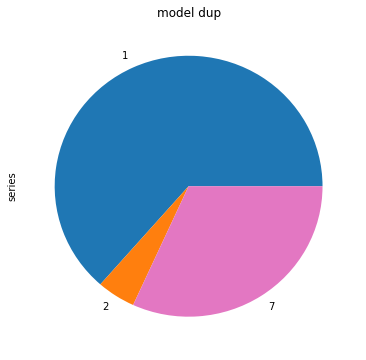

In [139]:
#展示不同mode产生重复的比例
series = pd.Series([mode_1_dup,mode_2_dup,mode_3_dup,mode_4_dup,mode_5_dup,mode_6_dup,mode_7_dup,mode_8_dup,mode_9_dup,mode_10_dup,mode_11_dup],index=['1','2', '3','4', '5','6', '7','8', '9','10', '11',], name='series')
series.plot.pie(figsize=(6, 6))
plt.title('model dup')
plt.show()

In [10]:
#抽取所有 plan信息作为一个DateFrame     列包括  pid sid 每个推荐和点击等信息     (时间复杂度，这段程序写的太傻比了，10小时和2分钟的差别，哎)
train = train_queries.merge(train_plans, 'left', ['sid'])
train = train.merge(train_clicks, 'left', ['sid'])
train['click_mode'] = train['click_mode'].fillna(0).astype(int)
train['plans_json'] = train['plans'].fillna('[]').apply(lambda x: json.loads(x))

#垃圾代码，  一定要选择下面的代码架构..  这个跑了12小时都没跑完，吐血，真的是代码不同程序效率天差地别。
# #先删除 plans_json为空的行
# train_not_null = train.dropna(subset=["plans"])

# all_plan_item=pd.DataFrame(columns=('sid','pid','distance','price','eta','transport_mode','target_click_mode'))
# for index,row in train_not_null.iterrows():
#     for tem_dist in row['plans_json']:
#         all_plan_item=all_plan_item.append({'sid':row['sid'],'pid':row['pid'],'distance':tem_dist['distance'],'price':tem_dist['price'],'eta':tem_dist['eta'],'transport_mode':tem_dist['transport_mode'],'target_click_mode':row['click_mode']},ignore_index=True)
         
#另一个平展的方式     把每个sid  pid   和对应的click_mode都转进行吧。    感觉应用的很巧妙，值的学习

plans = np.dstack((np.repeat(train['sid'].values,list(map(len,train['plans_json'].values))),np.repeat(train['pid'].values,list(map(len,train['plans_json'].values))),np.repeat(train['click_mode'].values,list(map(len,train['plans_json'].values))),np.concatenate(train['plans_json'].values)))
plans = pd.DataFrame(plans[0],columns=['sid','pid','click_mode','plans'])
plans = pd.concat([plans, pd.DataFrame.from_dict(plans['plans'].tolist())], axis=1)

print(plans)


             sid     pid click_mode  \
0        3000821     NaN          9   
1        3000821     NaN          9   
2        3000821     NaN          9   
3        3000821     NaN          9   
4        3000821     NaN          9   
5        3000821     NaN          9   
6        3085857  210736          1   
7        3085857  210736          1   
8        3085857  210736          1   
9        3085857  210736          1   
10       3085857  210736          1   
11       2944522     NaN          9   
12       2944522     NaN          9   
13       2944522     NaN          9   
14       2944522     NaN          9   
15       2944522     NaN          9   
16       2944522     NaN          9   
17       2944522     NaN          9   
18        559931  202427          1   
19        559931  202427          1   
20        559931  202427          1   
21        559931  202427          1   
22        559931  202427          1   
23       2819352  172251          7   
24       2819352  172251 

[2276822 rows x 8 columns]


In [ ]:
#做统计并进行打印

data['plans_json'] = data['plans'].fillna('[]').apply(lambda x: json.loads(x))
def  get_CVR_feature(data):
    for i, pid in tqdm(enumerate(data['sid'].values)):
        #抽取除当前行的所有行
        the_cur_row=data[data['sid']==pid]
        the_reminder_data=data[data['sid']!=pid]
        
        #获取当前行的   pid，利用pid获取  要进行统计的 所有行
        use_get_CVR_rows=the_reminder_data[the_reminder_data['pid']==the_cur_row['pid']]
        
        if df.empty==False:
            #如果不为空，进行  11种mode存在情况的统计
            for i in use_get_CVR_rows['plans_json'].values



In [ ]:
print()


     突然发现，有些sid是没有产生 任何plan反馈的，不知道这是为什么，比如看sid为251442 。这样的数据酌情使用（在有些特征构造中直接删除即可）。  估计是网速的问题。
     这样的情况因为plans本身就为空的，所以对click_mode直接设置为0即可，是一种模式表征吧。  总共的mode个数有  11+1个，有一个是为0的mode，当plan给出的规划为空时，mode就为0.

In [110]:
print(all_plan_item.head())

Empty DataFrame
Columns: [sid, pid, distance, price, eta, transport_mode, target_click_mode]
Index: []


In [ ]:
all_plan_item.info()

In [ ]:
all_plan_item.to_csv('E:/Machine-learning/kdd_cup_2019/data_set_phase1/all_plan_item.csv')

In [ ]:
#展示每个pid的   进行请求的次数（为了做pid的mode点击倾向特征做准备，防止有些出现次数太小的pid,这样直接做，就会造成很严重的穿越。）



In [ ]:
print()

#### 统计下 pid的click次数，展示次数曲线，观察点击大于10次的人的比例， 感觉超过10次才算是有一定的偏好统计意义(统计效果单独放到profile表中)

In [3]:
#提取出训练集的   plan_item 进行观察    为转化率特征做准备

path = 'E:/Machine-learning/kdd_cup_2019/data_set_phase1/'
data=pd.read_csv(path + '/feature_data/feature.csv', parse_dates=['req_time'])



In [16]:
trian_index = (data.req_time <= '2018-12-01')
trian_data     = data[trian_index].reset_index(drop=True)
trian_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Columns: 156 entries, click_mode to svd_mode_9
dtypes: float64(142), int64(7), object(7)
memory usage: 595.1+ MB


In [79]:
#print(trian_data['pid'].unique())
pid_list_count=list(trian_data.groupby(by=['pid']).size())
pid_list_count

[8,
 1,
 30,
 5,
 4,
 2,
 760,
 1,
 2,
 2,
 1,
 1,
 17,
 7,
 3,
 2,
 3,
 7,
 1,
 6,
 2,
 1,
 15,
 3,
 12,
 8,
 3,
 2,
 6,
 1,
 8,
 1,
 11,
 21,
 5,
 20,
 63,
 29,
 2,
 2,
 16,
 1,
 9,
 4,
 1,
 5,
 19,
 3,
 2,
 3,
 3,
 9,
 5,
 6,
 15,
 5,
 17,
 1,
 6,
 3,
 1,
 1,
 1,
 2,
 15,
 4,
 1,
 4,
 1,
 2,
 3,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 5,
 3,
 1,
 4,
 1,
 11,
 2,
 6,
 3,
 2,
 25,
 2,
 1,
 1,
 3,
 1,
 1,
 2,
 1,
 11,
 5,
 1,
 1,
 3,
 1,
 1,
 2,
 1,
 16,
 4,
 8,
 1,
 17,
 25,
 8,
 8,
 1,
 2,
 2,
 1,
 71,
 2,
 1,
 10,
 2,
 1,
 1,
 4,
 9,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 65,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 2,
 53,
 2,
 2,
 2,
 7,
 1,
 1,
 6,
 10,
 2,
 1,
 1,
 3,
 3,
 19,
 518,
 2,
 1,
 1,
 1,
 1,
 1,
 3,
 25,
 4,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 11,
 1,
 7,
 6,
 1,
 15,
 1,
 1,
 1,
 7,
 1,
 3,
 2,
 3,
 1,
 1,
 1,
 7,
 16,
 1,
 1,
 1,
 1,
 9,
 1,
 1,
 3,
 2,
 5,
 1,
 5,
 3,
 1,
 3,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 4,
 3,
 2,
 1,
 6,
 1,
 1,
 23,
 1,
 1,
 4,
 3,
 1,
 1,
 2,
 2,
 25,
 4,
 4,
 1,
 1,
 1,
 1,
 11,

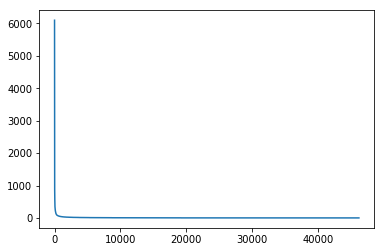

In [63]:
pid_list_count.sort(reverse=True)
pid_list_count
plt.plot(pid_list_count)

发现大部分用户都很少有打车记录，有些人打车记录则很多，比如有个人   两个月打了6000多次。感觉有些人打车特别少，怀疑 是不是是有问题的人

In [81]:
# for name,group in trian_data.groupby('pid')：
#     print name
the_query_count_df=pd.DataFrame()
pid_list=[]
for name,group in trian_data.groupby('pid'):
    #rint(name)
    pid_list.append(name)

the_query_count_df['pid']=pid_list
the_query_count_df['pid_query_count']=pid_list_count
print(the_query_count_df)


            pid  pid_query_count
0      100000.0                8
1      100002.0                1
2      100005.0               30
3      100006.0                5
4      100007.0                4
5      100010.0                2
6      100011.0              760
7      100012.0                1
8      100017.0                2
9      100018.0                2
10     100026.0                1
11     100030.0                1
12     100031.0               17
13     100033.0                7
14     100034.0                3
15     100036.0                2
16     100038.0                3
17     100043.0                7
18     100044.0                1
19     100045.0                6
20     100047.0                2
21     100048.0                1
22     100050.0               15
23     100051.0                3
24     100052.0               12
25     100053.0                8
26     100055.0                3
27     100057.0                2
28     100058.0                6
29     100

In [85]:
data=data.merge(the_query_count_df, 'left', ['pid']) 
data

click_mode           click_time             d             o       pid  \
0              9.0  2018-11-02 17:54:32  116.32,39.96  116.29,39.97       NaN   
1              1.0  2018-11-16 10:53:32  116.33,39.79  116.39,39.84  210736.0   
2              9.0  2018-10-06 10:34:23  116.27,40.00  116.31,39.93       NaN   
3              1.0  2018-11-23 14:54:18  116.39,39.90  116.27,39.88  202427.0   
4              7.0  2018-10-30 11:49:04  116.37,39.86  116.34,39.96  172251.0   
5              1.0  2018-10-18 07:38:25  116.48,39.76  116.54,39.73  135606.0   
6              1.0  2018-11-20 14:34:48  116.79,40.35  116.34,39.73  189023.0   
7              1.0  2018-10-03 09:19:55  116.24,40.22  116.26,40.22  156954.0   
8              5.0  2018-11-15 15:25:55  116.39,39.90  116.39,39.91  135045.0   
9              3.0  2018-11-08 23:14:06  116.27,39.95  116.29,40.02  176605.0   
10             1.0  2018-10-23 01:02:55  116.37,39.86  116.43,39.95       NaN   
11             1.0  2018-10-03 16:07:34  116.42,39.93  116.45,39.93  207329.0   
12             9.0  2018-11-12 13:52:51  116.58,39.91  116.32,39.98       NaN   
13             1.0  2018-10-03 19:32:59  116.40,39.91  116.40,39.92  215847.0   
14             1.0  2018-10-20 12:52:10  116.33,40.01  116.31,40.03       NaN   
15             1.0  2018-10-16 09:06:40  116.27,39.96  116.30,39.94       NaN   
16             2.0  2018-11-29 13:21:08  116.47,39.89  116.21,40.24  207363.0   
17             5.0  2018-11-02 09:38:28  116.33,39.87  116.34,39.87  144649.0   
18             9.0  2018-11-15 13:58:31  116.50,39.93  116.41,39.94  116986.0   
19             2.0  2018-10-05 15:41:20  116.32,39.89  116.33,39.97  180421.0   
20             2.0  2018-10-28 09:46:53  116.45,39.93  116.29,39.86       NaN   
21             5.0  2018-10-04 14:31:38  116.30,39.93  116.29,39.93  175212.0   
22             7.0  2018-10-04 21:22:55  116.50,39.80  116.50,39.87  112198.0   
23             9.0  2018-10-24 14:09:45  116.32,39.90  116.34,39.84  135562.0   
24             5.0  2018-11-23 16:18:33  116.34,39.94  116.34,39.95  202757.0   
25            10.0  2018-10-20 11:14:15  116.42,39.90  116.34,40.03  200008.0   
26             2.0  2018-11-03 13:54:51  116.43,39.94  116.35,40.00  112198.0   
27             0.0                  NaN  116.33,39.84  116.34,39.85  211790.0   
28             3.0  2018-11-16 13:31:50  116.31,39.99  116.30,39.99  116844.0   
29             2.0  2018-11-28 08:34:37  116.43,39.94  116.43,39.90       NaN   
...            ...                  ...           ...           ...       ...   
594328         NaN                  NaN  116.46,39.95  116.46,39.95       NaN   
594329         NaN                  NaN  116.49,39.93  116.47,39.91       NaN   
594330         NaN                  NaN  116.42,39.85  116.20,40.14  128738.0   
594331         NaN                  NaN  116.39,39.90  116.34,39.94  160797.0   
594332         NaN                  NaN  116.43,39.76  116.30,40.05       NaN   
594333         NaN                  NaN  116.34,39.82  116.42,39.88  109533.0   
594334         NaN                  NaN  116.28,39.92  116.34,39.89       NaN   
594335         NaN                  NaN  116.60,40.08  116.46,39.93  146526.0   
594336         NaN                  NaN  116.42,39.90  116.33,39.94  142281.0   
594337         NaN                  NaN  116.36,39.88  116.42,39.90       NaN   
594338         NaN                  NaN  116.37,39.86  116.10,39.90       NaN   
594339         NaN                  NaN  116.46,39.98  116.46,39.97       NaN   
594340         NaN                  NaN  116.37,39.91  116.41,39.91  181772.0   
594341         NaN                  NaN  116.30,39.88  116.29,39.88       NaN   
594342         NaN                  NaN  116.32,40.00  116.30,39.99       NaN   
594343         NaN                  NaN  116.57,39.86  116.41,40.05  108949.0   
594344         NaN                  NaN  116.35,39.87  116.56,40.06  156329.0   
594345         NaN                  NaN

In [13]:
#展示 不同  小时 选择不同模式的分布图
data['req_time_weekday']=data.apply(lambda row:row['req_time'].dayofweek,axis=1)
data['req_time_day']=data.apply(lambda row:row['req_time'].day,axis=1)
data['req_time_hour']=data.apply(lambda row:row['req_time'].hour,axis=1)

In [12]:
print(data['req_time_weekday'])

0         <built-in method weekday of Timestamp object a...
1         <built-in method weekday of Timestamp object a...
2         <built-in method weekday of Timestamp object a...
3         <built-in method weekday of Timestamp object a...
4         <built-in method weekday of Timestamp object a...
5         <built-in method weekday of Timestamp object a...
6         <built-in method weekday of Timestamp object a...
7         <built-in method weekday of Timestamp object a...
8         <built-in method weekday of Timestamp object a...
9         <built-in method weekday of Timestamp object a...
10        <built-in method weekday of Timestamp object a...
11        <built-in method weekday of Timestamp object a...
12        <built-in method weekday of Timestamp object a...
13        <built-in method weekday of Timestamp object a...
14        <built-in method weekday of Timestamp object a...
15        <built-in method weekday of Timestamp object a...
16        <built-in method weekday of Ti

## 训练集 - model点击表

# 测试集 - 业务请求表

In [8]:
test_queries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94358 entries, 0 to 94357
Data columns (total 5 columns):
sid         94358 non-null int64
pid         62911 non-null float64
req_time    94358 non-null datetime64[ns]
o           94358 non-null object
d           94358 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 3.6+ MB


# 测试集 - plans规划

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94358 entries, 0 to 94357
Data columns (total 5 columns):
sid         94358 non-null int64
pid         62911 non-null float64
req_time    94358 non-null datetime64[ns]
o           94358 non-null object
d           94358 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 3.6+ MB


# 对在特征构建时候挖掘出来的强特进行分析

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import os

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import json 
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from itertools import product
import ast
path = 'E:/Machine-learning/kdd_cup_2019/data/'
data=pd.read_csv(path + '/feature_692434.csv', parse_dates=['req_time','plan_time','click_time'])

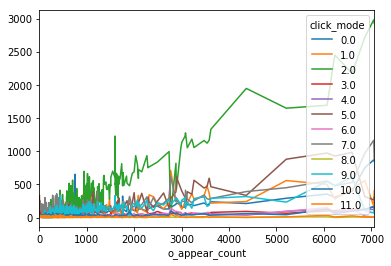

In [2]:
#画图展示，随着点的出现次数变化后的   mode方式选择的情况
pd.crosstab(data['o_appear_count'],data['click_mode']).plot()

可以发现区分意义很强，随着  count的增加，有很大的区分性产生了，但是有些地点还是有点问题

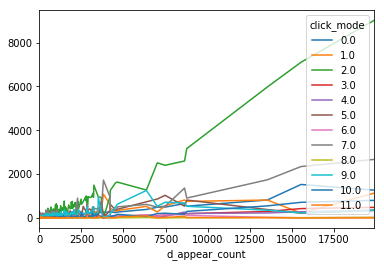

In [3]:
pd.crosstab(data['d_appear_count'],data['click_mode']).plot()

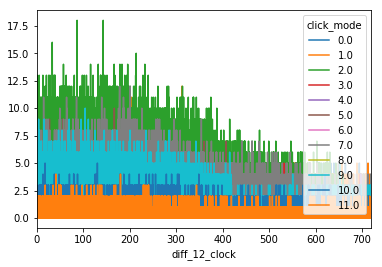

In [4]:
pd.crosstab(data['diff_12_clock'],data['click_mode']).plot()


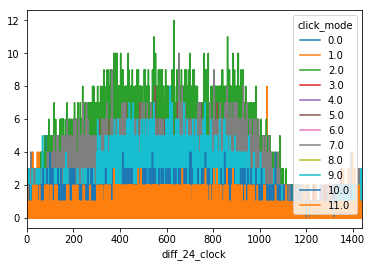

In [6]:
pd.crosstab(data['diff_24_clock'],data['click_mode']).plot()